In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor,\
    AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader
import optuna

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history, AdaBoost_creator 
from library.XGBoost import XGBoost_creator
from library.LightGBM import LightGBM_creator
from library.CatBoost import CatBoost_creator
from library.RandomForest import RandomForest_creator
from library.ExtraTrees import ExtraTrees_creator
from library.NeuralNetwork import RunhistSet, NeuralNetworkC, trainingC
from library.StackingCV_Scheme3 import stratified_data, runall_LR, runall_RidgeR, stackingCV_creator, vif, \
    correlation_plot, rank_importance

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

Using cpu device.


'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### Load Hyperparameters

In [2]:
# load hyperparameters of all base learners in a dictionary
def load_hyper(num_set, date, model_list, iter_list, filename, mode, TPE_multi) :
    
    sampler = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
    allset_dict = {}
    for j in range(1, num_set) :
        
        model_dict = {}
        for i, model in enumerate(model_list) :

            with open(f'hyperparameter/{date}/{filename}_{model}{mode}_{sampler}_{iter_list[i]}.data', 'rb') as f:
                temp_dict = pickle.load(f)
                model_dict[model] = temp_dict[f'set{j}']
                
        allset_dict[f'set{j}'] = model_dict
        
    return allset_dict

### Transform Data by Base Learners

In [3]:
# input training data to the base learners and output the outcome
def transform_train(train_data, mode, base_param, cv, add_origin = False):
    
    set_name = list(base_param.keys())
    model_list = list(base_param[set_name[0]].keys())
    set_dict = {}
    for i in tqdm(set_name):

        train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train_data[i], cv = cv)
        all_cv = pd.DataFrame()
        for j in tqdm(range(cv)):

            model_predict = valid_x_dict[j].copy().reset_index(drop = True) if add_origin else pd.DataFrame()
            if mode == 'C':          
                if 'NeuralNetwork' in model_list:
                    temp_train = RunhistSet(train_x_dict[j], train_y_dict[j])
                    temp_valid = RunhistSet(valid_x_dict[j], valid_y_dict[j])
                    train_loader = DataLoader(temp_train, 
                                              batch_size = base_param[i]['NeuralNetwork']['batch_size'], 
                                              shuffle = True)
                    valid_loader = DataLoader(temp_valid, batch_size = len(valid_x_dict[j]), shuffle = False)
                    nn_model = NeuralNetworkC(dim = train_x_dict[j].shape[1])
                    optimizer = torch.optim.Adam(nn_model.parameters(), 
                                                 lr = base_param[i]['NeuralNetwork']['learning_rate'], 
                                                 weight_decay = base_param[i]['NeuralNetwork']['weight_decay'])
                    criterion = nn.CrossEntropyLoss(
                        weight = torch.tensor([1-base_param[i]['NeuralNetwork']['bad_weight'], 
                                               base_param[i]['NeuralNetwork']['bad_weight']])).to('cpu')
                    network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                              early_stop = 10)
                    for x, y in valid_loader:
                        output = network(x)
                        predict_y = output.data[:, 1]
                    predict = pd.DataFrame({'N': predict_y.numpy()})
                    model_predict = pd.concat([model_predict, predict], axis = 1)
                
                if 'XGBoost' in model_list:                     
                    clf = XGBClassifier(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:                        
                    clf = LGBMClassifier(**base_param[i]['LightGBM'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    clf = CatBoostClassifier(**base_param[i]['CatBoost'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeClassifier(
                            max_depth = base_param[i]['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    clf = AdaBoostClassifier(**boost_param)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    clf = RandomForestClassifier(**base_param[i]['RandomForest'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    clf = ExtraTreesClassifier(**base_param[i]['ExtraTrees'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            elif mode == 'R':

                if 'XGBoost' in model_list:
                    reg = XGBRegressor(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    reg = LGBMRegressor(**base_param[i]['LightGBM'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    reg = CatBoostRegressor(**base_param[i]['CatBoost'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeRegressor(
                            max_depth = base_param[i]['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    reg = AdaBoostRegressor(**boost_param)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    reg = RandomForestRegressor(**base_param[i]['RandomForest'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    reg = ExtraTreesRegressor(**base_param[i]['ExtraTrees'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            test_label = valid_y_dict[j].reset_index(drop = True)
            done_cv = pd.concat([model_predict, test_label], axis = 1)
            all_cv = pd.concat([all_cv, done_cv], axis = 0)

        set_dict[i] = all_cv
    
    return set_dict


# input testing data to the base learners and output the outcome
def transform_test(train_data, test_data, mode, base_param, add_origin = False):
    
    set_name = list(base_param.keys())
    model_list = list(base_param[set_name[0]].keys())
    test_dict = {}
    for i in tqdm(set_name):
        
        train_x, train_y, test_x, test_y = label_divide(train_data[i], test_data, train_only = False)
        model_predict = test_x.copy().reset_index(drop = True) if add_origin else pd.DataFrame()
        if mode == 'C':

            if 'NeuralNetwork' in model_list:
                temp_train = RunhistSet(train_x, train_y)
                temp_test = RunhistSet(test_x, test_y)
                train_loader = DataLoader(temp_train, 
                                          batch_size = base_param[i]['NeuralNetwork']['batch_size'], 
                                          shuffle = True)
                test_loader = DataLoader(temp_test, batch_size = len(test_x), shuffle = False)
                nn_model = NeuralNetworkC(dim = train_x.shape[1])
                optimizer = torch.optim.Adam(nn_model.parameters(), 
                                             lr = base_param[i]['NeuralNetwork']['learning_rate'], 
                                             weight_decay = base_param[i]['NeuralNetwork']['weight_decay'])
                criterion = nn.CrossEntropyLoss(
                    weight = torch.tensor([1-base_param[i]['NeuralNetwork']['bad_weight'], 
                                           base_param[i]['NeuralNetwork']['bad_weight']])).to('cpu')
                network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                          early_stop = 10)
                for X, Y in test_loader:
                    X, Y = X.float(), Y.long()
                    output = network(X)
                    predict_y = output.data[:, 1]
                predict = pd.DataFrame({'N': predict_y.numpy()})
                model_predict = pd.concat([model_predict, predict], axis = 1)
            
            if 'XGBoost' in model_list:
                clf = XGBClassifier(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'X': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                clf = LGBMClassifier(**base_param[i]['LightGBM'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'L': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                clf = CatBoostClassifier(**base_param[i]['CatBoost'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'C': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeClassifier(
                        max_depth = base_param[i]['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                clf = AdaBoostClassifier(**boost_param)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'A': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                clf = RandomForestClassifier(**base_param[i]['RandomForest'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'R': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                clf = ExtraTreesClassifier(**base_param[i]['ExtraTrees'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'E': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        elif mode == 'R':

            if 'XGBoost' in model_list:
                reg = XGBRegressor(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'X': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                reg = LGBMRegressor(**base_param[i]['LightGBM'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'L': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                reg = CatBoostRegressor(**base_param[i]['CatBoost'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'C': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeRegressor(
                        max_depth = base_param[i]['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                reg = AdaBoostRegressor(**boost_param)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'A': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                reg = RandomForestRegressor(**base_param[i]['RandomForest'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'R': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                reg = ExtraTreesRegressor(**base_param[i]['ExtraTrees'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'E': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        model_done = pd.concat([model_predict, test_y], axis = 1)
        test_dict[i] = model_done
        
    return test_dict

## 

### Load Data

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1360, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1376, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1369, 88)  balance ratio: 1.02
Dimension of dataset 7 : (1317, 88)  balance ratio: 1.1
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (2224, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2256, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

## Base Learner

In [5]:
##### loading hyperparameters of all base learners #####
hyper_info = {
    'num_set': 10,
    'date': '20220308',
    'model_list': ['XGBoost', 'NeuralNetwork', 'LightGBM', 'CatBoost'],
    'iter_list': [25, 10, 25, 25],
    'filename': 'runhist_array_m2m4_m5_3criteria',
    'TPE_multi': False
}

base_paramC = load_hyper(**hyper_info, mode = 'C')

In [ ]:
##### or optimize the datasets of whole by optuna ##### 
target_iter = dict(zip(hyper_info['model_list'], hyper_info['iter_list']))

base_param_allC = optimize_base(train_data = {'all': run_train}, 
                                mode = 'C', 
                                TPE_multi = False, 
                                base_list = hyper_info['model_list'], 
                                iter_dict = target_iter,
                                filename = 'runhist_array_m2m4_m5_3criteria')

### Data Transformation

In [12]:
print('Transform Training Data:')
train_firstC = transform_train(run_train, 
                               mode = 'C', 
                               base_param = base_paramC, 
                               cv = 5,
                               add_origin = True)
print('\nTransform Testing Data:')
test_firstC = transform_test(run_train, 
                             run_test, 
                             mode = 'C', 
                             base_param = base_paramC,
                             add_origin = True)
train_firstC_x, train_firstC_y = train_set(train_firstC)
test_firstC_x, test_firstC_y = train_set(test_firstC) 

# ignore
train_firstC['set0'] = {}

Transform Training Data:


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5567383618498587
Epoch 2: Train Loss = 0.4450936760713924
Epoch 3: Train Loss = 0.40669129318887853
Epoch 4: Train Loss = 0.3837799482843015
Epoch 5: Train Loss = 0.3632568003884543
Recall = 0.9453952730236349, Aging Rate = 0.4877750611246944, Precision = 0.9690893901420217
Validation: Test Loss = 0.3454248575583258
Recall = 0.9612876935615322, Aging Rate = 0.48859005704971475, precision = 0.9837364470391994
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.34389392823928144
Epoch 7: Train Loss = 0.3362002589154652
Epoch 8: Train Loss = 0.33295517387483403
Epoch 9: Train Loss = 0.32914344642156496
Epoch 10: Train Loss = 0.32619612818825217
Recall = 0.9816625916870416, Aging Rate = 0.49123879380603097, Precision = 0.9991704686851929
Validation: Test Loss = 0.3253729707988764
Recall = 0.9816625916870416, Aging Rate = 0.4910350448247759, precision = 0.9995850622406639
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32504297128613635
Epoch 12: Train Loss = 0


Epoch 96: Train Loss = 0.3198706204801822
Epoch 97: Train Loss = 0.31860580384585563
Epoch 98: Train Loss = 0.3210462755368022
Epoch 99: Train Loss = 0.31986492932960087
Epoch 100: Train Loss = 0.32206990246182066
Recall = 0.9922575387123065, Aging Rate = 0.49816625916870416, Precision = 0.9959100204498977
Validation: Test Loss = 0.3199584335695949
Recall = 0.9963325183374083, Aging Rate = 0.5004074979625102, precision = 0.9955211726384365

0:	learn: 0.4508045	total: 9.24ms	remaining: 4.61s
1:	learn: 0.2987272	total: 20.3ms	remaining: 5.06s
2:	learn: 0.2255351	total: 31ms	remaining: 5.13s
3:	learn: 0.1705052	total: 41.8ms	remaining: 5.18s
4:	learn: 0.1334668	total: 52.9ms	remaining: 5.24s
5:	learn: 0.1172777	total: 60ms	remaining: 4.94s
6:	learn: 0.1048611	total: 66.8ms	remaining: 4.71s
7:	learn: 0.0904032	total: 76.7ms	remaining: 4.72s
8:	learn: 0.0808005	total: 84.5ms	remaining: 4.61s
9:	learn: 0.0689773	total: 93.3ms	remaining: 4.57s
10:	learn: 0.0622789	total: 101ms	remaining: 4.4

182:	learn: 0.0050099	total: 743ms	remaining: 1.29s
183:	learn: 0.0050099	total: 747ms	remaining: 1.28s
184:	learn: 0.0049748	total: 751ms	remaining: 1.28s
185:	learn: 0.0049748	total: 754ms	remaining: 1.27s
186:	learn: 0.0049747	total: 757ms	remaining: 1.27s
187:	learn: 0.0049747	total: 761ms	remaining: 1.26s
188:	learn: 0.0049747	total: 764ms	remaining: 1.26s
189:	learn: 0.0049746	total: 767ms	remaining: 1.25s
190:	learn: 0.0049746	total: 770ms	remaining: 1.25s
191:	learn: 0.0049746	total: 773ms	remaining: 1.24s
192:	learn: 0.0049746	total: 776ms	remaining: 1.23s
193:	learn: 0.0049745	total: 779ms	remaining: 1.23s
194:	learn: 0.0049743	total: 783ms	remaining: 1.22s
195:	learn: 0.0049743	total: 786ms	remaining: 1.22s
196:	learn: 0.0049743	total: 789ms	remaining: 1.21s
197:	learn: 0.0049742	total: 792ms	remaining: 1.21s
198:	learn: 0.0049742	total: 795ms	remaining: 1.2s
199:	learn: 0.0049742	total: 798ms	remaining: 1.2s
200:	learn: 0.0049741	total: 801ms	remaining: 1.19s
201:	learn: 0.

356:	learn: 0.0042259	total: 1.32s	remaining: 529ms
357:	learn: 0.0042259	total: 1.32s	remaining: 525ms
358:	learn: 0.0042259	total: 1.33s	remaining: 521ms
359:	learn: 0.0042258	total: 1.33s	remaining: 517ms
360:	learn: 0.0042255	total: 1.33s	remaining: 513ms
361:	learn: 0.0042156	total: 1.34s	remaining: 509ms
362:	learn: 0.0042156	total: 1.34s	remaining: 506ms
363:	learn: 0.0042154	total: 1.34s	remaining: 502ms
364:	learn: 0.0042154	total: 1.34s	remaining: 498ms
365:	learn: 0.0042154	total: 1.35s	remaining: 494ms
366:	learn: 0.0042153	total: 1.35s	remaining: 490ms
367:	learn: 0.0042153	total: 1.35s	remaining: 486ms
368:	learn: 0.0042152	total: 1.36s	remaining: 482ms
369:	learn: 0.0042152	total: 1.36s	remaining: 478ms
370:	learn: 0.0042152	total: 1.36s	remaining: 475ms
371:	learn: 0.0042152	total: 1.37s	remaining: 471ms
372:	learn: 0.0042152	total: 1.37s	remaining: 467ms
373:	learn: 0.0042151	total: 1.37s	remaining: 463ms
374:	learn: 0.0042151	total: 1.38s	remaining: 459ms
375:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5364912814888025
Epoch 2: Train Loss = 0.4247745053498067
Epoch 3: Train Loss = 0.3816235225766096
Epoch 4: Train Loss = 0.3648184974842569
Epoch 5: Train Loss = 0.35405073079911303
Recall = 0.9539527302363489, Aging Rate = 0.48920130399348005, Precision = 0.9750104123281966
Validation: Test Loss = 0.3382388646513248
Recall = 0.9669926650366748, Aging Rate = 0.48594132029339854, precision = 0.9949685534591195
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3361410235814574
Epoch 7: Train Loss = 0.3290824904224206
Epoch 8: Train Loss = 0.32638252187086103
Epoch 9: Train Loss = 0.3235493930938677
Epoch 10: Train Loss = 0.3224074518962322
Recall = 0.9881825590872045, Aging Rate = 0.4944987775061125, Precision = 0.9991759373712402
Validation: Test Loss = 0.3220322572708907
Recall = 0.9881825590872045, Aging Rate = 0.49429502852485735, precision = 0.9995877988458368
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32212235913980075
Epoch 12: Train Loss = 0.3

Epoch 97: Train Loss = 0.31958067849484906
Epoch 98: Train Loss = 0.3207194848622164
Epoch 99: Train Loss = 0.3187325866171861
Epoch 100: Train Loss = 0.31722383248485386
Recall = 0.9947025264873676, Aging Rate = 0.4973512632436838, Precision = 0
Validation: Test Loss = 0.31671845772058477
Recall = 0.9951100244498777, Aging Rate = 0.49755501222493886, precision = 1.0

0:	learn: 0.4257112	total: 10.1ms	remaining: 5.04s
1:	learn: 0.2811074	total: 21ms	remaining: 5.23s
2:	learn: 0.2092702	total: 29.6ms	remaining: 4.9s
3:	learn: 0.1713279	total: 38.4ms	remaining: 4.76s
4:	learn: 0.1390635	total: 45.6ms	remaining: 4.51s
5:	learn: 0.1130262	total: 54.7ms	remaining: 4.51s
6:	learn: 0.0949561	total: 62ms	remaining: 4.37s
7:	learn: 0.0855704	total: 69.5ms	remaining: 4.28s
8:	learn: 0.0781641	total: 75.2ms	remaining: 4.1s
9:	learn: 0.0699229	total: 81ms	remaining: 3.97s
10:	learn: 0.0611195	total: 87.2ms	remaining: 3.88s
11:	learn: 0.0580785	total: 92ms	remaining: 3.74s
12:	learn: 0.0543146	tota

182:	learn: 0.0049497	total: 760ms	remaining: 1.32s
183:	learn: 0.0049497	total: 763ms	remaining: 1.31s
184:	learn: 0.0049497	total: 766ms	remaining: 1.3s
185:	learn: 0.0049497	total: 769ms	remaining: 1.3s
186:	learn: 0.0049496	total: 772ms	remaining: 1.29s
187:	learn: 0.0049496	total: 775ms	remaining: 1.29s
188:	learn: 0.0049495	total: 778ms	remaining: 1.28s
189:	learn: 0.0049241	total: 782ms	remaining: 1.27s
190:	learn: 0.0049183	total: 785ms	remaining: 1.27s
191:	learn: 0.0049183	total: 788ms	remaining: 1.26s
192:	learn: 0.0049178	total: 791ms	remaining: 1.26s
193:	learn: 0.0049178	total: 794ms	remaining: 1.25s
194:	learn: 0.0048996	total: 797ms	remaining: 1.25s
195:	learn: 0.0048996	total: 800ms	remaining: 1.24s
196:	learn: 0.0048995	total: 803ms	remaining: 1.23s
197:	learn: 0.0048995	total: 806ms	remaining: 1.23s
198:	learn: 0.0048995	total: 809ms	remaining: 1.22s
199:	learn: 0.0048995	total: 812ms	remaining: 1.22s
200:	learn: 0.0048994	total: 815ms	remaining: 1.21s
201:	learn: 0.

363:	learn: 0.0043000	total: 1.33s	remaining: 495ms
364:	learn: 0.0043000	total: 1.33s	remaining: 492ms
365:	learn: 0.0042999	total: 1.33s	remaining: 488ms
366:	learn: 0.0042999	total: 1.33s	remaining: 484ms
367:	learn: 0.0042998	total: 1.34s	remaining: 480ms
368:	learn: 0.0042998	total: 1.34s	remaining: 476ms
369:	learn: 0.0042998	total: 1.34s	remaining: 472ms
370:	learn: 0.0042980	total: 1.35s	remaining: 469ms
371:	learn: 0.0042309	total: 1.35s	remaining: 465ms
372:	learn: 0.0042308	total: 1.35s	remaining: 461ms
373:	learn: 0.0042308	total: 1.36s	remaining: 457ms
374:	learn: 0.0042308	total: 1.36s	remaining: 454ms
375:	learn: 0.0042307	total: 1.36s	remaining: 450ms
376:	learn: 0.0042307	total: 1.37s	remaining: 446ms
377:	learn: 0.0042306	total: 1.37s	remaining: 443ms
378:	learn: 0.0042306	total: 1.37s	remaining: 439ms
379:	learn: 0.0042306	total: 1.38s	remaining: 435ms
380:	learn: 0.0042305	total: 1.38s	remaining: 431ms
381:	learn: 0.0042305	total: 1.38s	remaining: 427ms
382:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5570768488459426
Epoch 2: Train Loss = 0.44802156282695904
Epoch 3: Train Loss = 0.4070331799075208
Epoch 4: Train Loss = 0.37710458000144614
Epoch 5: Train Loss = 0.3626299005258438
Recall = 0.9506726457399103, Aging Rate = 0.4889930697105585, Precision = 0.9720716965402251
Validation: Test Loss = 0.34530724219968745
Recall = 0.968609865470852, Aging Rate = 0.4924582144313086, precision = 0.9834437086092715
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3431731158502239
Epoch 7: Train Loss = 0.3357128639805331
Epoch 8: Train Loss = 0.33212629586300263
Epoch 9: Train Loss = 0.33081440047444105
Epoch 10: Train Loss = 0.32833070225050826
Recall = 0.9792091316754994, Aging Rate = 0.4912352221769262, Precision = 0.9966804979253112
Validation: Test Loss = 0.3269466207895384
Recall = 0.9804321239298818, Aging Rate = 0.49143905421932327, precision = 0.9975114060555786
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3270369220572105
Epoch 12: Train Loss = 0.3

Epoch 94: Train Loss = 0.3169865052747668
Epoch 95: Train Loss = 0.3166156947564165
Recall = 0.9959233591520587, Aging Rate = 0.49836934366082347, Precision = 0.9991820040899796
Validation: Test Loss = 0.31656019289397336
Recall = 0.9959233591520587, Aging Rate = 0.49836934366082347, precision = 0.9991820040899796
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3172073860679701
Epoch 97: Train Loss = 0.3166478565163968
Epoch 98: Train Loss = 0.31664976448464577
Epoch 99: Train Loss = 0.31659634074190907
Epoch 100: Train Loss = 0.31674418808293253
Recall = 0.9959233591520587, Aging Rate = 0.4979616795760293, Precision = 0
Validation: Test Loss = 0.31666329661000764
Recall = 0.9959233591520587, Aging Rate = 0.4979616795760293, precision = 1.0
Model in epoch 100 is saved.

0:	learn: 0.4455619	total: 10.7ms	remaining: 5.36s
1:	learn: 0.3135675	total: 22ms	remaining: 5.49s
2:	learn: 0.2159655	total: 33.3ms	remaining: 5.51s
3:	learn: 0.1691279	total: 43.8ms	remaining: 5.43s
4:	learn: 0

157:	learn: 0.0051172	total: 730ms	remaining: 1.58s
158:	learn: 0.0051172	total: 734ms	remaining: 1.57s
159:	learn: 0.0051172	total: 738ms	remaining: 1.57s
160:	learn: 0.0051171	total: 742ms	remaining: 1.56s
161:	learn: 0.0051171	total: 745ms	remaining: 1.55s
162:	learn: 0.0051169	total: 749ms	remaining: 1.55s
163:	learn: 0.0051168	total: 752ms	remaining: 1.54s
164:	learn: 0.0051168	total: 756ms	remaining: 1.53s
165:	learn: 0.0051167	total: 759ms	remaining: 1.53s
166:	learn: 0.0051166	total: 763ms	remaining: 1.52s
167:	learn: 0.0051164	total: 766ms	remaining: 1.51s
168:	learn: 0.0051045	total: 770ms	remaining: 1.51s
169:	learn: 0.0051043	total: 774ms	remaining: 1.5s
170:	learn: 0.0050549	total: 778ms	remaining: 1.5s
171:	learn: 0.0049923	total: 782ms	remaining: 1.49s
172:	learn: 0.0049923	total: 786ms	remaining: 1.49s
173:	learn: 0.0049921	total: 789ms	remaining: 1.48s
174:	learn: 0.0049921	total: 793ms	remaining: 1.47s
175:	learn: 0.0049918	total: 797ms	remaining: 1.47s
176:	learn: 0.

364:	learn: 0.0042325	total: 1.47s	remaining: 542ms
365:	learn: 0.0042324	total: 1.47s	remaining: 538ms
366:	learn: 0.0042323	total: 1.47s	remaining: 534ms
367:	learn: 0.0042322	total: 1.48s	remaining: 529ms
368:	learn: 0.0042319	total: 1.48s	remaining: 525ms
369:	learn: 0.0041980	total: 1.48s	remaining: 522ms
370:	learn: 0.0041979	total: 1.49s	remaining: 517ms
371:	learn: 0.0041809	total: 1.49s	remaining: 513ms
372:	learn: 0.0041808	total: 1.5s	remaining: 509ms
373:	learn: 0.0041808	total: 1.5s	remaining: 505ms
374:	learn: 0.0041807	total: 1.5s	remaining: 501ms
375:	learn: 0.0041806	total: 1.5s	remaining: 496ms
376:	learn: 0.0041806	total: 1.51s	remaining: 492ms
377:	learn: 0.0041806	total: 1.51s	remaining: 488ms
378:	learn: 0.0041806	total: 1.51s	remaining: 484ms
379:	learn: 0.0041803	total: 1.52s	remaining: 480ms
380:	learn: 0.0041803	total: 1.52s	remaining: 476ms
381:	learn: 0.0041803	total: 1.52s	remaining: 471ms
382:	learn: 0.0041751	total: 1.53s	remaining: 467ms
383:	learn: 0.00

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5464601171337304
Epoch 2: Train Loss = 0.4287800212992627
Epoch 3: Train Loss = 0.3888390696719107
Epoch 4: Train Loss = 0.36652237026304757
Epoch 5: Train Loss = 0.354938810519698
Recall = 0.954360228198859, Aging Rate = 0.4889975550122249, Precision = 0.9758333333333333
Validation: Test Loss = 0.33817262470285003
Recall = 0.9678076609616952, Aging Rate = 0.486960065199674, precision = 0.9937238493723849
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33544319292443886
Epoch 7: Train Loss = 0.3280937667532286
Epoch 8: Train Loss = 0.3262076138624255
Epoch 9: Train Loss = 0.3253570491935338
Epoch 10: Train Loss = 0.3247345454972647
Recall = 0.984922575387123, Aging Rate = 0.4930725346373268, Precision = 0.9987603305785124
Validation: Test Loss = 0.32402868028472087
Recall = 0.9832925835370823, Aging Rate = 0.49185004074979627, precision = 0.9995857497928748
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32411063776428173
Epoch 12: Train Loss = 0.32339

Epoch 96: Train Loss = 0.31828787947147963
Epoch 97: Train Loss = 0.32035333231492263
Epoch 98: Train Loss = 0.3190539994177628
Epoch 99: Train Loss = 0.31756506844468496
Epoch 100: Train Loss = 0.3161127194944396
Recall = 0.9963325183374083, Aging Rate = 0.49816625916870416, Precision = 0
Validation: Test Loss = 0.31596392422258707
Recall = 0.9963325183374083, Aging Rate = 0.49816625916870416, precision = 1.0

0:	learn: 0.4631640	total: 8.7ms	remaining: 4.34s
1:	learn: 0.2984518	total: 20.6ms	remaining: 5.12s
2:	learn: 0.2134591	total: 30.6ms	remaining: 5.08s
3:	learn: 0.1629266	total: 41.5ms	remaining: 5.14s
4:	learn: 0.1443227	total: 50ms	remaining: 4.95s
5:	learn: 0.1186110	total: 61ms	remaining: 5.02s
6:	learn: 0.1028981	total: 68.4ms	remaining: 4.82s
7:	learn: 0.0849190	total: 76.2ms	remaining: 4.69s
8:	learn: 0.0736492	total: 83.9ms	remaining: 4.58s
9:	learn: 0.0650654	total: 92.6ms	remaining: 4.54s
10:	learn: 0.0575460	total: 99ms	remaining: 4.4s
11:	learn: 0.0523902	total: 105

172:	learn: 0.0046297	total: 800ms	remaining: 1.51s
173:	learn: 0.0045914	total: 805ms	remaining: 1.51s
174:	learn: 0.0045914	total: 809ms	remaining: 1.5s
175:	learn: 0.0045912	total: 814ms	remaining: 1.5s
176:	learn: 0.0045911	total: 819ms	remaining: 1.49s
177:	learn: 0.0045910	total: 824ms	remaining: 1.49s
178:	learn: 0.0045909	total: 828ms	remaining: 1.49s
179:	learn: 0.0045909	total: 833ms	remaining: 1.48s
180:	learn: 0.0045274	total: 838ms	remaining: 1.48s
181:	learn: 0.0045273	total: 843ms	remaining: 1.47s
182:	learn: 0.0045273	total: 848ms	remaining: 1.47s
183:	learn: 0.0044805	total: 852ms	remaining: 1.46s
184:	learn: 0.0044281	total: 858ms	remaining: 1.46s
185:	learn: 0.0043998	total: 863ms	remaining: 1.46s
186:	learn: 0.0043230	total: 871ms	remaining: 1.46s
187:	learn: 0.0043228	total: 877ms	remaining: 1.45s
188:	learn: 0.0043227	total: 882ms	remaining: 1.45s
189:	learn: 0.0043227	total: 886ms	remaining: 1.45s
190:	learn: 0.0042661	total: 893ms	remaining: 1.44s
191:	learn: 0.

355:	learn: 0.0034787	total: 1.72s	remaining: 694ms
356:	learn: 0.0034786	total: 1.72s	remaining: 689ms
357:	learn: 0.0034786	total: 1.73s	remaining: 685ms
358:	learn: 0.0034786	total: 1.73s	remaining: 680ms
359:	learn: 0.0034784	total: 1.74s	remaining: 675ms
360:	learn: 0.0034783	total: 1.74s	remaining: 670ms
361:	learn: 0.0034783	total: 1.75s	remaining: 665ms
362:	learn: 0.0034783	total: 1.75s	remaining: 661ms
363:	learn: 0.0034782	total: 1.75s	remaining: 656ms
364:	learn: 0.0034782	total: 1.76s	remaining: 651ms
365:	learn: 0.0034779	total: 1.76s	remaining: 646ms
366:	learn: 0.0034779	total: 1.77s	remaining: 642ms
367:	learn: 0.0034777	total: 1.77s	remaining: 637ms
368:	learn: 0.0034777	total: 1.78s	remaining: 632ms
369:	learn: 0.0034777	total: 1.78s	remaining: 627ms
370:	learn: 0.0034777	total: 1.79s	remaining: 622ms
371:	learn: 0.0034777	total: 1.79s	remaining: 618ms
372:	learn: 0.0034777	total: 1.8s	remaining: 613ms
373:	learn: 0.0034776	total: 1.8s	remaining: 608ms
374:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5387074591260126
Epoch 2: Train Loss = 0.4334725554967189
Epoch 3: Train Loss = 0.38800258884078087
Epoch 4: Train Loss = 0.3631571493997313
Epoch 5: Train Loss = 0.354828753206033
Recall = 0.9600489196901753, Aging Rate = 0.4942927028128822, Precision = 0.9711340206185567
Validation: Test Loss = 0.3352941751139921
Recall = 0.9796167957602935, Aging Rate = 0.493681206685691, precision = 0.9921552436003304
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3340241314317079
Epoch 7: Train Loss = 0.3292430349626786
Epoch 8: Train Loss = 0.32580521824259784
Epoch 9: Train Loss = 0.3250398790525311
Epoch 10: Train Loss = 0.3241785679405872
Recall = 0.9845087647778231, Aging Rate = 0.49286587851610275, Precision = 0.9987593052109182
Validation: Test Loss = 0.32412231004923353
Recall = 0.9849164288626172, Aging Rate = 0.49266204647370565, precision = 0.9995862639635912
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32412580580211786
Epoch 12: Train Loss = 0.323

Epoch 98: Train Loss = 0.3180855883416768
Epoch 99: Train Loss = 0.3172432357711885
Epoch 100: Train Loss = 0.31675277107888417
Recall = 0.9955156950672646, Aging Rate = 0.4977578475336323, Precision = 0
Validation: Test Loss = 0.31668752611679685
Recall = 0.9955156950672646, Aging Rate = 0.4977578475336323, precision = 1.0

0:	learn: 0.4793277	total: 9.18ms	remaining: 4.58s
1:	learn: 0.3079313	total: 21.3ms	remaining: 5.3s
2:	learn: 0.2280225	total: 31.5ms	remaining: 5.21s
3:	learn: 0.2050237	total: 38.4ms	remaining: 4.76s
4:	learn: 0.1523959	total: 49.1ms	remaining: 4.86s
5:	learn: 0.1201527	total: 61.6ms	remaining: 5.07s
6:	learn: 0.1065074	total: 70ms	remaining: 4.93s
7:	learn: 0.0964477	total: 76.4ms	remaining: 4.7s
8:	learn: 0.0834627	total: 86.4ms	remaining: 4.71s
9:	learn: 0.0693126	total: 95.1ms	remaining: 4.66s
10:	learn: 0.0606267	total: 104ms	remaining: 4.62s
11:	learn: 0.0550999	total: 111ms	remaining: 4.5s
12:	learn: 0.0496799	total: 116ms	remaining: 4.36s
13:	learn: 0.04

187:	learn: 0.0056575	total: 761ms	remaining: 1.26s
188:	learn: 0.0056575	total: 764ms	remaining: 1.26s
189:	learn: 0.0056574	total: 767ms	remaining: 1.25s
190:	learn: 0.0056571	total: 770ms	remaining: 1.25s
191:	learn: 0.0056571	total: 773ms	remaining: 1.24s
192:	learn: 0.0056570	total: 776ms	remaining: 1.23s
193:	learn: 0.0056567	total: 780ms	remaining: 1.23s
194:	learn: 0.0056565	total: 783ms	remaining: 1.22s
195:	learn: 0.0056323	total: 786ms	remaining: 1.22s
196:	learn: 0.0056323	total: 789ms	remaining: 1.21s
197:	learn: 0.0056323	total: 792ms	remaining: 1.21s
198:	learn: 0.0056323	total: 795ms	remaining: 1.2s
199:	learn: 0.0056323	total: 798ms	remaining: 1.2s
200:	learn: 0.0056322	total: 802ms	remaining: 1.19s
201:	learn: 0.0056155	total: 805ms	remaining: 1.19s
202:	learn: 0.0055911	total: 809ms	remaining: 1.18s
203:	learn: 0.0055911	total: 813ms	remaining: 1.18s
204:	learn: 0.0055910	total: 816ms	remaining: 1.17s
205:	learn: 0.0055910	total: 819ms	remaining: 1.17s
206:	learn: 0.

351:	learn: 0.0042801	total: 1.31s	remaining: 551ms
352:	learn: 0.0042801	total: 1.31s	remaining: 547ms
353:	learn: 0.0042610	total: 1.32s	remaining: 544ms
354:	learn: 0.0042487	total: 1.32s	remaining: 540ms
355:	learn: 0.0042373	total: 1.33s	remaining: 537ms
356:	learn: 0.0042372	total: 1.33s	remaining: 533ms
357:	learn: 0.0042372	total: 1.33s	remaining: 529ms
358:	learn: 0.0042371	total: 1.34s	remaining: 525ms
359:	learn: 0.0042371	total: 1.34s	remaining: 521ms
360:	learn: 0.0042370	total: 1.34s	remaining: 517ms
361:	learn: 0.0042369	total: 1.35s	remaining: 513ms
362:	learn: 0.0042369	total: 1.35s	remaining: 510ms
363:	learn: 0.0042369	total: 1.35s	remaining: 506ms
364:	learn: 0.0042367	total: 1.36s	remaining: 502ms
365:	learn: 0.0042367	total: 1.36s	remaining: 498ms
366:	learn: 0.0042367	total: 1.36s	remaining: 494ms
367:	learn: 0.0042367	total: 1.37s	remaining: 490ms
368:	learn: 0.0042366	total: 1.37s	remaining: 486ms
369:	learn: 0.0042365	total: 1.37s	remaining: 483ms
370:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6243121965016992
Epoch 2: Train Loss = 0.5240252040345237
Epoch 3: Train Loss = 0.4901334034889514
Epoch 4: Train Loss = 0.4646553215232862
Epoch 5: Train Loss = 0.4432679472912143
Recall = 0.8915763135946623, Aging Rate = 0.4993744787322769, Precision = 0.8926931106471816
Validation: Test Loss = 0.42480721122727383
Recall = 0.9032527105921602, Aging Rate = 0.4881150959132611, precision = 0.925245621529261
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.41830153893788125
Epoch 7: Train Loss = 0.40199348479633634
Epoch 8: Train Loss = 0.3903931087509009
Epoch 9: Train Loss = 0.38220549619028826
Epoch 10: Train Loss = 0.3752747235743576
Recall = 0.9683069224353628, Aging Rate = 0.5047956630525438, Precision = 0.9591078066914498
Validation: Test Loss = 0.3702190717475627
Recall = 0.9824854045037531, Aging Rate = 0.51209341117598, precision = 0.9592833876221498
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3697323848845265
Epoch 12: Train Loss = 0.365964

Epoch 92: Train Loss = 0.3375941491604249
Epoch 93: Train Loss = 0.337803647630507
Epoch 94: Train Loss = 0.3375322225692374
Epoch 95: Train Loss = 0.3377934368925357
Recall = 0.994161801501251, Aging Rate = 0.5004170141784821, Precision = 0.9933333333333333
Validation: Test Loss = 0.33653612756749013
Recall = 0.9929107589658048, Aging Rate = 0.4987489574645538, precision = 0.9954013377926422

Epoch 96: Train Loss = 0.33789815852500876
Epoch 97: Train Loss = 0.3376253268140072
Epoch 98: Train Loss = 0.33693344318140933
Epoch 99: Train Loss = 0.33746118315365836
Epoch 100: Train Loss = 0.3379698882906312
Recall = 0.9949958298582152, Aging Rate = 0.5010425354462051, Precision = 0.9929255097794424
Validation: Test Loss = 0.33698385804767306
Recall = 0.9966638865721434, Aging Rate = 0.5037531276063386, precision = 0.9892384105960265

0:	learn: 0.6737178	total: 14.7ms	remaining: 7.33s
1:	learn: 0.6593841	total: 29.4ms	remaining: 7.31s
2:	learn: 0.6398654	total: 44.3ms	remaining: 7.33s
3:	le

148:	learn: 0.1393443	total: 2.04s	remaining: 4.81s
149:	learn: 0.1381196	total: 2.06s	remaining: 4.8s
150:	learn: 0.1372633	total: 2.07s	remaining: 4.79s
151:	learn: 0.1360878	total: 2.08s	remaining: 4.77s
152:	learn: 0.1346753	total: 2.1s	remaining: 4.76s
153:	learn: 0.1337369	total: 2.11s	remaining: 4.74s
154:	learn: 0.1328655	total: 2.12s	remaining: 4.73s
155:	learn: 0.1323863	total: 2.14s	remaining: 4.71s
156:	learn: 0.1307310	total: 2.15s	remaining: 4.7s
157:	learn: 0.1299707	total: 2.16s	remaining: 4.68s
158:	learn: 0.1291740	total: 2.18s	remaining: 4.67s
159:	learn: 0.1283958	total: 2.19s	remaining: 4.66s
160:	learn: 0.1279415	total: 2.21s	remaining: 4.65s
161:	learn: 0.1266555	total: 2.22s	remaining: 4.63s
162:	learn: 0.1258947	total: 2.23s	remaining: 4.62s
163:	learn: 0.1253198	total: 2.25s	remaining: 4.61s
164:	learn: 0.1246633	total: 2.26s	remaining: 4.6s
165:	learn: 0.1241596	total: 2.28s	remaining: 4.59s
166:	learn: 0.1231382	total: 2.29s	remaining: 4.58s
167:	learn: 0.12

314:	learn: 0.0609106	total: 4.32s	remaining: 2.54s
315:	learn: 0.0605643	total: 4.33s	remaining: 2.52s
316:	learn: 0.0603286	total: 4.35s	remaining: 2.51s
317:	learn: 0.0600801	total: 4.36s	remaining: 2.5s
318:	learn: 0.0597879	total: 4.38s	remaining: 2.48s
319:	learn: 0.0595872	total: 4.39s	remaining: 2.47s
320:	learn: 0.0594137	total: 4.41s	remaining: 2.46s
321:	learn: 0.0591464	total: 4.42s	remaining: 2.44s
322:	learn: 0.0589429	total: 4.44s	remaining: 2.43s
323:	learn: 0.0587542	total: 4.45s	remaining: 2.42s
324:	learn: 0.0586037	total: 4.46s	remaining: 2.4s
325:	learn: 0.0584599	total: 4.48s	remaining: 2.39s
326:	learn: 0.0581521	total: 4.49s	remaining: 2.38s
327:	learn: 0.0580302	total: 4.51s	remaining: 2.36s
328:	learn: 0.0578544	total: 4.52s	remaining: 2.35s
329:	learn: 0.0577278	total: 4.54s	remaining: 2.34s
330:	learn: 0.0574393	total: 4.55s	remaining: 2.32s
331:	learn: 0.0572816	total: 4.56s	remaining: 2.31s
332:	learn: 0.0571334	total: 4.58s	remaining: 2.29s
333:	learn: 0.

477:	learn: 0.0327760	total: 6.53s	remaining: 301ms
478:	learn: 0.0326989	total: 6.55s	remaining: 287ms
479:	learn: 0.0326332	total: 6.56s	remaining: 273ms
480:	learn: 0.0325661	total: 6.58s	remaining: 260ms
481:	learn: 0.0324268	total: 6.59s	remaining: 246ms
482:	learn: 0.0323156	total: 6.6s	remaining: 232ms
483:	learn: 0.0321940	total: 6.62s	remaining: 219ms
484:	learn: 0.0320985	total: 6.63s	remaining: 205ms
485:	learn: 0.0320152	total: 6.64s	remaining: 191ms
486:	learn: 0.0318839	total: 6.66s	remaining: 178ms
487:	learn: 0.0318009	total: 6.67s	remaining: 164ms
488:	learn: 0.0317362	total: 6.68s	remaining: 150ms
489:	learn: 0.0316191	total: 6.7s	remaining: 137ms
490:	learn: 0.0315181	total: 6.71s	remaining: 123ms
491:	learn: 0.0313942	total: 6.72s	remaining: 109ms
492:	learn: 0.0313501	total: 6.74s	remaining: 95.7ms
493:	learn: 0.0312273	total: 6.75s	remaining: 82ms
494:	learn: 0.0311054	total: 6.76s	remaining: 68.3ms
495:	learn: 0.0310698	total: 6.78s	remaining: 54.7ms
496:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6314191866955029
Epoch 2: Train Loss = 0.5260923562495284
Epoch 3: Train Loss = 0.48993804620841425
Epoch 4: Train Loss = 0.46604315221955916
Epoch 5: Train Loss = 0.444853059518725
Recall = 0.8936613844870726, Aging Rate = 0.5037531276063386, Precision = 0.8870033112582781
Validation: Test Loss = 0.43046709487495866
Recall = 0.9482902418682235, Aging Rate = 0.5381567973311092, precision = 0.8810538550949244
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.42222477499398714
Epoch 7: Train Loss = 0.40715195165265095
Epoch 8: Train Loss = 0.3960564306022924
Epoch 9: Train Loss = 0.38790758313289575
Epoch 10: Train Loss = 0.38094673714009397
Recall = 0.9608006672226855, Aging Rate = 0.5031276063386155, Precision = 0.9548280149191878
Validation: Test Loss = 0.37540042942220514
Recall = 0.9745621351125938, Aging Rate = 0.5139699749791493, precision = 0.9480730223123732
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.37535416724484993
Epoch 12: Train Loss = 0

Epoch 91: Train Loss = 0.33875850024473875
Epoch 92: Train Loss = 0.33859121866580144
Epoch 93: Train Loss = 0.33828570929241736
Epoch 94: Train Loss = 0.3388143663758333
Epoch 95: Train Loss = 0.33898994721801606
Recall = 0.9924937447873228, Aging Rate = 0.5, Precision = 0.9924937447873228
Validation: Test Loss = 0.3408831760125721
Recall = 0.9983319432860718, Aging Rate = 0.5064637197664721, precision = 0.9855907780979827

Epoch 96: Train Loss = 0.33841946748418544
Epoch 97: Train Loss = 0.33834499528350387
Epoch 98: Train Loss = 0.33833197313512337
Epoch 99: Train Loss = 0.33899109573837516
Epoch 100: Train Loss = 0.33810748225753756
Recall = 0.9933277731442869, Aging Rate = 0.5004170141784821, Precision = 0.9925
Validation: Test Loss = 0.3363450825512658
Recall = 0.9970809007506255, Aging Rate = 0.5010425354462051, precision = 0.9950062421972534
Model in epoch 100 is saved.

0:	learn: 0.6709811	total: 14.8ms	remaining: 7.38s
1:	learn: 0.6480353	total: 30ms	remaining: 7.46s
2:	learn

157:	learn: 0.1336699	total: 2.22s	remaining: 4.81s
158:	learn: 0.1329647	total: 2.24s	remaining: 4.8s
159:	learn: 0.1322368	total: 2.25s	remaining: 4.78s
160:	learn: 0.1318914	total: 2.26s	remaining: 4.77s
161:	learn: 0.1312478	total: 2.28s	remaining: 4.75s
162:	learn: 0.1305862	total: 2.29s	remaining: 4.74s
163:	learn: 0.1302533	total: 2.31s	remaining: 4.72s
164:	learn: 0.1293840	total: 2.32s	remaining: 4.71s
165:	learn: 0.1285902	total: 2.33s	remaining: 4.69s
166:	learn: 0.1280354	total: 2.35s	remaining: 4.68s
167:	learn: 0.1277043	total: 2.36s	remaining: 4.67s
168:	learn: 0.1271728	total: 2.37s	remaining: 4.65s
169:	learn: 0.1261537	total: 2.39s	remaining: 4.64s
170:	learn: 0.1250942	total: 2.4s	remaining: 4.62s
171:	learn: 0.1244041	total: 2.42s	remaining: 4.61s
172:	learn: 0.1239172	total: 2.43s	remaining: 4.59s
173:	learn: 0.1230967	total: 2.44s	remaining: 4.58s
174:	learn: 0.1223314	total: 2.46s	remaining: 4.56s
175:	learn: 0.1215248	total: 2.47s	remaining: 4.55s
176:	learn: 0.

322:	learn: 0.0617890	total: 4.49s	remaining: 2.46s
323:	learn: 0.0614991	total: 4.5s	remaining: 2.45s
324:	learn: 0.0613024	total: 4.52s	remaining: 2.43s
325:	learn: 0.0610937	total: 4.53s	remaining: 2.42s
326:	learn: 0.0608926	total: 4.55s	remaining: 2.4s
327:	learn: 0.0606378	total: 4.56s	remaining: 2.39s
328:	learn: 0.0604266	total: 4.58s	remaining: 2.38s
329:	learn: 0.0601954	total: 4.59s	remaining: 2.37s
330:	learn: 0.0600347	total: 4.61s	remaining: 2.35s
331:	learn: 0.0598052	total: 4.62s	remaining: 2.34s
332:	learn: 0.0595467	total: 4.64s	remaining: 2.33s
333:	learn: 0.0592360	total: 4.65s	remaining: 2.31s
334:	learn: 0.0589017	total: 4.67s	remaining: 2.3s
335:	learn: 0.0587382	total: 4.68s	remaining: 2.28s
336:	learn: 0.0584615	total: 4.7s	remaining: 2.27s
337:	learn: 0.0580988	total: 4.71s	remaining: 2.26s
338:	learn: 0.0577849	total: 4.72s	remaining: 2.24s
339:	learn: 0.0575443	total: 4.74s	remaining: 2.23s
340:	learn: 0.0572212	total: 4.75s	remaining: 2.22s
341:	learn: 0.05

482:	learn: 0.0338273	total: 6.95s	remaining: 245ms
483:	learn: 0.0337481	total: 6.96s	remaining: 230ms
484:	learn: 0.0336149	total: 6.97s	remaining: 216ms
485:	learn: 0.0334850	total: 6.99s	remaining: 201ms
486:	learn: 0.0333932	total: 7.01s	remaining: 187ms
487:	learn: 0.0332955	total: 7.02s	remaining: 173ms
488:	learn: 0.0331801	total: 7.04s	remaining: 158ms
489:	learn: 0.0330612	total: 7.05s	remaining: 144ms
490:	learn: 0.0329744	total: 7.07s	remaining: 130ms
491:	learn: 0.0328831	total: 7.08s	remaining: 115ms
492:	learn: 0.0327831	total: 7.1s	remaining: 101ms
493:	learn: 0.0326658	total: 7.12s	remaining: 86.4ms
494:	learn: 0.0325307	total: 7.13s	remaining: 72.1ms
495:	learn: 0.0324552	total: 7.15s	remaining: 57.7ms
496:	learn: 0.0323500	total: 7.17s	remaining: 43.3ms
497:	learn: 0.0322545	total: 7.18s	remaining: 28.8ms
498:	learn: 0.0321219	total: 7.2s	remaining: 14.4ms
499:	learn: 0.0320376	total: 7.21s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6307593587790622
Epoch 2: Train Loss = 0.524983847767898
Epoch 3: Train Loss = 0.4874153574854819
Epoch 4: Train Loss = 0.4592779137638643
Epoch 5: Train Loss = 0.43932891889169506
Recall = 0.8982060909470171, Aging Rate = 0.5027117229870671, Precision = 0.8933609958506225
Validation: Test Loss = 0.4204074840621248
Recall = 0.9165623696287025, Aging Rate = 0.49645390070921985, precision = 0.923109243697479
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4143147365495867
Epoch 7: Train Loss = 0.39887810429782733
Epoch 8: Train Loss = 0.3888510811885894
Epoch 9: Train Loss = 0.3792509056276513
Epoch 10: Train Loss = 0.37257933324458553
Recall = 0.9641218189403421, Aging Rate = 0.5002085940759282, Precision = 0.96371976647206
Validation: Test Loss = 0.3664817974798173
Recall = 0.9745515227367543, Aging Rate = 0.5020859407592825, precision = 0.9705027004570004
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3675636437021796
Epoch 12: Train Loss = 0.3631992

Epoch 93: Train Loss = 0.33731252564257963
Epoch 94: Train Loss = 0.336907048000611
Epoch 95: Train Loss = 0.3366556123962092
Recall = 0.9941593658740092, Aging Rate = 0.5002085940759282, Precision = 0.9937447873227689
Validation: Test Loss = 0.33474669513177213
Recall = 0.9945765540258656, Aging Rate = 0.49979140592407173, precision = 0.994991652754591

Epoch 96: Train Loss = 0.33697846372723333
Epoch 97: Train Loss = 0.3372627790763968
Epoch 98: Train Loss = 0.33725076252388664
Epoch 99: Train Loss = 0.33668227889759617
Epoch 100: Train Loss = 0.33716510689452533
Recall = 0.9949937421777222, Aging Rate = 0.5010429703796412, Precision = 0.9929225645295587
Validation: Test Loss = 0.3353264436131972
Recall = 0.9970796829370046, Aging Rate = 0.5016687526074259, precision = 0.9937629937629938
Model in epoch 100 is saved.

0:	learn: 0.6757407	total: 15ms	remaining: 7.48s
1:	learn: 0.6543193	total: 30.1ms	remaining: 7.49s
2:	learn: 0.6337128	total: 45.3ms	remaining: 7.5s
3:	learn: 0.6196053

158:	learn: 0.1341723	total: 2.19s	remaining: 4.7s
159:	learn: 0.1335249	total: 2.2s	remaining: 4.68s
160:	learn: 0.1325556	total: 2.22s	remaining: 4.67s
161:	learn: 0.1321100	total: 2.23s	remaining: 4.65s
162:	learn: 0.1311825	total: 2.24s	remaining: 4.64s
163:	learn: 0.1305055	total: 2.26s	remaining: 4.62s
164:	learn: 0.1300870	total: 2.27s	remaining: 4.61s
165:	learn: 0.1292992	total: 2.28s	remaining: 4.6s
166:	learn: 0.1282105	total: 2.3s	remaining: 4.58s
167:	learn: 0.1276244	total: 2.31s	remaining: 4.57s
168:	learn: 0.1273305	total: 2.32s	remaining: 4.55s
169:	learn: 0.1267171	total: 2.34s	remaining: 4.54s
170:	learn: 0.1261779	total: 2.35s	remaining: 4.52s
171:	learn: 0.1254774	total: 2.37s	remaining: 4.51s
172:	learn: 0.1247912	total: 2.38s	remaining: 4.5s
173:	learn: 0.1238361	total: 2.39s	remaining: 4.48s
174:	learn: 0.1231339	total: 2.4s	remaining: 4.47s
175:	learn: 0.1222080	total: 2.42s	remaining: 4.45s
176:	learn: 0.1211920	total: 2.43s	remaining: 4.44s
177:	learn: 0.1208

319:	learn: 0.0621735	total: 4.57s	remaining: 2.57s
320:	learn: 0.0619719	total: 4.58s	remaining: 2.56s
321:	learn: 0.0615751	total: 4.6s	remaining: 2.54s
322:	learn: 0.0613573	total: 4.61s	remaining: 2.53s
323:	learn: 0.0609844	total: 4.63s	remaining: 2.51s
324:	learn: 0.0608020	total: 4.64s	remaining: 2.5s
325:	learn: 0.0606039	total: 4.65s	remaining: 2.48s
326:	learn: 0.0603355	total: 4.67s	remaining: 2.47s
327:	learn: 0.0601865	total: 4.68s	remaining: 2.45s
328:	learn: 0.0599944	total: 4.69s	remaining: 2.44s
329:	learn: 0.0597820	total: 4.71s	remaining: 2.42s
330:	learn: 0.0595763	total: 4.72s	remaining: 2.41s
331:	learn: 0.0593429	total: 4.73s	remaining: 2.4s
332:	learn: 0.0590931	total: 4.75s	remaining: 2.38s
333:	learn: 0.0589156	total: 4.76s	remaining: 2.37s
334:	learn: 0.0587184	total: 4.77s	remaining: 2.35s
335:	learn: 0.0585081	total: 4.79s	remaining: 2.34s
336:	learn: 0.0582127	total: 4.8s	remaining: 2.32s
337:	learn: 0.0580344	total: 4.82s	remaining: 2.31s
338:	learn: 0.05

487:	learn: 0.0326308	total: 6.89s	remaining: 169ms
488:	learn: 0.0324864	total: 6.91s	remaining: 155ms
489:	learn: 0.0323971	total: 6.92s	remaining: 141ms
490:	learn: 0.0323310	total: 6.94s	remaining: 127ms
491:	learn: 0.0322048	total: 6.95s	remaining: 113ms
492:	learn: 0.0320913	total: 6.96s	remaining: 98.9ms
493:	learn: 0.0319677	total: 6.98s	remaining: 84.8ms
494:	learn: 0.0318858	total: 6.99s	remaining: 70.6ms
495:	learn: 0.0318249	total: 7.01s	remaining: 56.5ms
496:	learn: 0.0317008	total: 7.02s	remaining: 42.4ms
497:	learn: 0.0315794	total: 7.04s	remaining: 28.3ms
498:	learn: 0.0314545	total: 7.05s	remaining: 14.1ms
499:	learn: 0.0313826	total: 7.07s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6354553971417851
Epoch 2: Train Loss = 0.5292187643309649
Epoch 3: Train Loss = 0.4891900558885283
Epoch 4: Train Loss = 0.461473494295879
Epoch 5: Train Loss = 0.4425347000236209
Recall = 0.9007506255212677, Aging Rate = 0.5085487906588824, Precision = 0.8856088560885609
Validation: Test Loss = 0.4230514812260692
Recall = 0.9165971643035863, Aging Rate = 0.5022935779816514, precision = 0.9124117891241179
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4182454581505264
Epoch 7: Train Loss = 0.40202317208523947
Epoch 8: Train Loss = 0.3909649482312254
Epoch 9: Train Loss = 0.3811225102432973
Epoch 10: Train Loss = 0.3746034732652367
Recall = 0.9645537948290241, Aging Rate = 0.49979149291075897, Precision = 0.9649561952440551
Validation: Test Loss = 0.36849271406025763
Recall = 0.9712260216847373, Aging Rate = 0.5016680567139282, precision = 0.9679966749792186
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36960388437920155
Epoch 12: Train Loss = 0.3657

Epoch 92: Train Loss = 0.3373357706312541
Epoch 93: Train Loss = 0.3375639977357704
Epoch 94: Train Loss = 0.3375479948580315
Epoch 95: Train Loss = 0.33741833226098134
Recall = 0.9937447873227689, Aging Rate = 0.500208507089241, Precision = 0.9933305543976657
Validation: Test Loss = 0.33527521996621396
Recall = 0.9945788156797332, Aging Rate = 0.49958298582151794, precision = 0.9954090150250418

Epoch 96: Train Loss = 0.3372799382048711
Epoch 97: Train Loss = 0.3375024910863983
Epoch 98: Train Loss = 0.33752779949695694
Epoch 99: Train Loss = 0.33748169781467735
Epoch 100: Train Loss = 0.33732507398369116
Recall = 0.9937447873227689, Aging Rate = 0.500208507089241, Precision = 0.9933305543976657
Validation: Test Loss = 0.33609910588944525
Recall = 0.9962468723936614, Aging Rate = 0.5014595496246872, precision = 0.9933471933471933

0:	learn: 0.6765992	total: 15.1ms	remaining: 7.51s
1:	learn: 0.6556822	total: 30.1ms	remaining: 7.5s
2:	learn: 0.6347762	total: 45.2ms	remaining: 7.48s
3:	l

147:	learn: 0.1389408	total: 2.18s	remaining: 5.19s
148:	learn: 0.1383688	total: 2.2s	remaining: 5.18s
149:	learn: 0.1372865	total: 2.21s	remaining: 5.17s
150:	learn: 0.1366445	total: 2.23s	remaining: 5.15s
151:	learn: 0.1359231	total: 2.25s	remaining: 5.14s
152:	learn: 0.1347825	total: 2.26s	remaining: 5.13s
153:	learn: 0.1340967	total: 2.28s	remaining: 5.12s
154:	learn: 0.1335029	total: 2.29s	remaining: 5.11s
155:	learn: 0.1331624	total: 2.31s	remaining: 5.09s
156:	learn: 0.1319586	total: 2.33s	remaining: 5.08s
157:	learn: 0.1313241	total: 2.34s	remaining: 5.07s
158:	learn: 0.1303047	total: 2.36s	remaining: 5.06s
159:	learn: 0.1291778	total: 2.38s	remaining: 5.05s
160:	learn: 0.1285716	total: 2.39s	remaining: 5.04s
161:	learn: 0.1281093	total: 2.41s	remaining: 5.03s
162:	learn: 0.1272238	total: 2.42s	remaining: 5.01s
163:	learn: 0.1266313	total: 2.44s	remaining: 5s
164:	learn: 0.1259742	total: 2.46s	remaining: 4.99s
165:	learn: 0.1254406	total: 2.48s	remaining: 4.98s
166:	learn: 0.12

320:	learn: 0.0574390	total: 4.69s	remaining: 2.61s
321:	learn: 0.0572090	total: 4.7s	remaining: 2.6s
322:	learn: 0.0570151	total: 4.71s	remaining: 2.58s
323:	learn: 0.0568072	total: 4.73s	remaining: 2.57s
324:	learn: 0.0566136	total: 4.74s	remaining: 2.55s
325:	learn: 0.0564175	total: 4.75s	remaining: 2.54s
326:	learn: 0.0562353	total: 4.77s	remaining: 2.52s
327:	learn: 0.0560295	total: 4.78s	remaining: 2.51s
328:	learn: 0.0559650	total: 4.8s	remaining: 2.49s
329:	learn: 0.0557744	total: 4.81s	remaining: 2.48s
330:	learn: 0.0554774	total: 4.83s	remaining: 2.46s
331:	learn: 0.0552564	total: 4.84s	remaining: 2.45s
332:	learn: 0.0549944	total: 4.86s	remaining: 2.44s
333:	learn: 0.0548475	total: 4.88s	remaining: 2.42s
334:	learn: 0.0546698	total: 4.89s	remaining: 2.41s
335:	learn: 0.0544927	total: 4.91s	remaining: 2.4s
336:	learn: 0.0542816	total: 4.92s	remaining: 2.38s
337:	learn: 0.0541036	total: 4.94s	remaining: 2.37s
338:	learn: 0.0538704	total: 4.96s	remaining: 2.35s
339:	learn: 0.05

482:	learn: 0.0310816	total: 6.96s	remaining: 245ms
483:	learn: 0.0309165	total: 6.98s	remaining: 231ms
484:	learn: 0.0307953	total: 7s	remaining: 216ms
485:	learn: 0.0306825	total: 7.01s	remaining: 202ms
486:	learn: 0.0305513	total: 7.03s	remaining: 188ms
487:	learn: 0.0304327	total: 7.04s	remaining: 173ms
488:	learn: 0.0302977	total: 7.06s	remaining: 159ms
489:	learn: 0.0302016	total: 7.07s	remaining: 144ms
490:	learn: 0.0301011	total: 7.09s	remaining: 130ms
491:	learn: 0.0299953	total: 7.1s	remaining: 115ms
492:	learn: 0.0299029	total: 7.11s	remaining: 101ms
493:	learn: 0.0298083	total: 7.13s	remaining: 86.6ms
494:	learn: 0.0296893	total: 7.14s	remaining: 72.1ms
495:	learn: 0.0296107	total: 7.16s	remaining: 57.7ms
496:	learn: 0.0294985	total: 7.17s	remaining: 43.3ms
497:	learn: 0.0294110	total: 7.18s	remaining: 28.9ms
498:	learn: 0.0292748	total: 7.2s	remaining: 14.4ms
499:	learn: 0.0291508	total: 7.21s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6316457768753762
Epoch 2: Train Loss = 0.5298556256751792
Epoch 3: Train Loss = 0.49368278717666453
Epoch 4: Train Loss = 0.470171033055473
Epoch 5: Train Loss = 0.4486969294376954
Recall = 0.8836045056320401, Aging Rate = 0.4972882770129328, Precision = 0.8884228187919463
Validation: Test Loss = 0.4298820564858258
Recall = 0.9057154776804339, Aging Rate = 0.49436795994993743, precision = 0.9160337552742616
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4240661086417458
Epoch 7: Train Loss = 0.40784135662271026
Epoch 8: Train Loss = 0.3956997999560102
Epoch 9: Train Loss = 0.3862382606212726
Epoch 10: Train Loss = 0.3784683575270123
Recall = 0.9628702544847726, Aging Rate = 0.5047976637463496, Precision = 0.9537190082644628
Validation: Test Loss = 0.37353042791324403
Recall = 0.9787234042553191, Aging Rate = 0.513767209011264, precision = 0.9524969549330086
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3736465702740212
Epoch 12: Train Loss = 0.36777

Epoch 92: Train Loss = 0.33759344326589424
Epoch 93: Train Loss = 0.3377858037669111
Epoch 94: Train Loss = 0.3375968508015188
Epoch 95: Train Loss = 0.33743754435838835
Recall = 0.9949937421777222, Aging Rate = 0.5010429703796412, Precision = 0.9929225645295587
Validation: Test Loss = 0.33843247120610165
Recall = 0.9887359198998749, Aging Rate = 0.49603671255736337, precision = 0.9966358284272497

Epoch 96: Train Loss = 0.3369240342924184
Epoch 97: Train Loss = 0.3383625083582372
Epoch 98: Train Loss = 0.3376140884672745
Epoch 99: Train Loss = 0.3372062572251273
Epoch 100: Train Loss = 0.3372804450401924
Recall = 0.9941593658740092, Aging Rate = 0.49979140592407173, Precision = 0.9945742904841403
Validation: Test Loss = 0.335080939976434
Recall = 0.9954109303295786, Aging Rate = 0.5002085940759282, precision = 0.9949958298582152
Model in epoch 100 is saved.

0:	learn: 0.6732478	total: 16.4ms	remaining: 8.2s
1:	learn: 0.6513170	total: 33ms	remaining: 8.2s
2:	learn: 0.6322100	total: 49.

156:	learn: 0.1332491	total: 2.44s	remaining: 5.32s
157:	learn: 0.1323947	total: 2.45s	remaining: 5.3s
158:	learn: 0.1316488	total: 2.47s	remaining: 5.29s
159:	learn: 0.1312913	total: 2.48s	remaining: 5.28s
160:	learn: 0.1306847	total: 2.5s	remaining: 5.26s
161:	learn: 0.1301613	total: 2.52s	remaining: 5.25s
162:	learn: 0.1294017	total: 2.54s	remaining: 5.24s
163:	learn: 0.1287887	total: 2.55s	remaining: 5.23s
164:	learn: 0.1284712	total: 2.56s	remaining: 5.21s
165:	learn: 0.1274527	total: 2.58s	remaining: 5.2s
166:	learn: 0.1268312	total: 2.6s	remaining: 5.18s
167:	learn: 0.1261606	total: 2.61s	remaining: 5.16s
168:	learn: 0.1249752	total: 2.63s	remaining: 5.15s
169:	learn: 0.1242083	total: 2.64s	remaining: 5.13s
170:	learn: 0.1232507	total: 2.66s	remaining: 5.12s
171:	learn: 0.1226532	total: 2.68s	remaining: 5.11s
172:	learn: 0.1221481	total: 2.69s	remaining: 5.09s
173:	learn: 0.1214311	total: 2.71s	remaining: 5.08s
174:	learn: 0.1208421	total: 2.72s	remaining: 5.06s
175:	learn: 0.12

320:	learn: 0.0610423	total: 4.89s	remaining: 2.73s
321:	learn: 0.0606262	total: 4.9s	remaining: 2.71s
322:	learn: 0.0603012	total: 4.92s	remaining: 2.69s
323:	learn: 0.0600297	total: 4.93s	remaining: 2.68s
324:	learn: 0.0597877	total: 4.95s	remaining: 2.66s
325:	learn: 0.0595851	total: 4.96s	remaining: 2.65s
326:	learn: 0.0593766	total: 4.98s	remaining: 2.63s
327:	learn: 0.0591705	total: 4.99s	remaining: 2.62s
328:	learn: 0.0589669	total: 5.01s	remaining: 2.6s
329:	learn: 0.0587138	total: 5.02s	remaining: 2.59s
330:	learn: 0.0584254	total: 5.04s	remaining: 2.57s
331:	learn: 0.0582191	total: 5.05s	remaining: 2.56s
332:	learn: 0.0579496	total: 5.07s	remaining: 2.54s
333:	learn: 0.0576971	total: 5.08s	remaining: 2.52s
334:	learn: 0.0573985	total: 5.1s	remaining: 2.51s
335:	learn: 0.0570880	total: 5.11s	remaining: 2.49s
336:	learn: 0.0568927	total: 5.13s	remaining: 2.48s
337:	learn: 0.0567629	total: 5.14s	remaining: 2.46s
338:	learn: 0.0566087	total: 5.16s	remaining: 2.45s
339:	learn: 0.0

484:	learn: 0.0317690	total: 7.32s	remaining: 226ms
485:	learn: 0.0316972	total: 7.33s	remaining: 211ms
486:	learn: 0.0315909	total: 7.34s	remaining: 196ms
487:	learn: 0.0314780	total: 7.36s	remaining: 181ms
488:	learn: 0.0313365	total: 7.37s	remaining: 166ms
489:	learn: 0.0312751	total: 7.39s	remaining: 151ms
490:	learn: 0.0311999	total: 7.4s	remaining: 136ms
491:	learn: 0.0310711	total: 7.42s	remaining: 121ms
492:	learn: 0.0309621	total: 7.43s	remaining: 106ms
493:	learn: 0.0308452	total: 7.45s	remaining: 90.4ms
494:	learn: 0.0307060	total: 7.46s	remaining: 75.4ms
495:	learn: 0.0306361	total: 7.47s	remaining: 60.3ms
496:	learn: 0.0305324	total: 7.49s	remaining: 45.2ms
497:	learn: 0.0304200	total: 7.5s	remaining: 30.1ms
498:	learn: 0.0303404	total: 7.52s	remaining: 15.1ms
499:	learn: 0.0302588	total: 7.53s	remaining: 0us


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5438704336308431
Epoch 2: Train Loss = 0.4453504890461345
Epoch 3: Train Loss = 0.3927920703834892
Epoch 4: Train Loss = 0.3654634324817634
Epoch 5: Train Loss = 0.35130567802634316
Recall = 0.9864029666254636, Aging Rate = 0.5082406262875978, Precision = 0.9704094041345764
Validation: Test Loss = 0.33735970016315636
Recall = 0.9983518747424804, Aging Rate = 0.5084466419447878, precision = 0.9817666126418152
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3346475646802315
Epoch 7: Train Loss = 0.3286404403016358
Epoch 8: Train Loss = 0.32542693353406577
Epoch 9: Train Loss = 0.32346786497844604
Epoch 10: Train Loss = 0.3221680998654831
Recall = 0.99958796868562, Aging Rate = 0.5030902348578492, Precision = 0.9934479934479934
Validation: Test Loss = 0.3212075346921961
Recall = 0.99958796868562, Aging Rate = 0.5022661722290894, precision = 0.9950779327317474
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32146213493771547
Epoch 12: Train Loss = 0.320804

Epoch 97: Train Loss = 0.3157933143661697
Epoch 98: Train Loss = 0.3157459174010014
Epoch 99: Train Loss = 0.3156767257285501
Epoch 100: Train Loss = 0.31588256845368146
Recall = 0.99958796868562, Aging Rate = 0.50041203131438, Precision = 0.9987649238369699
Validation: Test Loss = 0.3153881266694723
Recall = 0.99958796868562, Aging Rate = 0.50041203131438, precision = 0.9987649238369699

0:	learn: 0.3935951	total: 10.3ms	remaining: 5.12s
1:	learn: 0.2749916	total: 20.7ms	remaining: 5.16s
2:	learn: 0.2204737	total: 30.5ms	remaining: 5.06s
3:	learn: 0.1837964	total: 40.6ms	remaining: 5.04s
4:	learn: 0.1613422	total: 51.3ms	remaining: 5.08s
5:	learn: 0.1440785	total: 61.2ms	remaining: 5.04s
6:	learn: 0.1301679	total: 70.9ms	remaining: 4.99s
7:	learn: 0.1190378	total: 80.9ms	remaining: 4.98s
8:	learn: 0.1109920	total: 90.9ms	remaining: 4.96s
9:	learn: 0.1042982	total: 101ms	remaining: 4.95s
10:	learn: 0.0957039	total: 110ms	remaining: 4.9s
11:	learn: 0.0886210	total: 120ms	remaining: 4.89

168:	learn: 0.0006942	total: 1.59s	remaining: 3.13s
169:	learn: 0.0006942	total: 1.6s	remaining: 3.11s
170:	learn: 0.0006942	total: 1.61s	remaining: 3.1s
171:	learn: 0.0006942	total: 1.62s	remaining: 3.09s
172:	learn: 0.0006942	total: 1.63s	remaining: 3.08s
173:	learn: 0.0006942	total: 1.64s	remaining: 3.07s
174:	learn: 0.0006942	total: 1.64s	remaining: 3.05s
175:	learn: 0.0006942	total: 1.65s	remaining: 3.04s
176:	learn: 0.0006942	total: 1.66s	remaining: 3.03s
177:	learn: 0.0006942	total: 1.67s	remaining: 3.02s
178:	learn: 0.0006942	total: 1.68s	remaining: 3.01s
179:	learn: 0.0006942	total: 1.69s	remaining: 3s
180:	learn: 0.0006942	total: 1.69s	remaining: 2.98s
181:	learn: 0.0006942	total: 1.7s	remaining: 2.97s
182:	learn: 0.0006942	total: 1.71s	remaining: 2.96s
183:	learn: 0.0006890	total: 1.72s	remaining: 2.95s
184:	learn: 0.0006848	total: 1.73s	remaining: 2.94s
185:	learn: 0.0006848	total: 1.73s	remaining: 2.93s
186:	learn: 0.0006848	total: 1.74s	remaining: 2.92s
187:	learn: 0.0006

335:	learn: 0.0006307	total: 2.95s	remaining: 1.44s
336:	learn: 0.0006307	total: 2.96s	remaining: 1.43s
337:	learn: 0.0006307	total: 2.97s	remaining: 1.42s
338:	learn: 0.0006307	total: 2.98s	remaining: 1.41s
339:	learn: 0.0006307	total: 2.98s	remaining: 1.4s
340:	learn: 0.0006307	total: 2.99s	remaining: 1.39s
341:	learn: 0.0006307	total: 3s	remaining: 1.39s
342:	learn: 0.0006307	total: 3s	remaining: 1.38s
343:	learn: 0.0006307	total: 3.01s	remaining: 1.37s
344:	learn: 0.0006307	total: 3.02s	remaining: 1.36s
345:	learn: 0.0006306	total: 3.03s	remaining: 1.35s
346:	learn: 0.0006306	total: 3.04s	remaining: 1.34s
347:	learn: 0.0006306	total: 3.05s	remaining: 1.33s
348:	learn: 0.0006306	total: 3.05s	remaining: 1.32s
349:	learn: 0.0006306	total: 3.06s	remaining: 1.31s
350:	learn: 0.0006306	total: 3.07s	remaining: 1.3s
351:	learn: 0.0006306	total: 3.08s	remaining: 1.29s
352:	learn: 0.0006306	total: 3.08s	remaining: 1.28s
353:	learn: 0.0006306	total: 3.09s	remaining: 1.27s
354:	learn: 0.000630

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5576941871436686
Epoch 2: Train Loss = 0.4462998333000881
Epoch 3: Train Loss = 0.3894208738210274
Epoch 4: Train Loss = 0.36328748581041903
Epoch 5: Train Loss = 0.3520854642247721
Recall = 0.9847485572959604, Aging Rate = 0.5068013190436933, Precision = 0.9715331435542903
Validation: Test Loss = 0.33775549028790497
Recall = 0.9991755976916735, Aging Rate = 0.5105111294311624, precision = 0.9786031489705289
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3350651058055897
Epoch 7: Train Loss = 0.3281657872913499
Epoch 8: Train Loss = 0.32515456338903675
Epoch 9: Train Loss = 0.32323558076982745
Epoch 10: Train Loss = 0.32220801091941054
Recall = 1.0, Aging Rate = 0.5028854080791426, Precision = 0.9942622950819672
Validation: Test Loss = 0.3213424216541297
Recall = 1.0, Aging Rate = 0.5020610057708161, precision = 0.9958949096880131
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32121898871458765
Epoch 12: Train Loss = 0.32053934562235753
Epoch 13: Tra

Validation: Test Loss = 0.31762702427712336
Recall = 0.9995877988458368, Aging Rate = 0.5028854080791426, precision = 0.9938524590163934

0:	learn: 0.3965103	total: 9.57ms	remaining: 4.77s
1:	learn: 0.2797775	total: 19.5ms	remaining: 4.85s
2:	learn: 0.2237792	total: 28.8ms	remaining: 4.78s
3:	learn: 0.1857080	total: 38.1ms	remaining: 4.72s
4:	learn: 0.1616519	total: 47ms	remaining: 4.65s
5:	learn: 0.1436110	total: 57ms	remaining: 4.7s
6:	learn: 0.1335996	total: 65.7ms	remaining: 4.63s
7:	learn: 0.1230930	total: 75.3ms	remaining: 4.63s
8:	learn: 0.1142070	total: 84.7ms	remaining: 4.62s
9:	learn: 0.1061943	total: 93.7ms	remaining: 4.59s
10:	learn: 0.0995867	total: 102ms	remaining: 4.53s
11:	learn: 0.0926057	total: 111ms	remaining: 4.51s
12:	learn: 0.0869045	total: 120ms	remaining: 4.49s
13:	learn: 0.0822003	total: 129ms	remaining: 4.47s
14:	learn: 0.0776933	total: 138ms	remaining: 4.47s
15:	learn: 0.0726608	total: 146ms	remaining: 4.42s
16:	learn: 0.0688668	total: 155ms	remaining: 4.41s


160:	learn: 0.0005876	total: 1.4s	remaining: 2.94s
161:	learn: 0.0005876	total: 1.4s	remaining: 2.93s
162:	learn: 0.0005876	total: 1.41s	remaining: 2.92s
163:	learn: 0.0005876	total: 1.42s	remaining: 2.9s
164:	learn: 0.0005876	total: 1.43s	remaining: 2.89s
165:	learn: 0.0005876	total: 1.43s	remaining: 2.88s
166:	learn: 0.0005876	total: 1.44s	remaining: 2.87s
167:	learn: 0.0005876	total: 1.45s	remaining: 2.86s
168:	learn: 0.0005824	total: 1.46s	remaining: 2.85s
169:	learn: 0.0005824	total: 1.46s	remaining: 2.84s
170:	learn: 0.0005824	total: 1.47s	remaining: 2.83s
171:	learn: 0.0005691	total: 1.48s	remaining: 2.82s
172:	learn: 0.0005691	total: 1.49s	remaining: 2.81s
173:	learn: 0.0005691	total: 1.5s	remaining: 2.8s
174:	learn: 0.0005690	total: 1.5s	remaining: 2.79s
175:	learn: 0.0005690	total: 1.51s	remaining: 2.78s
176:	learn: 0.0005690	total: 1.52s	remaining: 2.77s
177:	learn: 0.0005690	total: 1.53s	remaining: 2.76s
178:	learn: 0.0005596	total: 1.53s	remaining: 2.75s
179:	learn: 0.0005

332:	learn: 0.0005217	total: 2.75s	remaining: 1.38s
333:	learn: 0.0005217	total: 2.76s	remaining: 1.37s
334:	learn: 0.0005216	total: 2.77s	remaining: 1.36s
335:	learn: 0.0005216	total: 2.77s	remaining: 1.35s
336:	learn: 0.0005216	total: 2.78s	remaining: 1.34s
337:	learn: 0.0005216	total: 2.79s	remaining: 1.34s
338:	learn: 0.0005216	total: 2.8s	remaining: 1.33s
339:	learn: 0.0005216	total: 2.81s	remaining: 1.32s
340:	learn: 0.0005216	total: 2.81s	remaining: 1.31s
341:	learn: 0.0005216	total: 2.82s	remaining: 1.3s
342:	learn: 0.0005216	total: 2.83s	remaining: 1.29s
343:	learn: 0.0005216	total: 2.84s	remaining: 1.29s
344:	learn: 0.0005216	total: 2.85s	remaining: 1.28s
345:	learn: 0.0005216	total: 2.85s	remaining: 1.27s
346:	learn: 0.0005216	total: 2.86s	remaining: 1.26s
347:	learn: 0.0005216	total: 2.87s	remaining: 1.25s
348:	learn: 0.0005215	total: 2.88s	remaining: 1.24s
349:	learn: 0.0005215	total: 2.88s	remaining: 1.24s
350:	learn: 0.0005215	total: 2.89s	remaining: 1.23s
351:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5204194293844391
Epoch 2: Train Loss = 0.41652463949360274
Epoch 3: Train Loss = 0.3777972841071257
Epoch 4: Train Loss = 0.36122862860210453
Epoch 5: Train Loss = 0.34852390667269345
Recall = 0.980634528224145, Aging Rate = 0.5142150803461063, Precision = 0.9535256410256411
Validation: Test Loss = 0.33453011969553376
Recall = 0.9987639060568603, Aging Rate = 0.5199835187474248, precision = 0.9603803486529319
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3284021162868872
Epoch 7: Train Loss = 0.3233083325204507
Epoch 8: Train Loss = 0.320092600635604
Epoch 9: Train Loss = 0.3186831452569502
Epoch 10: Train Loss = 0.3178655017439013
Recall = 1.0, Aging Rate = 0.5026782035434693, Precision = 0.9946721311475409
Validation: Test Loss = 0.317306026650595
Recall = 1.0, Aging Rate = 0.5022661722290894, precision = 0.9954881050041017
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3176669578617082
Epoch 12: Train Loss = 0.31751026653388814
Epoch 13: Train Lo

Validation: Test Loss = 0.31523463535220425
Recall = 0.99958796868562, Aging Rate = 0.49979398434281, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3158484079560774
Epoch 97: Train Loss = 0.3167692137368677
Epoch 98: Train Loss = 0.3169686533096252
Epoch 99: Train Loss = 0.32084885832700505
Epoch 100: Train Loss = 0.3251026674313068
Recall = 0.9958796868562011, Aging Rate = 0.5057684384013185, Precision = 0.9845213849287169
Validation: Test Loss = 0.32412263942590014
Recall = 0.9901112484548825, Aging Rate = 0.4964977338277709, precision = 0.9970954356846473

0:	learn: 0.4014845	total: 9.36ms	remaining: 4.67s
1:	learn: 0.2830762	total: 18.1ms	remaining: 4.5s
2:	learn: 0.2157722	total: 27.5ms	remaining: 4.55s
3:	learn: 0.1740538	total: 36.6ms	remaining: 4.54s
4:	learn: 0.1514059	total: 44.9ms	remaining: 4.44s
5:	learn: 0.1345545	total: 53.6ms	remaining: 4.41s
6:	learn: 0.1200289	total: 62.9ms	remaining: 4.43s
7:	learn: 0.1134334	total: 71.7ms	remaining: 4.41s
8:	

158:	learn: 0.0007069	total: 1.39s	remaining: 2.98s
159:	learn: 0.0007069	total: 1.4s	remaining: 2.97s
160:	learn: 0.0007069	total: 1.4s	remaining: 2.96s
161:	learn: 0.0006956	total: 1.41s	remaining: 2.95s
162:	learn: 0.0006832	total: 1.42s	remaining: 2.94s
163:	learn: 0.0006832	total: 1.43s	remaining: 2.93s
164:	learn: 0.0006832	total: 1.44s	remaining: 2.92s
165:	learn: 0.0006832	total: 1.44s	remaining: 2.9s
166:	learn: 0.0006832	total: 1.45s	remaining: 2.89s
167:	learn: 0.0006832	total: 1.46s	remaining: 2.88s
168:	learn: 0.0006775	total: 1.47s	remaining: 2.87s
169:	learn: 0.0006775	total: 1.47s	remaining: 2.86s
170:	learn: 0.0006775	total: 1.48s	remaining: 2.85s
171:	learn: 0.0006774	total: 1.49s	remaining: 2.84s
172:	learn: 0.0006712	total: 1.5s	remaining: 2.83s
173:	learn: 0.0006712	total: 1.5s	remaining: 2.82s
174:	learn: 0.0006712	total: 1.51s	remaining: 2.81s
175:	learn: 0.0006712	total: 1.52s	remaining: 2.8s
176:	learn: 0.0006712	total: 1.53s	remaining: 2.79s
177:	learn: 0.0006

341:	learn: 0.0006201	total: 2.8s	remaining: 1.29s
342:	learn: 0.0006200	total: 2.81s	remaining: 1.28s
343:	learn: 0.0006200	total: 2.81s	remaining: 1.27s
344:	learn: 0.0006200	total: 2.82s	remaining: 1.27s
345:	learn: 0.0006200	total: 2.83s	remaining: 1.26s
346:	learn: 0.0006200	total: 2.84s	remaining: 1.25s
347:	learn: 0.0006200	total: 2.85s	remaining: 1.24s
348:	learn: 0.0006200	total: 2.85s	remaining: 1.23s
349:	learn: 0.0006200	total: 2.86s	remaining: 1.23s
350:	learn: 0.0006200	total: 2.87s	remaining: 1.22s
351:	learn: 0.0006200	total: 2.88s	remaining: 1.21s
352:	learn: 0.0006200	total: 2.88s	remaining: 1.2s
353:	learn: 0.0006200	total: 2.89s	remaining: 1.19s
354:	learn: 0.0006200	total: 2.9s	remaining: 1.18s
355:	learn: 0.0006200	total: 2.91s	remaining: 1.18s
356:	learn: 0.0006200	total: 2.92s	remaining: 1.17s
357:	learn: 0.0006200	total: 2.92s	remaining: 1.16s
358:	learn: 0.0006200	total: 2.93s	remaining: 1.15s
359:	learn: 0.0006200	total: 2.94s	remaining: 1.14s
360:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5375731911967828
Epoch 2: Train Loss = 0.4352736732533228
Epoch 3: Train Loss = 0.3829602207021092
Epoch 4: Train Loss = 0.36119913312883684
Epoch 5: Train Loss = 0.34931680014677907
Recall = 0.9884583676834295, Aging Rate = 0.5103050288540808, Precision = 0.968497576736672
Validation: Test Loss = 0.3359542582168721
Recall = 0.9995877988458368, Aging Rate = 0.5096867271228359, precision = 0.9805903760614638
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3323262973158004
Epoch 7: Train Loss = 0.32631625811226195
Epoch 8: Train Loss = 0.3240017021675299
Epoch 9: Train Loss = 0.3227614528466529
Epoch 10: Train Loss = 0.3217733867730568
Recall = 1.0, Aging Rate = 0.5028854080791426, Precision = 0.9942622950819672
Validation: Test Loss = 0.32036187008993744
Recall = 1.0, Aging Rate = 0.5018549051937345, precision = 0.9963039014373717
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3205762810925266
Epoch 12: Train Loss = 0.3198602998050303
Epoch 13: Train L

45:	learn: 0.0178158	total: 406ms	remaining: 4s
46:	learn: 0.0168707	total: 415ms	remaining: 4s
47:	learn: 0.0159910	total: 423ms	remaining: 3.98s
48:	learn: 0.0150286	total: 432ms	remaining: 3.98s
49:	learn: 0.0143177	total: 441ms	remaining: 3.97s
50:	learn: 0.0134447	total: 451ms	remaining: 3.97s
51:	learn: 0.0129066	total: 460ms	remaining: 3.96s
52:	learn: 0.0121978	total: 469ms	remaining: 3.96s
53:	learn: 0.0116572	total: 478ms	remaining: 3.95s
54:	learn: 0.0110383	total: 486ms	remaining: 3.93s
55:	learn: 0.0106030	total: 495ms	remaining: 3.92s
56:	learn: 0.0099183	total: 504ms	remaining: 3.92s
57:	learn: 0.0095029	total: 512ms	remaining: 3.9s
58:	learn: 0.0089739	total: 520ms	remaining: 3.88s
59:	learn: 0.0086350	total: 529ms	remaining: 3.88s
60:	learn: 0.0082593	total: 537ms	remaining: 3.86s
61:	learn: 0.0078471	total: 546ms	remaining: 3.85s
62:	learn: 0.0075162	total: 554ms	remaining: 3.84s
63:	learn: 0.0071745	total: 563ms	remaining: 3.83s
64:	learn: 0.0068995	total: 571ms	rema

207:	learn: 0.0005805	total: 1.75s	remaining: 2.46s
208:	learn: 0.0005805	total: 1.76s	remaining: 2.45s
209:	learn: 0.0005805	total: 1.77s	remaining: 2.44s
210:	learn: 0.0005805	total: 1.78s	remaining: 2.43s
211:	learn: 0.0005805	total: 1.78s	remaining: 2.42s
212:	learn: 0.0005805	total: 1.79s	remaining: 2.42s
213:	learn: 0.0005805	total: 1.8s	remaining: 2.41s
214:	learn: 0.0005766	total: 1.81s	remaining: 2.4s
215:	learn: 0.0005765	total: 1.82s	remaining: 2.39s
216:	learn: 0.0005715	total: 1.82s	remaining: 2.38s
217:	learn: 0.0005715	total: 1.83s	remaining: 2.37s
218:	learn: 0.0005715	total: 1.84s	remaining: 2.36s
219:	learn: 0.0005715	total: 1.85s	remaining: 2.35s
220:	learn: 0.0005715	total: 1.86s	remaining: 2.35s
221:	learn: 0.0005715	total: 1.87s	remaining: 2.34s
222:	learn: 0.0005715	total: 1.87s	remaining: 2.33s
223:	learn: 0.0005682	total: 1.88s	remaining: 2.32s
224:	learn: 0.0005589	total: 1.89s	remaining: 2.31s
225:	learn: 0.0005589	total: 1.9s	remaining: 2.3s
226:	learn: 0.00

379:	learn: 0.0005353	total: 3.13s	remaining: 987ms
380:	learn: 0.0005353	total: 3.13s	remaining: 979ms
381:	learn: 0.0005353	total: 3.14s	remaining: 971ms
382:	learn: 0.0005353	total: 3.15s	remaining: 962ms
383:	learn: 0.0005353	total: 3.16s	remaining: 954ms
384:	learn: 0.0005352	total: 3.17s	remaining: 946ms
385:	learn: 0.0005352	total: 3.17s	remaining: 937ms
386:	learn: 0.0005352	total: 3.18s	remaining: 929ms
387:	learn: 0.0005352	total: 3.19s	remaining: 920ms
388:	learn: 0.0005352	total: 3.19s	remaining: 912ms
389:	learn: 0.0005352	total: 3.2s	remaining: 904ms
390:	learn: 0.0005352	total: 3.21s	remaining: 895ms
391:	learn: 0.0005352	total: 3.22s	remaining: 887ms
392:	learn: 0.0005352	total: 3.23s	remaining: 879ms
393:	learn: 0.0005352	total: 3.23s	remaining: 871ms
394:	learn: 0.0005352	total: 3.24s	remaining: 862ms
395:	learn: 0.0005352	total: 3.25s	remaining: 854ms
396:	learn: 0.0005352	total: 3.26s	remaining: 846ms
397:	learn: 0.0005352	total: 3.27s	remaining: 837ms
398:	learn: 0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5294874569206127
Epoch 2: Train Loss = 0.42737374252655835
Epoch 3: Train Loss = 0.3874655740622735
Epoch 4: Train Loss = 0.36283883469613837
Epoch 5: Train Loss = 0.35232536154449823
Recall = 0.9872217642209398, Aging Rate = 0.5218466611706513, Precision = 0.9458925750394944
Validation: Test Loss = 0.33205742565247015
Recall = 0.9971145919208574, Aging Rate = 0.5088623248145094, precision = 0.9797488861887403
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32984590267506103
Epoch 7: Train Loss = 0.32274717647775775
Epoch 8: Train Loss = 0.3201312257156624
Epoch 9: Train Loss = 0.31863137976453015
Epoch 10: Train Loss = 0.3176617196592927
Recall = 0.9995877988458368, Aging Rate = 0.501648804616653, Precision = 0.9963023829087921
Validation: Test Loss = 0.31692064412841103
Recall = 0.9995877988458368, Aging Rate = 0.501648804616653, precision = 0.9963023829087921
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3173213403822466
Epoch 12: Train Loss = 0.3

Epoch 100: Train Loss = 0.31640676499297576
Recall = 0.9991755976916735, Aging Rate = 0.5002061005770816, Precision = 0.9987639060568603
Validation: Test Loss = 0.31485908407862284
Recall = 0.9995877988458368, Aging Rate = 0.4997938994229184, precision = 1.0

0:	learn: 0.4270297	total: 11.1ms	remaining: 5.53s
1:	learn: 0.2908530	total: 22.2ms	remaining: 5.53s
2:	learn: 0.2298141	total: 32.4ms	remaining: 5.37s
3:	learn: 0.1894980	total: 43.8ms	remaining: 5.43s
4:	learn: 0.1663717	total: 54.6ms	remaining: 5.4s
5:	learn: 0.1494868	total: 65ms	remaining: 5.35s
6:	learn: 0.1336824	total: 76.3ms	remaining: 5.37s
7:	learn: 0.1217716	total: 86.7ms	remaining: 5.33s
8:	learn: 0.1089047	total: 97.9ms	remaining: 5.34s
9:	learn: 0.1006806	total: 109ms	remaining: 5.34s
10:	learn: 0.0929490	total: 119ms	remaining: 5.3s
11:	learn: 0.0850254	total: 131ms	remaining: 5.32s
12:	learn: 0.0794463	total: 141ms	remaining: 5.3s
13:	learn: 0.0737613	total: 152ms	remaining: 5.29s
14:	learn: 0.0706164	total: 163m

168:	learn: 0.0002835	total: 1.56s	remaining: 3.05s
169:	learn: 0.0002835	total: 1.57s	remaining: 3.04s
170:	learn: 0.0002763	total: 1.57s	remaining: 3.03s
171:	learn: 0.0002763	total: 1.58s	remaining: 3.02s
172:	learn: 0.0002763	total: 1.59s	remaining: 3s
173:	learn: 0.0002671	total: 1.6s	remaining: 2.99s
174:	learn: 0.0002671	total: 1.6s	remaining: 2.98s
175:	learn: 0.0002671	total: 1.61s	remaining: 2.97s
176:	learn: 0.0002671	total: 1.62s	remaining: 2.96s
177:	learn: 0.0002670	total: 1.63s	remaining: 2.95s
178:	learn: 0.0002588	total: 1.64s	remaining: 2.94s
179:	learn: 0.0002588	total: 1.65s	remaining: 2.92s
180:	learn: 0.0002588	total: 1.65s	remaining: 2.91s
181:	learn: 0.0002588	total: 1.66s	remaining: 2.9s
182:	learn: 0.0002588	total: 1.67s	remaining: 2.89s
183:	learn: 0.0002588	total: 1.68s	remaining: 2.88s
184:	learn: 0.0002588	total: 1.68s	remaining: 2.87s
185:	learn: 0.0002588	total: 1.69s	remaining: 2.85s
186:	learn: 0.0002588	total: 1.7s	remaining: 2.84s
187:	learn: 0.00025

345:	learn: 0.0002294	total: 2.94s	remaining: 1.31s
346:	learn: 0.0002294	total: 2.95s	remaining: 1.3s
347:	learn: 0.0002294	total: 2.96s	remaining: 1.29s
348:	learn: 0.0002294	total: 2.97s	remaining: 1.28s
349:	learn: 0.0002294	total: 2.97s	remaining: 1.27s
350:	learn: 0.0002294	total: 2.98s	remaining: 1.26s
351:	learn: 0.0002294	total: 2.99s	remaining: 1.26s
352:	learn: 0.0002294	total: 3s	remaining: 1.25s
353:	learn: 0.0002294	total: 3s	remaining: 1.24s
354:	learn: 0.0002294	total: 3.01s	remaining: 1.23s
355:	learn: 0.0002294	total: 3.02s	remaining: 1.22s
356:	learn: 0.0002294	total: 3.03s	remaining: 1.21s
357:	learn: 0.0002294	total: 3.04s	remaining: 1.2s
358:	learn: 0.0002294	total: 3.05s	remaining: 1.2s
359:	learn: 0.0002294	total: 3.05s	remaining: 1.19s
360:	learn: 0.0002294	total: 3.06s	remaining: 1.18s
361:	learn: 0.0002294	total: 3.07s	remaining: 1.17s
362:	learn: 0.0002294	total: 3.08s	remaining: 1.16s
363:	learn: 0.0002294	total: 3.08s	remaining: 1.15s
364:	learn: 0.0002294

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6712554627021906
Epoch 2: Train Loss = 0.5952881453508999
Epoch 3: Train Loss = 0.5247051537723416
Epoch 4: Train Loss = 0.4867027478422073
Epoch 5: Train Loss = 0.46387119866457066
Recall = 0.886055121349239, Aging Rate = 0.5127519539284245, Precision = 0.8640192539109507
Validation: Test Loss = 0.45021795555918565
Recall = 0.8967503085150144, Aging Rate = 0.5104895104895105, precision = 0.878323932312651
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4437512922978411
Epoch 7: Train Loss = 0.43028240021684444
Epoch 8: Train Loss = 0.41829241898657116
Epoch 9: Train Loss = 0.408327109244369
Epoch 10: Train Loss = 0.3968659752143945
Recall = 0.9444672974084739, Aging Rate = 0.5067873303167421, Precision = 0.9318181818181818
Validation: Test Loss = 0.39052534901473024
Recall = 0.9617441382147265, Aging Rate = 0.5127519539284245, precision = 0.9378259125551545
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.387224140296204
Epoch 12: Train Loss = 0.379330

Epoch 93: Train Loss = 0.3199194981844913
Epoch 94: Train Loss = 0.3199236909703726
Epoch 95: Train Loss = 0.319904017110069
Recall = 0.9905388728918141, Aging Rate = 0.49526943644590704, Precision = 0
Validation: Test Loss = 0.3198092066790527
Recall = 0.9905388728918141, Aging Rate = 0.49526943644590704, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.31984888639336306
Epoch 97: Train Loss = 0.3198850649538868
Epoch 98: Train Loss = 0.319896939555003
Epoch 99: Train Loss = 0.3198103166960336
Epoch 100: Train Loss = 0.3197565954048317
Recall = 0.9905388728918141, Aging Rate = 0.49526943644590704, Precision = 0
Validation: Test Loss = 0.31972613893924356
Recall = 0.9905388728918141, Aging Rate = 0.49526943644590704, precision = 1.0

0:	learn: 0.5896781	total: 4.24ms	remaining: 2.12s
1:	learn: 0.5075079	total: 8.64ms	remaining: 2.15s
2:	learn: 0.4345499	total: 13.2ms	remaining: 2.19s
3:	learn: 0.3842759	total: 17.4ms	remaining: 2.16s
4:	learn: 0.3422452	total: 21.8

157:	learn: 0.0033635	total: 562ms	remaining: 1.22s
158:	learn: 0.0033400	total: 565ms	remaining: 1.21s
159:	learn: 0.0032892	total: 569ms	remaining: 1.21s
160:	learn: 0.0032731	total: 572ms	remaining: 1.2s
161:	learn: 0.0032244	total: 575ms	remaining: 1.2s
162:	learn: 0.0031869	total: 578ms	remaining: 1.2s
163:	learn: 0.0031391	total: 582ms	remaining: 1.19s
164:	learn: 0.0030961	total: 585ms	remaining: 1.19s
165:	learn: 0.0030961	total: 588ms	remaining: 1.18s
166:	learn: 0.0030960	total: 590ms	remaining: 1.18s
167:	learn: 0.0030669	total: 593ms	remaining: 1.17s
168:	learn: 0.0030057	total: 597ms	remaining: 1.17s
169:	learn: 0.0029270	total: 600ms	remaining: 1.17s
170:	learn: 0.0029268	total: 603ms	remaining: 1.16s
171:	learn: 0.0029268	total: 605ms	remaining: 1.15s
172:	learn: 0.0028147	total: 609ms	remaining: 1.15s
173:	learn: 0.0027978	total: 612ms	remaining: 1.15s
174:	learn: 0.0027719	total: 615ms	remaining: 1.14s
175:	learn: 0.0027204	total: 619ms	remaining: 1.14s
176:	learn: 0.0

361:	learn: 0.0011883	total: 1.11s	remaining: 423ms
362:	learn: 0.0011883	total: 1.11s	remaining: 420ms
363:	learn: 0.0011883	total: 1.11s	remaining: 417ms
364:	learn: 0.0011883	total: 1.12s	remaining: 413ms
365:	learn: 0.0011882	total: 1.12s	remaining: 410ms
366:	learn: 0.0011882	total: 1.12s	remaining: 407ms
367:	learn: 0.0011882	total: 1.12s	remaining: 403ms
368:	learn: 0.0011882	total: 1.13s	remaining: 400ms
369:	learn: 0.0011881	total: 1.13s	remaining: 397ms
370:	learn: 0.0011881	total: 1.13s	remaining: 393ms
371:	learn: 0.0011881	total: 1.13s	remaining: 390ms
372:	learn: 0.0011881	total: 1.14s	remaining: 387ms
373:	learn: 0.0011881	total: 1.14s	remaining: 383ms
374:	learn: 0.0011881	total: 1.14s	remaining: 380ms
375:	learn: 0.0011881	total: 1.14s	remaining: 377ms
376:	learn: 0.0011881	total: 1.14s	remaining: 373ms
377:	learn: 0.0011881	total: 1.15s	remaining: 370ms
378:	learn: 0.0011724	total: 1.15s	remaining: 367ms
379:	learn: 0.0011724	total: 1.15s	remaining: 364ms
380:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6668019939351965
Epoch 2: Train Loss = 0.5962048338764488
Epoch 3: Train Loss = 0.5282979139084678
Epoch 4: Train Loss = 0.48943232422993505
Epoch 5: Train Loss = 0.4680443435784721
Recall = 0.8810699588477366, Aging Rate = 0.5055555555555555, Precision = 0.8713878713878714
Validation: Test Loss = 0.45514190444730435
Recall = 0.9238683127572016, Aging Rate = 0.5395061728395062, precision = 0.8562166285278413
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4465186341799826
Epoch 7: Train Loss = 0.4326605865494214
Epoch 8: Train Loss = 0.422255922271391
Epoch 9: Train Loss = 0.41229263193322796
Epoch 10: Train Loss = 0.4046898897292683
Recall = 0.9378600823045268, Aging Rate = 0.5096707818930041, Precision = 0.9200645942672587
Validation: Test Loss = 0.4000646900002358
Recall = 0.9358024691358025, Aging Rate = 0.501440329218107, precision = 0.9331144850225688
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3979300121466319
Epoch 12: Train Loss = 0.391971


Epoch 91: Train Loss = 0.32185933805787514
Epoch 92: Train Loss = 0.3210878868897756
Epoch 93: Train Loss = 0.320708268022341
Epoch 94: Train Loss = 0.3205331704008236
Epoch 95: Train Loss = 0.320409511612276
Recall = 0.9901234567901235, Aging Rate = 0.49506172839506174, Precision = 0
Validation: Test Loss = 0.3202668510592033
Recall = 0.9901234567901235, Aging Rate = 0.49506172839506174, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.32036412110544527
Epoch 97: Train Loss = 0.3203147862673787
Epoch 98: Train Loss = 0.3202257634435662
Epoch 99: Train Loss = 0.32023384679001543
Epoch 100: Train Loss = 0.319922116312961
Recall = 0.9909465020576131, Aging Rate = 0.49547325102880657, Precision = 0
Validation: Test Loss = 0.31970014601577945
Recall = 0.9909465020576131, Aging Rate = 0.49547325102880657, precision = 1.0
Model in epoch 100 is saved.

0:	learn: 0.5759388	total: 4.77ms	remaining: 2.38s
1:	learn: 0.4892491	total: 9.57ms	remaining: 2.38s
2:	learn: 0.432758

163:	learn: 0.0038967	total: 754ms	remaining: 1.54s
164:	learn: 0.0038584	total: 758ms	remaining: 1.54s
165:	learn: 0.0038026	total: 762ms	remaining: 1.53s
166:	learn: 0.0037701	total: 766ms	remaining: 1.53s
167:	learn: 0.0037195	total: 771ms	remaining: 1.52s
168:	learn: 0.0036980	total: 775ms	remaining: 1.52s
169:	learn: 0.0036631	total: 779ms	remaining: 1.51s
170:	learn: 0.0036589	total: 782ms	remaining: 1.5s
171:	learn: 0.0035335	total: 788ms	remaining: 1.5s
172:	learn: 0.0034426	total: 793ms	remaining: 1.5s
173:	learn: 0.0033024	total: 798ms	remaining: 1.5s
174:	learn: 0.0032235	total: 803ms	remaining: 1.49s
175:	learn: 0.0032074	total: 806ms	remaining: 1.48s
176:	learn: 0.0031642	total: 811ms	remaining: 1.48s
177:	learn: 0.0031003	total: 816ms	remaining: 1.48s
178:	learn: 0.0030639	total: 820ms	remaining: 1.47s
179:	learn: 0.0030090	total: 824ms	remaining: 1.47s
180:	learn: 0.0029642	total: 829ms	remaining: 1.46s
181:	learn: 0.0029345	total: 834ms	remaining: 1.46s
182:	learn: 0.00

359:	learn: 0.0009858	total: 1.5s	remaining: 584ms
360:	learn: 0.0009858	total: 1.5s	remaining: 579ms
361:	learn: 0.0009858	total: 1.51s	remaining: 575ms
362:	learn: 0.0009858	total: 1.51s	remaining: 570ms
363:	learn: 0.0009858	total: 1.51s	remaining: 566ms
364:	learn: 0.0009858	total: 1.52s	remaining: 561ms
365:	learn: 0.0009858	total: 1.52s	remaining: 557ms
366:	learn: 0.0009858	total: 1.52s	remaining: 552ms
367:	learn: 0.0009857	total: 1.53s	remaining: 547ms
368:	learn: 0.0009857	total: 1.53s	remaining: 543ms
369:	learn: 0.0009857	total: 1.53s	remaining: 538ms
370:	learn: 0.0009857	total: 1.53s	remaining: 534ms
371:	learn: 0.0009857	total: 1.54s	remaining: 529ms
372:	learn: 0.0009857	total: 1.54s	remaining: 525ms
373:	learn: 0.0009857	total: 1.54s	remaining: 520ms
374:	learn: 0.0009857	total: 1.55s	remaining: 516ms
375:	learn: 0.0009857	total: 1.55s	remaining: 512ms
376:	learn: 0.0009856	total: 1.55s	remaining: 507ms
377:	learn: 0.0009856	total: 1.56s	remaining: 503ms
378:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6592350082111084
Epoch 2: Train Loss = 0.5795384803606816
Epoch 3: Train Loss = 0.5196160907021573
Epoch 4: Train Loss = 0.484006502656768
Epoch 5: Train Loss = 0.46194204386493787
Recall = 0.879062114356232, Aging Rate = 0.5067873303167421, Precision = 0.867288961038961
Validation: Test Loss = 0.44811928696418585
Recall = 0.9037433155080213, Aging Rate = 0.5127519539284245, precision = 0.8812675491375852
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.44195560112454574
Epoch 7: Train Loss = 0.42843225066282287
Epoch 8: Train Loss = 0.41674619833415844
Epoch 9: Train Loss = 0.4059729156107728
Epoch 10: Train Loss = 0.39631069887081616
Recall = 0.9563965446318388, Aging Rate = 0.5152200740436035, Precision = 0.9281437125748503
Validation: Test Loss = 0.3908735143701906
Recall = 0.9576306046894282, Aging Rate = 0.5125462772521596, precision = 0.9341894060995185
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.38815986692096316
Epoch 12: Train Loss = 0.381


Epoch 91: Train Loss = 0.32004301976343574
Epoch 92: Train Loss = 0.3199295640874429
Epoch 93: Train Loss = 0.31991431150157873
Epoch 94: Train Loss = 0.31985848010542556
Epoch 95: Train Loss = 0.3197247746769463
Recall = 0.9909502262443439, Aging Rate = 0.49547511312217196, Precision = 0
Validation: Test Loss = 0.3194491454648756
Recall = 0.9913615795968738, Aging Rate = 0.4956807897984369, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3195563150452567
Epoch 97: Train Loss = 0.31948725036366493
Epoch 98: Train Loss = 0.31942985387360395
Epoch 99: Train Loss = 0.31937921726375096
Epoch 100: Train Loss = 0.3194652063054148
Recall = 0.9913615795968738, Aging Rate = 0.4956807897984369, Precision = 0
Validation: Test Loss = 0.3193619608119014
Recall = 0.9913615795968738, Aging Rate = 0.4956807897984369, precision = 1.0

0:	learn: 0.5884702	total: 5.51ms	remaining: 2.75s
1:	learn: 0.5090373	total: 9.76ms	remaining: 2.43s
2:	learn: 0.4522223	total: 14.3ms	remaining: 

158:	learn: 0.0041047	total: 558ms	remaining: 1.2s
159:	learn: 0.0040137	total: 562ms	remaining: 1.19s
160:	learn: 0.0039907	total: 565ms	remaining: 1.19s
161:	learn: 0.0039239	total: 568ms	remaining: 1.19s
162:	learn: 0.0038386	total: 571ms	remaining: 1.18s
163:	learn: 0.0038230	total: 574ms	remaining: 1.18s
164:	learn: 0.0038110	total: 577ms	remaining: 1.17s
165:	learn: 0.0037736	total: 580ms	remaining: 1.17s
166:	learn: 0.0036638	total: 584ms	remaining: 1.16s
167:	learn: 0.0036437	total: 586ms	remaining: 1.16s
168:	learn: 0.0036057	total: 589ms	remaining: 1.15s
169:	learn: 0.0035943	total: 592ms	remaining: 1.15s
170:	learn: 0.0035342	total: 595ms	remaining: 1.14s
171:	learn: 0.0035341	total: 597ms	remaining: 1.14s
172:	learn: 0.0034988	total: 600ms	remaining: 1.13s
173:	learn: 0.0034408	total: 604ms	remaining: 1.13s
174:	learn: 0.0034170	total: 607ms	remaining: 1.13s
175:	learn: 0.0033936	total: 610ms	remaining: 1.12s
176:	learn: 0.0033566	total: 614ms	remaining: 1.12s
177:	learn: 0

360:	learn: 0.0011744	total: 1.11s	remaining: 430ms
361:	learn: 0.0011744	total: 1.12s	remaining: 426ms
362:	learn: 0.0011532	total: 1.12s	remaining: 423ms
363:	learn: 0.0011532	total: 1.12s	remaining: 420ms
364:	learn: 0.0011532	total: 1.13s	remaining: 417ms
365:	learn: 0.0011532	total: 1.13s	remaining: 413ms
366:	learn: 0.0011532	total: 1.13s	remaining: 410ms
367:	learn: 0.0011531	total: 1.13s	remaining: 407ms
368:	learn: 0.0011294	total: 1.14s	remaining: 404ms
369:	learn: 0.0011294	total: 1.14s	remaining: 400ms
370:	learn: 0.0011294	total: 1.14s	remaining: 397ms
371:	learn: 0.0011294	total: 1.14s	remaining: 394ms
372:	learn: 0.0011294	total: 1.15s	remaining: 390ms
373:	learn: 0.0011136	total: 1.15s	remaining: 387ms
374:	learn: 0.0011136	total: 1.15s	remaining: 384ms
375:	learn: 0.0011136	total: 1.15s	remaining: 381ms
376:	learn: 0.0011116	total: 1.16s	remaining: 377ms
377:	learn: 0.0011116	total: 1.16s	remaining: 374ms
378:	learn: 0.0011116	total: 1.16s	remaining: 371ms
379:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6657803212173682
Epoch 2: Train Loss = 0.5892275605182098
Epoch 3: Train Loss = 0.52260980498153
Epoch 4: Train Loss = 0.486386445741104
Epoch 5: Train Loss = 0.4641681174927778
Recall = 0.8823045267489712, Aging Rate = 0.5119341563786008, Precision = 0.8617363344051447
Validation: Test Loss = 0.4495214713208469
Recall = 0.8979423868312757, Aging Rate = 0.5096707818930041, precision = 0.880904319741623
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4430097869394247
Epoch 7: Train Loss = 0.428001076522678
Epoch 8: Train Loss = 0.4152672386709064
Epoch 9: Train Loss = 0.4037325246098601
Epoch 10: Train Loss = 0.394214567873213
Recall = 0.951440329218107, Aging Rate = 0.5059670781893004, Precision = 0.9402196014640097
Validation: Test Loss = 0.3891031906683259
Recall = 0.9567901234567902, Aging Rate = 0.508641975308642, precision = 0.9405339805825242
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3863187116605264
Epoch 12: Train Loss = 0.379150651560889

Validation: Test Loss = 0.319309238347497
Recall = 0.9925925925925926, Aging Rate = 0.49691358024691357, precision = 0.9987577639751553

Epoch 91: Train Loss = 0.31940029673125026
Epoch 92: Train Loss = 0.3194004271991949
Epoch 93: Train Loss = 0.31932355643790444
Epoch 94: Train Loss = 0.3193490613389898
Epoch 95: Train Loss = 0.319389631792351
Recall = 0.9925925925925926, Aging Rate = 0.49691358024691357, Precision = 0.9987577639751553
Validation: Test Loss = 0.3193902203575574
Recall = 0.9925925925925926, Aging Rate = 0.49691358024691357, precision = 0.9987577639751553

Epoch 96: Train Loss = 0.31935895203072345
Epoch 97: Train Loss = 0.31935215778802156
Epoch 98: Train Loss = 0.31931419892566193
Epoch 99: Train Loss = 0.31926968661845956
Epoch 100: Train Loss = 0.3192631098468608
Recall = 0.9925925925925926, Aging Rate = 0.49691358024691357, Precision = 0.9987577639751553
Validation: Test Loss = 0.3191892633958118
Recall = 0.9925925925925926, Aging Rate = 0.49691358024691357, preci

157:	learn: 0.0033916	total: 560ms	remaining: 1.21s
158:	learn: 0.0033497	total: 563ms	remaining: 1.21s
159:	learn: 0.0032806	total: 567ms	remaining: 1.2s
160:	learn: 0.0032301	total: 570ms	remaining: 1.2s
161:	learn: 0.0032031	total: 574ms	remaining: 1.2s
162:	learn: 0.0031819	total: 577ms	remaining: 1.19s
163:	learn: 0.0031819	total: 579ms	remaining: 1.19s
164:	learn: 0.0031741	total: 582ms	remaining: 1.18s
165:	learn: 0.0031279	total: 585ms	remaining: 1.18s
166:	learn: 0.0030882	total: 588ms	remaining: 1.17s
167:	learn: 0.0030613	total: 591ms	remaining: 1.17s
168:	learn: 0.0029954	total: 595ms	remaining: 1.16s
169:	learn: 0.0029608	total: 598ms	remaining: 1.16s
170:	learn: 0.0029454	total: 601ms	remaining: 1.16s
171:	learn: 0.0028925	total: 604ms	remaining: 1.15s
172:	learn: 0.0028580	total: 608ms	remaining: 1.15s
173:	learn: 0.0028236	total: 611ms	remaining: 1.14s
174:	learn: 0.0027947	total: 614ms	remaining: 1.14s
175:	learn: 0.0027763	total: 617ms	remaining: 1.14s
176:	learn: 0.0

364:	learn: 0.0010954	total: 1.13s	remaining: 416ms
365:	learn: 0.0010954	total: 1.13s	remaining: 413ms
366:	learn: 0.0010954	total: 1.13s	remaining: 410ms
367:	learn: 0.0010954	total: 1.13s	remaining: 407ms
368:	learn: 0.0010954	total: 1.14s	remaining: 403ms
369:	learn: 0.0010954	total: 1.14s	remaining: 400ms
370:	learn: 0.0010753	total: 1.14s	remaining: 397ms
371:	learn: 0.0010753	total: 1.15s	remaining: 394ms
372:	learn: 0.0010701	total: 1.15s	remaining: 391ms
373:	learn: 0.0010701	total: 1.15s	remaining: 387ms
374:	learn: 0.0010701	total: 1.15s	remaining: 384ms
375:	learn: 0.0010701	total: 1.15s	remaining: 381ms
376:	learn: 0.0010701	total: 1.16s	remaining: 377ms
377:	learn: 0.0010701	total: 1.16s	remaining: 374ms
378:	learn: 0.0010700	total: 1.16s	remaining: 371ms
379:	learn: 0.0010634	total: 1.16s	remaining: 367ms
380:	learn: 0.0010634	total: 1.17s	remaining: 364ms
381:	learn: 0.0010634	total: 1.17s	remaining: 361ms
382:	learn: 0.0010634	total: 1.17s	remaining: 358ms
383:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6705257935779085
Epoch 2: Train Loss = 0.5957278124098915
Epoch 3: Train Loss = 0.5259941710856716
Epoch 4: Train Loss = 0.48888054656884306
Epoch 5: Train Loss = 0.4641415730180073
Recall = 0.8761316872427983, Aging Rate = 0.5045267489711934, Precision = 0.8682707993474714
Validation: Test Loss = 0.45021055941719085
Recall = 0.9004115226337449, Aging Rate = 0.5135802469135803, precision = 0.8766025641025641
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.44412814893840274
Epoch 7: Train Loss = 0.43069851913569884
Epoch 8: Train Loss = 0.41907695293917085
Epoch 9: Train Loss = 0.4092077801992864
Epoch 10: Train Loss = 0.3999221892759143
Recall = 0.9386831275720164, Aging Rate = 0.5053497942386831, Precision = 0.9287459283387622
Validation: Test Loss = 0.39540473239902607
Recall = 0.9362139917695473, Aging Rate = 0.49876543209876545, precision = 0.9385313531353136
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.39297815909601536
Epoch 12: Train Loss = 0

Epoch 93: Train Loss = 0.3308949559559057
Epoch 94: Train Loss = 0.3308212370293621
Epoch 95: Train Loss = 0.3307668261076688
Recall = 0.968724279835391, Aging Rate = 0.4845679012345679, Precision = 0.9995753715498938
Validation: Test Loss = 0.33066322133864884
Recall = 0.968724279835391, Aging Rate = 0.4845679012345679, precision = 0.9995753715498938
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33074716476746546
Epoch 97: Train Loss = 0.3307461259051115
Epoch 98: Train Loss = 0.330711588128604
Epoch 99: Train Loss = 0.3307140774197049
Epoch 100: Train Loss = 0.3307176958141013
Recall = 0.968724279835391, Aging Rate = 0.4845679012345679, Precision = 0.9995753715498938
Validation: Test Loss = 0.3306167441385764
Recall = 0.968724279835391, Aging Rate = 0.4845679012345679, precision = 0.9995753715498938

0:	learn: 0.5862729	total: 4.73ms	remaining: 2.36s
1:	learn: 0.5014201	total: 9.38ms	remaining: 2.34s
2:	learn: 0.4431106	total: 13.7ms	remaining: 2.27s
3:	learn: 0.3870551	total

155:	learn: 0.0044654	total: 548ms	remaining: 1.21s
156:	learn: 0.0043705	total: 551ms	remaining: 1.2s
157:	learn: 0.0043382	total: 554ms	remaining: 1.2s
158:	learn: 0.0042909	total: 558ms	remaining: 1.2s
159:	learn: 0.0042445	total: 562ms	remaining: 1.19s
160:	learn: 0.0041357	total: 566ms	remaining: 1.19s
161:	learn: 0.0040323	total: 569ms	remaining: 1.19s
162:	learn: 0.0039181	total: 573ms	remaining: 1.18s
163:	learn: 0.0038732	total: 576ms	remaining: 1.18s
164:	learn: 0.0038272	total: 579ms	remaining: 1.18s
165:	learn: 0.0038062	total: 582ms	remaining: 1.17s
166:	learn: 0.0037572	total: 585ms	remaining: 1.17s
167:	learn: 0.0036900	total: 589ms	remaining: 1.16s
168:	learn: 0.0036247	total: 592ms	remaining: 1.16s
169:	learn: 0.0035798	total: 595ms	remaining: 1.16s
170:	learn: 0.0035090	total: 599ms	remaining: 1.15s
171:	learn: 0.0034264	total: 603ms	remaining: 1.15s
172:	learn: 0.0033533	total: 607ms	remaining: 1.15s
173:	learn: 0.0032927	total: 610ms	remaining: 1.14s
174:	learn: 0.0

343:	learn: 0.0013837	total: 1.13s	remaining: 511ms
344:	learn: 0.0013837	total: 1.13s	remaining: 508ms
345:	learn: 0.0013805	total: 1.13s	remaining: 505ms
346:	learn: 0.0013805	total: 1.14s	remaining: 502ms
347:	learn: 0.0013805	total: 1.14s	remaining: 498ms
348:	learn: 0.0013804	total: 1.14s	remaining: 495ms
349:	learn: 0.0013804	total: 1.15s	remaining: 491ms
350:	learn: 0.0013804	total: 1.15s	remaining: 488ms
351:	learn: 0.0013630	total: 1.15s	remaining: 485ms
352:	learn: 0.0013473	total: 1.16s	remaining: 482ms
353:	learn: 0.0013300	total: 1.16s	remaining: 479ms
354:	learn: 0.0013300	total: 1.16s	remaining: 476ms
355:	learn: 0.0013300	total: 1.17s	remaining: 472ms
356:	learn: 0.0013300	total: 1.17s	remaining: 469ms
357:	learn: 0.0013057	total: 1.17s	remaining: 466ms
358:	learn: 0.0013057	total: 1.18s	remaining: 463ms
359:	learn: 0.0013057	total: 1.18s	remaining: 459ms
360:	learn: 0.0012963	total: 1.19s	remaining: 457ms
361:	learn: 0.0012906	total: 1.19s	remaining: 453ms
362:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6642756768972566
Epoch 2: Train Loss = 0.5789113440135918
Epoch 3: Train Loss = 0.5194064172187655
Epoch 4: Train Loss = 0.4875718296164333
Epoch 5: Train Loss = 0.46787675861084815
Recall = 0.8588576158940397, Aging Rate = 0.484529702970297, Precision = 0.8833546189868029
Validation: Test Loss = 0.454162738405832
Recall = 0.8766556291390728, Aging Rate = 0.4870049504950495, precision = 0.8970775095298602
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4481459047534678
Epoch 7: Train Loss = 0.43420565098819164
Epoch 8: Train Loss = 0.41983749990416047
Epoch 9: Train Loss = 0.4081606330847976
Epoch 10: Train Loss = 0.39843148317667515
Recall = 0.9474337748344371, Aging Rate = 0.4975247524752475, Precision = 0.9490049751243781
Validation: Test Loss = 0.39332000247322685
Recall = 0.9644039735099338, Aging Rate = 0.5072194719471947, precision = 0.9475396502643351
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3904248248822618
Epoch 12: Train Loss = 0.3833

Epoch 92: Train Loss = 0.3308755174131677
Epoch 93: Train Loss = 0.33076026593104446
Epoch 94: Train Loss = 0.33070342493529364
Epoch 95: Train Loss = 0.33098601498226127
Recall = 0.9950331125827815, Aging Rate = 0.4966996699669967, Precision = 0.9983388704318937
Validation: Test Loss = 0.33001847402884227
Recall = 0.9954470198675497, Aging Rate = 0.4971122112211221, precision = 0.9979253112033195

Epoch 96: Train Loss = 0.33084576436788726
Epoch 97: Train Loss = 0.3311884078649011
Epoch 98: Train Loss = 0.33085632707813
Epoch 99: Train Loss = 0.3307740413906551
Epoch 100: Train Loss = 0.3308445100146945
Recall = 0.9954470198675497, Aging Rate = 0.4971122112211221, Precision = 0.9979253112033195
Validation: Test Loss = 0.3302453670761373
Recall = 0.9954470198675497, Aging Rate = 0.4969059405940594, precision = 0.9983395599833956
Model in epoch 100 is saved.

0:	learn: 0.5596818	total: 2.69ms	remaining: 806ms
1:	learn: 0.4746059	total: 5.4ms	remaining: 805ms
2:	learn: 0.4192351	total: 8

159:	learn: 0.0168503	total: 349ms	remaining: 305ms
160:	learn: 0.0167662	total: 351ms	remaining: 303ms
161:	learn: 0.0163737	total: 353ms	remaining: 301ms
162:	learn: 0.0160225	total: 356ms	remaining: 299ms
163:	learn: 0.0158331	total: 358ms	remaining: 297ms
164:	learn: 0.0157968	total: 360ms	remaining: 294ms
165:	learn: 0.0157966	total: 361ms	remaining: 292ms
166:	learn: 0.0157965	total: 363ms	remaining: 289ms
167:	learn: 0.0157963	total: 365ms	remaining: 286ms
168:	learn: 0.0157963	total: 366ms	remaining: 284ms
169:	learn: 0.0157900	total: 368ms	remaining: 282ms
170:	learn: 0.0157898	total: 370ms	remaining: 279ms
171:	learn: 0.0157884	total: 371ms	remaining: 276ms
172:	learn: 0.0157825	total: 373ms	remaining: 274ms
173:	learn: 0.0157824	total: 375ms	remaining: 271ms
174:	learn: 0.0157823	total: 376ms	remaining: 269ms
175:	learn: 0.0157823	total: 378ms	remaining: 266ms
176:	learn: 0.0157793	total: 380ms	remaining: 264ms
177:	learn: 0.0157792	total: 382ms	remaining: 262ms
178:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6731325683027211
Epoch 2: Train Loss = 0.601138964737996
Epoch 3: Train Loss = 0.5324572309999183
Epoch 4: Train Loss = 0.4970782989322549
Epoch 5: Train Loss = 0.4731440821496567
Recall = 0.8642384105960265, Aging Rate = 0.4907178217821782, Precision = 0.8776796973518285
Validation: Test Loss = 0.460010422043281
Recall = 0.8696192052980133, Aging Rate = 0.485973597359736, precision = 0.8917657045840407
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.45392377541796997
Epoch 7: Train Loss = 0.439426179864619
Epoch 8: Train Loss = 0.4259423805345403
Epoch 9: Train Loss = 0.4148156828809493
Epoch 10: Train Loss = 0.4041195588536782
Recall = 0.9379139072847682, Aging Rate = 0.4962871287128713, Precision = 0.941812136325852
Validation: Test Loss = 0.3974750835706692
Recall = 0.9416390728476821, Aging Rate = 0.4905115511551155, precision = 0.956686291000841
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.39482836469565286
Epoch 12: Train Loss = 0.38746958823

Epoch 91: Train Loss = 0.33139164406474275
Epoch 92: Train Loss = 0.3315251667310696
Epoch 93: Train Loss = 0.3313814460641087
Epoch 94: Train Loss = 0.3316743075847626
Epoch 95: Train Loss = 0.3317299783229828
Recall = 0.9946192052980133, Aging Rate = 0.49649339933993397, Precision = 0.9983381803074366
Validation: Test Loss = 0.3308306684588442
Recall = 0.9946192052980133, Aging Rate = 0.4966996699669967, precision = 0.9979235880398671

Epoch 96: Train Loss = 0.3314290147016544
Epoch 97: Train Loss = 0.33138890638209806
Epoch 98: Train Loss = 0.3318232976564086
Epoch 99: Train Loss = 0.3313031267411638
Epoch 100: Train Loss = 0.3313146496173179
Recall = 0.9942052980132451, Aging Rate = 0.49649339933993397, Precision = 0.9979227253842958
Validation: Test Loss = 0.33052143749624197
Recall = 0.9946192052980133, Aging Rate = 0.4962871287128713, precision = 0.9987531172069826

0:	learn: 0.5431414	total: 3ms	remaining: 898ms
1:	learn: 0.4786342	total: 5.75ms	remaining: 857ms
2:	learn: 0.418

169:	learn: 0.0145481	total: 364ms	remaining: 278ms
170:	learn: 0.0145478	total: 366ms	remaining: 276ms
171:	learn: 0.0145478	total: 367ms	remaining: 273ms
172:	learn: 0.0145478	total: 369ms	remaining: 271ms
173:	learn: 0.0145477	total: 371ms	remaining: 268ms
174:	learn: 0.0145475	total: 372ms	remaining: 266ms
175:	learn: 0.0145474	total: 374ms	remaining: 263ms
176:	learn: 0.0145473	total: 376ms	remaining: 261ms
177:	learn: 0.0145472	total: 377ms	remaining: 259ms
178:	learn: 0.0145472	total: 379ms	remaining: 256ms
179:	learn: 0.0145471	total: 381ms	remaining: 254ms
180:	learn: 0.0145471	total: 382ms	remaining: 251ms
181:	learn: 0.0145131	total: 384ms	remaining: 249ms
182:	learn: 0.0144645	total: 386ms	remaining: 247ms
183:	learn: 0.0142859	total: 389ms	remaining: 245ms
184:	learn: 0.0142845	total: 390ms	remaining: 243ms
185:	learn: 0.0142844	total: 392ms	remaining: 240ms
186:	learn: 0.0142843	total: 394ms	remaining: 238ms
187:	learn: 0.0142842	total: 395ms	remaining: 235ms
188:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6707638478515172
Epoch 2: Train Loss = 0.6006747796984002
Epoch 3: Train Loss = 0.5316613151295351
Epoch 4: Train Loss = 0.4969252150247593
Epoch 5: Train Loss = 0.4749629293928052
Recall = 0.8501655629139073, Aging Rate = 0.48184818481848185, Precision = 0.8792808219178082
Validation: Test Loss = 0.4601584233269833
Recall = 0.8629966887417219, Aging Rate = 0.48122937293729373, precision = 0.8936990998714102
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.45405510628577506
Epoch 7: Train Loss = 0.43974586554092937
Epoch 8: Train Loss = 0.42580902251866787
Epoch 9: Train Loss = 0.414969920816988
Epoch 10: Train Loss = 0.40401551599549773
Recall = 0.9437086092715232, Aging Rate = 0.4985561056105611, Precision = 0.9433181630119983
Validation: Test Loss = 0.39902493623223634
Recall = 0.9408112582781457, Aging Rate = 0.4867986798679868, precision = 0.963135593220339
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.39571929243531556
Epoch 12: Train Loss = 0.3

Epoch 92: Train Loss = 0.33144712743192617
Epoch 93: Train Loss = 0.330831650755193
Epoch 94: Train Loss = 0.33043169650701015
Epoch 95: Train Loss = 0.3308757962566791
Recall = 0.9958609271523179, Aging Rate = 0.49731848184818483, Precision = 0.9979261717129821
Validation: Test Loss = 0.3298854612477935
Recall = 0.9962748344370861, Aging Rate = 0.4971122112211221, precision = 0.9987551867219917
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3309474463510041
Epoch 97: Train Loss = 0.33087244334787425
Epoch 98: Train Loss = 0.3305784242578072
Epoch 99: Train Loss = 0.33127315563730675
Epoch 100: Train Loss = 0.33083147076096864
Recall = 0.9962748344370861, Aging Rate = 0.4971122112211221, Precision = 0.9987551867219917
Validation: Test Loss = 0.330227141038026
Recall = 0.9962748344370861, Aging Rate = 0.4971122112211221, precision = 0.9987551867219917

0:	learn: 0.5338684	total: 2.7ms	remaining: 807ms
1:	learn: 0.4679211	total: 5.43ms	remaining: 809ms
2:	learn: 0.4264433	total: 7

173:	learn: 0.0160794	total: 370ms	remaining: 268ms
174:	learn: 0.0157874	total: 372ms	remaining: 266ms
175:	learn: 0.0156080	total: 375ms	remaining: 264ms
176:	learn: 0.0155657	total: 377ms	remaining: 262ms
177:	learn: 0.0152694	total: 379ms	remaining: 260ms
178:	learn: 0.0150927	total: 381ms	remaining: 258ms
179:	learn: 0.0150021	total: 383ms	remaining: 255ms
180:	learn: 0.0148248	total: 385ms	remaining: 253ms
181:	learn: 0.0147040	total: 387ms	remaining: 251ms
182:	learn: 0.0147024	total: 389ms	remaining: 249ms
183:	learn: 0.0147024	total: 391ms	remaining: 246ms
184:	learn: 0.0146934	total: 393ms	remaining: 244ms
185:	learn: 0.0146929	total: 394ms	remaining: 242ms
186:	learn: 0.0146928	total: 396ms	remaining: 239ms
187:	learn: 0.0146928	total: 397ms	remaining: 237ms
188:	learn: 0.0146894	total: 399ms	remaining: 234ms
189:	learn: 0.0146893	total: 401ms	remaining: 232ms
190:	learn: 0.0146893	total: 402ms	remaining: 230ms
191:	learn: 0.0146873	total: 404ms	remaining: 227ms
192:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6703560393635589
Epoch 2: Train Loss = 0.5928157396835856
Epoch 3: Train Loss = 0.5271704975921329
Epoch 4: Train Loss = 0.4946039082980392
Epoch 5: Train Loss = 0.47422431365098106
Recall = 0.859271523178808, Aging Rate = 0.4944306930693069, Precision = 0.8660826032540676
Validation: Test Loss = 0.4596504583807275
Recall = 0.8567880794701986, Aging Rate = 0.4768976897689769, precision = 0.8953287197231834
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4537502450518089
Epoch 7: Train Loss = 0.43938467850779545
Epoch 8: Train Loss = 0.4253150407630618
Epoch 9: Train Loss = 0.4134003251495928
Epoch 10: Train Loss = 0.40242375241647854
Recall = 0.9366721854304636, Aging Rate = 0.49195544554455445, Precision = 0.9488469601677149
Validation: Test Loss = 0.3962668522749797
Recall = 0.9408112582781457, Aging Rate = 0.49422442244224424, precision = 0.9486644407345576
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3931155809671572
Epoch 12: Train Loss = 0.386


Epoch 91: Train Loss = 0.32989311778899466
Epoch 92: Train Loss = 0.3294286724954548
Epoch 93: Train Loss = 0.32985710596094037
Epoch 94: Train Loss = 0.329954860529097
Epoch 95: Train Loss = 0.3292137590965422
Recall = 0.9975165562913907, Aging Rate = 0.4977310231023102, Precision = 0.998756734355574
Validation: Test Loss = 0.3284494614247048
Recall = 0.9979304635761589, Aging Rate = 0.4977310231023102, precision = 0.9991711562370493

Epoch 96: Train Loss = 0.32932432128651307
Epoch 97: Train Loss = 0.32909095257815746
Epoch 98: Train Loss = 0.3291133500561856
Epoch 99: Train Loss = 0.3297416216666155
Epoch 100: Train Loss = 0.3294410982934555
Recall = 0.9971026490066225, Aging Rate = 0.4977310231023102, Precision = 0.9983423124740987
Validation: Test Loss = 0.3288728819035067
Recall = 0.9979304635761589, Aging Rate = 0.4977310231023102, precision = 0.9991711562370493

0:	learn: 0.5325753	total: 2.77ms	remaining: 828ms
1:	learn: 0.4460887	total: 5.51ms	remaining: 821ms
2:	learn: 0.40

173:	learn: 0.0153145	total: 365ms	remaining: 264ms
174:	learn: 0.0149927	total: 367ms	remaining: 262ms
175:	learn: 0.0148159	total: 369ms	remaining: 260ms
176:	learn: 0.0144638	total: 371ms	remaining: 258ms
177:	learn: 0.0142721	total: 373ms	remaining: 256ms
178:	learn: 0.0141873	total: 375ms	remaining: 254ms
179:	learn: 0.0141385	total: 377ms	remaining: 252ms
180:	learn: 0.0139241	total: 379ms	remaining: 249ms
181:	learn: 0.0138602	total: 381ms	remaining: 247ms
182:	learn: 0.0137469	total: 383ms	remaining: 245ms
183:	learn: 0.0134773	total: 385ms	remaining: 243ms
184:	learn: 0.0134525	total: 387ms	remaining: 241ms
185:	learn: 0.0134413	total: 389ms	remaining: 239ms
186:	learn: 0.0133769	total: 391ms	remaining: 236ms
187:	learn: 0.0133225	total: 393ms	remaining: 234ms
188:	learn: 0.0132430	total: 395ms	remaining: 232ms
189:	learn: 0.0131680	total: 397ms	remaining: 230ms
190:	learn: 0.0129402	total: 399ms	remaining: 228ms
191:	learn: 0.0129281	total: 401ms	remaining: 226ms
192:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6667525095514731
Epoch 2: Train Loss = 0.5861165080920304
Epoch 3: Train Loss = 0.5259944849675244
Epoch 4: Train Loss = 0.49490686926511257
Epoch 5: Train Loss = 0.4762946154811595
Recall = 0.8451986754966887, Aging Rate = 0.48205445544554454, Precision = 0.8737697903294822
Validation: Test Loss = 0.46179992993279256
Recall = 0.8990066225165563, Aging Rate = 0.5113448844884488, precision = 0.8761597418313837
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4560857722074679
Epoch 7: Train Loss = 0.44276259706752136
Epoch 8: Train Loss = 0.43082088379576655
Epoch 9: Train Loss = 0.41989434621121624
Epoch 10: Train Loss = 0.4109728413053078
Recall = 0.9300496688741722, Aging Rate = 0.49566831683168316, Precision = 0.9350811485642946
Validation: Test Loss = 0.4057929639769073
Recall = 0.9437086092715232, Aging Rate = 0.5076320132013201, precision = 0.9264526615197074
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4030132609428746
Epoch 12: Train Loss = 0.

Epoch 93: Train Loss = 0.3298737073298728
Epoch 94: Train Loss = 0.33004517749984663
Epoch 95: Train Loss = 0.3301925464431838
Recall = 0.9966887417218543, Aging Rate = 0.4971122112211221, Precision = 0.9991701244813278
Validation: Test Loss = 0.32989298353100766
Recall = 0.9966887417218543, Aging Rate = 0.4969059405940594, precision = 0.9995848899958489

Epoch 96: Train Loss = 0.32976624694201023
Epoch 97: Train Loss = 0.329942525023281
Epoch 98: Train Loss = 0.3298350451606335
Epoch 99: Train Loss = 0.3300442630701726
Epoch 100: Train Loss = 0.32965651862692125
Recall = 0.9971026490066225, Aging Rate = 0.49731848184818483, Precision = 0.9991704686851929
Validation: Test Loss = 0.3290510879884852
Recall = 0.9966887417218543, Aging Rate = 0.4971122112211221, precision = 0.9991701244813278

0:	learn: 0.5665230	total: 3.39ms	remaining: 1.01s
1:	learn: 0.4886514	total: 6.58ms	remaining: 980ms
2:	learn: 0.4282801	total: 9.6ms	remaining: 950ms
3:	learn: 0.3889735	total: 12.6ms	remaining: 93

214:	learn: 0.0134721	total: 559ms	remaining: 221ms
215:	learn: 0.0134602	total: 561ms	remaining: 218ms
216:	learn: 0.0134510	total: 564ms	remaining: 216ms
217:	learn: 0.0134030	total: 566ms	remaining: 213ms
218:	learn: 0.0130095	total: 569ms	remaining: 210ms
219:	learn: 0.0128532	total: 571ms	remaining: 208ms
220:	learn: 0.0128469	total: 573ms	remaining: 205ms
221:	learn: 0.0127960	total: 575ms	remaining: 202ms
222:	learn: 0.0125954	total: 577ms	remaining: 199ms
223:	learn: 0.0125953	total: 579ms	remaining: 196ms
224:	learn: 0.0124977	total: 581ms	remaining: 194ms
225:	learn: 0.0124977	total: 582ms	remaining: 191ms
226:	learn: 0.0124361	total: 584ms	remaining: 188ms
227:	learn: 0.0124361	total: 586ms	remaining: 185ms
228:	learn: 0.0123880	total: 589ms	remaining: 182ms
229:	learn: 0.0122164	total: 591ms	remaining: 180ms
230:	learn: 0.0122142	total: 593ms	remaining: 177ms
231:	learn: 0.0122138	total: 594ms	remaining: 174ms
232:	learn: 0.0122137	total: 596ms	remaining: 171ms
233:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5408071109014957
Epoch 2: Train Loss = 0.4455995792476692
Epoch 3: Train Loss = 0.4060280278547486
Epoch 4: Train Loss = 0.38232950191592696
Epoch 5: Train Loss = 0.374658172403402
Recall = 0.9648829431438127, Aging Rate = 0.5209369817578773, Precision = 0.9184241941902109
Validation: Test Loss = 0.3515966392275113
Recall = 0.979933110367893, Aging Rate = 0.5101575456053068, precision = 0.9524583502641203
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3499040960969023
Epoch 7: Train Loss = 0.3396946412710408
Epoch 8: Train Loss = 0.335422224814619
Epoch 9: Train Loss = 0.3316421059530173
Epoch 10: Train Loss = 0.3279485122777929
Recall = 0.9941471571906354, Aging Rate = 0.4995854063018242, Precision = 0.9867219917012449
Validation: Test Loss = 0.3270852196572432
Recall = 0.9916387959866221, Aging Rate = 0.4968905472636816, precision = 0.9895702962035878
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32865460387509854
Epoch 12: Train Loss = 0.32464366

14:	learn: 0.3003478	total: 718ms	remaining: 23.2s
15:	learn: 0.2888320	total: 775ms	remaining: 23.5s
16:	learn: 0.2790094	total: 821ms	remaining: 23.3s
17:	learn: 0.2706624	total: 867ms	remaining: 23.2s
18:	learn: 0.2620527	total: 912ms	remaining: 23.1s
19:	learn: 0.2541506	total: 960ms	remaining: 23s
20:	learn: 0.2485156	total: 1.01s	remaining: 23s
21:	learn: 0.2407489	total: 1.05s	remaining: 22.9s
22:	learn: 0.2345500	total: 1.1s	remaining: 22.8s
23:	learn: 0.2267162	total: 1.15s	remaining: 22.7s
24:	learn: 0.2208236	total: 1.19s	remaining: 22.7s
25:	learn: 0.2139636	total: 1.24s	remaining: 22.6s
26:	learn: 0.2094445	total: 1.29s	remaining: 22.6s
27:	learn: 0.2057522	total: 1.33s	remaining: 22.5s
28:	learn: 0.2027401	total: 1.38s	remaining: 22.4s
29:	learn: 0.1973539	total: 1.43s	remaining: 22.4s
30:	learn: 0.1937785	total: 1.47s	remaining: 22.3s
31:	learn: 0.1899770	total: 1.52s	remaining: 22.2s
32:	learn: 0.1867206	total: 1.56s	remaining: 22.2s
33:	learn: 0.1828006	total: 1.62s	re

177:	learn: 0.0339704	total: 8.61s	remaining: 15.6s
178:	learn: 0.0338958	total: 8.66s	remaining: 15.5s
179:	learn: 0.0336505	total: 8.71s	remaining: 15.5s
180:	learn: 0.0334220	total: 8.75s	remaining: 15.4s
181:	learn: 0.0333938	total: 8.8s	remaining: 15.4s
182:	learn: 0.0331080	total: 8.85s	remaining: 15.3s
183:	learn: 0.0329931	total: 8.89s	remaining: 15.3s
184:	learn: 0.0327795	total: 8.94s	remaining: 15.2s
185:	learn: 0.0326046	total: 8.98s	remaining: 15.2s
186:	learn: 0.0323951	total: 9.03s	remaining: 15.1s
187:	learn: 0.0322011	total: 9.08s	remaining: 15.1s
188:	learn: 0.0320310	total: 9.12s	remaining: 15s
189:	learn: 0.0318154	total: 9.17s	remaining: 15s
190:	learn: 0.0316444	total: 9.21s	remaining: 14.9s
191:	learn: 0.0314061	total: 9.26s	remaining: 14.9s
192:	learn: 0.0311686	total: 9.31s	remaining: 14.8s
193:	learn: 0.0309498	total: 9.36s	remaining: 14.8s
194:	learn: 0.0307369	total: 9.4s	remaining: 14.7s
195:	learn: 0.0305227	total: 9.45s	remaining: 14.7s
196:	learn: 0.0303

340:	learn: 0.0151430	total: 16.8s	remaining: 7.83s
341:	learn: 0.0150941	total: 16.8s	remaining: 7.78s
342:	learn: 0.0150673	total: 16.9s	remaining: 7.73s
343:	learn: 0.0150005	total: 16.9s	remaining: 7.68s
344:	learn: 0.0149367	total: 17s	remaining: 7.63s
345:	learn: 0.0148799	total: 17s	remaining: 7.58s
346:	learn: 0.0148265	total: 17.1s	remaining: 7.53s
347:	learn: 0.0148141	total: 17.1s	remaining: 7.48s
348:	learn: 0.0147608	total: 17.2s	remaining: 7.43s
349:	learn: 0.0147105	total: 17.2s	remaining: 7.38s
350:	learn: 0.0146537	total: 17.3s	remaining: 7.33s
351:	learn: 0.0145993	total: 17.3s	remaining: 7.28s
352:	learn: 0.0145307	total: 17.4s	remaining: 7.23s
353:	learn: 0.0144791	total: 17.4s	remaining: 7.18s
354:	learn: 0.0144270	total: 17.4s	remaining: 7.13s
355:	learn: 0.0143738	total: 17.5s	remaining: 7.08s
356:	learn: 0.0143113	total: 17.5s	remaining: 7.03s
357:	learn: 0.0142686	total: 17.6s	remaining: 6.98s
358:	learn: 0.0142128	total: 17.6s	remaining: 6.93s
359:	learn: 0.01

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5488411019097513
Epoch 2: Train Loss = 0.4427103176342314
Epoch 3: Train Loss = 0.40517340711693267
Epoch 4: Train Loss = 0.38673785536443417
Epoch 5: Train Loss = 0.3758731085566146
Recall = 0.9615384615384616, Aging Rate = 0.5188640132669984, Precision = 0.9188973232121455
Validation: Test Loss = 0.3527231987436019
Recall = 0.9761705685618729, Aging Rate = 0.5072553897180763, precision = 0.9542296689824274
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35207067793281516
Epoch 7: Train Loss = 0.3437595749968913
Epoch 8: Train Loss = 0.3389073804539828
Epoch 9: Train Loss = 0.33508183128798186
Epoch 10: Train Loss = 0.329773701838593
Recall = 0.9928929765886287, Aging Rate = 0.5010364842454395, Precision = 0.9826230864708316
Validation: Test Loss = 0.32669378424165263
Recall = 0.9945652173913043, Aging Rate = 0.4987562189054726, precision = 0.9887780548628429
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32793848905990375
Epoch 12: Train Loss = 0.32

Epoch 93: Train Loss = 0.3205893849258992
Epoch 94: Train Loss = 0.3195849194455503
Epoch 95: Train Loss = 0.318321116083297
Recall = 0.9987458193979933, Aging Rate = 0.4975124378109453, Precision = 0.9954166666666666
Validation: Test Loss = 0.31702939091037163
Recall = 0.9991638795986622, Aging Rate = 0.498134328358209, precision = 0.9945900957136912

Epoch 96: Train Loss = 0.3174520419604743
Epoch 97: Train Loss = 0.31793765656983675
Epoch 98: Train Loss = 0.31735203189043265
Epoch 99: Train Loss = 0.31690401713646466
Epoch 100: Train Loss = 0.31771814556264166
Recall = 0.9987458193979933, Aging Rate = 0.49709784411276947, Precision = 0.9962468723936614
Validation: Test Loss = 0.3168918222040679
Recall = 0.9995819397993311, Aging Rate = 0.4975124378109453, precision = 0.99625
Model in epoch 100 is saved.

0:	learn: 0.6391386	total: 50.7ms	remaining: 25.3s
1:	learn: 0.5915787	total: 101ms	remaining: 25.2s
2:	learn: 0.5540663	total: 148ms	remaining: 24.5s
3:	learn: 0.5186137	total: 196

145:	learn: 0.0443665	total: 7.02s	remaining: 17s
146:	learn: 0.0438902	total: 7.07s	remaining: 17s
147:	learn: 0.0434528	total: 7.12s	remaining: 16.9s
148:	learn: 0.0430552	total: 7.16s	remaining: 16.9s
149:	learn: 0.0426471	total: 7.21s	remaining: 16.8s
150:	learn: 0.0423238	total: 7.26s	remaining: 16.8s
151:	learn: 0.0418588	total: 7.3s	remaining: 16.7s
152:	learn: 0.0414735	total: 7.35s	remaining: 16.7s
153:	learn: 0.0411172	total: 7.4s	remaining: 16.6s
154:	learn: 0.0408292	total: 7.45s	remaining: 16.6s
155:	learn: 0.0405034	total: 7.51s	remaining: 16.6s
156:	learn: 0.0401353	total: 7.57s	remaining: 16.5s
157:	learn: 0.0397798	total: 7.63s	remaining: 16.5s
158:	learn: 0.0395739	total: 7.68s	remaining: 16.5s
159:	learn: 0.0392130	total: 7.74s	remaining: 16.4s
160:	learn: 0.0389040	total: 7.79s	remaining: 16.4s
161:	learn: 0.0385670	total: 7.84s	remaining: 16.4s
162:	learn: 0.0382497	total: 7.89s	remaining: 16.3s
163:	learn: 0.0379142	total: 7.94s	remaining: 16.3s
164:	learn: 0.0375

307:	learn: 0.0169494	total: 15.1s	remaining: 9.43s
308:	learn: 0.0169240	total: 15.2s	remaining: 9.38s
309:	learn: 0.0168786	total: 15.2s	remaining: 9.33s
310:	learn: 0.0168141	total: 15.3s	remaining: 9.28s
311:	learn: 0.0167427	total: 15.3s	remaining: 9.24s
312:	learn: 0.0166698	total: 15.4s	remaining: 9.2s
313:	learn: 0.0166200	total: 15.4s	remaining: 9.15s
314:	learn: 0.0165706	total: 15.5s	remaining: 9.1s
315:	learn: 0.0165149	total: 15.6s	remaining: 9.06s
316:	learn: 0.0164660	total: 15.6s	remaining: 9.01s
317:	learn: 0.0164195	total: 15.7s	remaining: 8.96s
318:	learn: 0.0163599	total: 15.7s	remaining: 8.91s
319:	learn: 0.0163201	total: 15.8s	remaining: 8.86s
320:	learn: 0.0162634	total: 15.8s	remaining: 8.81s
321:	learn: 0.0161910	total: 15.8s	remaining: 8.76s
322:	learn: 0.0161296	total: 15.9s	remaining: 8.71s
323:	learn: 0.0160498	total: 15.9s	remaining: 8.66s
324:	learn: 0.0159784	total: 16s	remaining: 8.61s
325:	learn: 0.0159269	total: 16s	remaining: 8.56s
326:	learn: 0.0158

469:	learn: 0.0104782	total: 23.5s	remaining: 1.5s
470:	learn: 0.0104547	total: 23.5s	remaining: 1.45s
471:	learn: 0.0104278	total: 23.6s	remaining: 1.4s
472:	learn: 0.0103993	total: 23.6s	remaining: 1.35s
473:	learn: 0.0103720	total: 23.7s	remaining: 1.3s
474:	learn: 0.0103453	total: 23.7s	remaining: 1.25s
475:	learn: 0.0103201	total: 23.8s	remaining: 1.2s
476:	learn: 0.0103019	total: 23.8s	remaining: 1.15s
477:	learn: 0.0102736	total: 23.9s	remaining: 1.1s
478:	learn: 0.0102364	total: 23.9s	remaining: 1.05s
479:	learn: 0.0102067	total: 24s	remaining: 998ms
480:	learn: 0.0101824	total: 24s	remaining: 948ms
481:	learn: 0.0101520	total: 24.1s	remaining: 898ms
482:	learn: 0.0101352	total: 24.1s	remaining: 848ms
483:	learn: 0.0101166	total: 24.1s	remaining: 798ms
484:	learn: 0.0100924	total: 24.2s	remaining: 748ms
485:	learn: 0.0100670	total: 24.2s	remaining: 698ms
486:	learn: 0.0100333	total: 24.3s	remaining: 649ms
487:	learn: 0.0100061	total: 24.4s	remaining: 599ms
488:	learn: 0.0099835

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5315929378443096
Epoch 2: Train Loss = 0.4353424405577171
Epoch 3: Train Loss = 0.40051067260960443
Epoch 4: Train Loss = 0.3787904393613635
Epoch 5: Train Loss = 0.3692679015261617
Recall = 0.9740802675585284, Aging Rate = 0.5230099502487562, Precision = 0.9235037653586999
Validation: Test Loss = 0.34935736241032234
Recall = 0.9849498327759197, Aging Rate = 0.513681592039801, precision = 0.9507667473769169
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.34963039912987703
Epoch 7: Train Loss = 0.34137797088765387
Epoch 8: Train Loss = 0.33440560295214106
Epoch 9: Train Loss = 0.33066317216673896
Epoch 10: Train Loss = 0.3272058643511872
Recall = 0.9949832775919732, Aging Rate = 0.5014510779436152, Precision = 0.9838776353865234
Validation: Test Loss = 0.3257625962964338
Recall = 0.9962374581939799, Aging Rate = 0.5020729684908789, precision = 0.9838976052848886
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32679901787297644
Epoch 12: Train Loss = 0.3

Epoch 93: Train Loss = 0.3181655829522147
Epoch 94: Train Loss = 0.3182577499702795
Epoch 95: Train Loss = 0.32067957624274107
Recall = 0.9983277591973244, Aging Rate = 0.49792703150912104, Precision = 0.9941715237302248
Validation: Test Loss = 0.3196790815882422
Recall = 0.9995819397993311, Aging Rate = 0.49896351575456055, precision = 0.9933527212297466

Epoch 96: Train Loss = 0.3194482987792931
Epoch 97: Train Loss = 0.3192976355849214
Epoch 98: Train Loss = 0.3189624804465925
Epoch 99: Train Loss = 0.32898650433293625
Epoch 100: Train Loss = 0.32817115994235174
Recall = 0.9903846153846154, Aging Rate = 0.4995854063018242, Precision = 0.9829875518672199
Validation: Test Loss = 0.3217817988265213
Recall = 0.995819397993311, Aging Rate = 0.49771973466003316, precision = 0.9920866305705955

0:	learn: 0.6372518	total: 50.1ms	remaining: 25s
1:	learn: 0.5860556	total: 104ms	remaining: 25.8s
2:	learn: 0.5507533	total: 150ms	remaining: 24.9s
3:	learn: 0.5151782	total: 197ms	remaining: 24.4s

146:	learn: 0.0436596	total: 7.28s	remaining: 17.5s
147:	learn: 0.0433000	total: 7.32s	remaining: 17.4s
148:	learn: 0.0426765	total: 7.37s	remaining: 17.4s
149:	learn: 0.0425427	total: 7.41s	remaining: 17.3s
150:	learn: 0.0421562	total: 7.46s	remaining: 17.2s
151:	learn: 0.0417974	total: 7.51s	remaining: 17.2s
152:	learn: 0.0414606	total: 7.55s	remaining: 17.1s
153:	learn: 0.0411730	total: 7.6s	remaining: 17.1s
154:	learn: 0.0407901	total: 7.65s	remaining: 17s
155:	learn: 0.0404791	total: 7.7s	remaining: 17s
156:	learn: 0.0401650	total: 7.74s	remaining: 16.9s
157:	learn: 0.0398787	total: 7.79s	remaining: 16.9s
158:	learn: 0.0395493	total: 7.84s	remaining: 16.8s
159:	learn: 0.0391351	total: 7.88s	remaining: 16.8s
160:	learn: 0.0389092	total: 7.93s	remaining: 16.7s
161:	learn: 0.0386551	total: 7.97s	remaining: 16.6s
162:	learn: 0.0382833	total: 8.02s	remaining: 16.6s
163:	learn: 0.0380267	total: 8.07s	remaining: 16.5s
164:	learn: 0.0377434	total: 8.12s	remaining: 16.5s
165:	learn: 0.0374

306:	learn: 0.0178365	total: 15s	remaining: 9.46s
307:	learn: 0.0177624	total: 15.1s	remaining: 9.42s
308:	learn: 0.0176842	total: 15.2s	remaining: 9.37s
309:	learn: 0.0176278	total: 15.2s	remaining: 9.33s
310:	learn: 0.0175409	total: 15.3s	remaining: 9.28s
311:	learn: 0.0175060	total: 15.3s	remaining: 9.23s
312:	learn: 0.0174909	total: 15.4s	remaining: 9.19s
313:	learn: 0.0174222	total: 15.4s	remaining: 9.14s
314:	learn: 0.0173414	total: 15.5s	remaining: 9.09s
315:	learn: 0.0172698	total: 15.5s	remaining: 9.05s
316:	learn: 0.0171919	total: 15.6s	remaining: 9s
317:	learn: 0.0171440	total: 15.6s	remaining: 8.95s
318:	learn: 0.0170744	total: 15.7s	remaining: 8.9s
319:	learn: 0.0169926	total: 15.7s	remaining: 8.86s
320:	learn: 0.0169285	total: 15.8s	remaining: 8.81s
321:	learn: 0.0168254	total: 15.9s	remaining: 8.77s
322:	learn: 0.0167661	total: 15.9s	remaining: 8.72s
323:	learn: 0.0167027	total: 16s	remaining: 8.67s
324:	learn: 0.0166620	total: 16s	remaining: 8.62s
325:	learn: 0.0166013	

466:	learn: 0.0108622	total: 23.2s	remaining: 1.64s
467:	learn: 0.0108224	total: 23.2s	remaining: 1.59s
468:	learn: 0.0107921	total: 23.3s	remaining: 1.54s
469:	learn: 0.0107646	total: 23.3s	remaining: 1.49s
470:	learn: 0.0107442	total: 23.3s	remaining: 1.44s
471:	learn: 0.0107195	total: 23.4s	remaining: 1.39s
472:	learn: 0.0106969	total: 23.4s	remaining: 1.34s
473:	learn: 0.0106676	total: 23.5s	remaining: 1.29s
474:	learn: 0.0106342	total: 23.5s	remaining: 1.24s
475:	learn: 0.0106089	total: 23.6s	remaining: 1.19s
476:	learn: 0.0105815	total: 23.6s	remaining: 1.14s
477:	learn: 0.0105587	total: 23.7s	remaining: 1.09s
478:	learn: 0.0105348	total: 23.7s	remaining: 1.04s
479:	learn: 0.0105110	total: 23.8s	remaining: 991ms
480:	learn: 0.0104806	total: 23.8s	remaining: 941ms
481:	learn: 0.0104650	total: 23.9s	remaining: 892ms
482:	learn: 0.0104433	total: 23.9s	remaining: 843ms
483:	learn: 0.0104192	total: 24s	remaining: 793ms
484:	learn: 0.0103992	total: 24s	remaining: 744ms
485:	learn: 0.01

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5397436722594114
Epoch 2: Train Loss = 0.4504083645581013
Epoch 3: Train Loss = 0.40559058343593163
Epoch 4: Train Loss = 0.3940292648711608
Epoch 5: Train Loss = 0.3780285859878977
Recall = 0.9623745819397993, Aging Rate = 0.5225953565505804, Precision = 0.9131297104323681
Validation: Test Loss = 0.3558177418673216
Recall = 0.9765886287625418, Aging Rate = 0.5093283582089553, precision = 0.9507529507529507
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3577097273288082
Epoch 7: Train Loss = 0.3424469914602403
Epoch 8: Train Loss = 0.3384966853246167
Epoch 9: Train Loss = 0.33572840794401976
Epoch 10: Train Loss = 0.3322098799309327
Recall = 0.9908026755852842, Aging Rate = 0.5016583747927031, Precision = 0.9793388429752066
Validation: Test Loss = 0.3297876465083355
Recall = 0.9949832775919732, Aging Rate = 0.5022802653399668, precision = 0.9822534048699959
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3276693783885804
Epoch 12: Train Loss = 0.32643

Validation: Test Loss = 0.31992352186743894
Recall = 0.9966555183946488, Aging Rate = 0.49606135986733, precision = 0.9962390305056414

Training Finished at epoch 95.
0:	learn: 0.6398894	total: 51.1ms	remaining: 25.5s
1:	learn: 0.5988447	total: 104ms	remaining: 26s
2:	learn: 0.5578125	total: 152ms	remaining: 25.1s
3:	learn: 0.5175884	total: 198ms	remaining: 24.6s
4:	learn: 0.4881911	total: 245ms	remaining: 24.3s
5:	learn: 0.4591534	total: 292ms	remaining: 24.1s
6:	learn: 0.4327123	total: 339ms	remaining: 23.9s
7:	learn: 0.4086912	total: 385ms	remaining: 23.7s
8:	learn: 0.3929453	total: 431ms	remaining: 23.5s
9:	learn: 0.3759105	total: 478ms	remaining: 23.4s
10:	learn: 0.3561112	total: 525ms	remaining: 23.4s
11:	learn: 0.3376526	total: 573ms	remaining: 23.3s
12:	learn: 0.3249931	total: 619ms	remaining: 23.2s
13:	learn: 0.3141985	total: 666ms	remaining: 23.1s
14:	learn: 0.3019127	total: 711ms	remaining: 23s
15:	learn: 0.2891355	total: 757ms	remaining: 22.9s
16:	learn: 0.2831470	total: 80

160:	learn: 0.0383272	total: 8.01s	remaining: 16.9s
161:	learn: 0.0379375	total: 8.06s	remaining: 16.8s
162:	learn: 0.0375445	total: 8.11s	remaining: 16.8s
163:	learn: 0.0372230	total: 8.15s	remaining: 16.7s
164:	learn: 0.0369852	total: 8.2s	remaining: 16.6s
165:	learn: 0.0367218	total: 8.25s	remaining: 16.6s
166:	learn: 0.0364388	total: 8.29s	remaining: 16.5s
167:	learn: 0.0361004	total: 8.34s	remaining: 16.5s
168:	learn: 0.0358893	total: 8.39s	remaining: 16.4s
169:	learn: 0.0356684	total: 8.43s	remaining: 16.4s
170:	learn: 0.0353878	total: 8.48s	remaining: 16.3s
171:	learn: 0.0351647	total: 8.53s	remaining: 16.3s
172:	learn: 0.0349017	total: 8.57s	remaining: 16.2s
173:	learn: 0.0345869	total: 8.62s	remaining: 16.2s
174:	learn: 0.0343096	total: 8.67s	remaining: 16.1s
175:	learn: 0.0340374	total: 8.72s	remaining: 16s
176:	learn: 0.0337255	total: 8.76s	remaining: 16s
177:	learn: 0.0335293	total: 8.81s	remaining: 15.9s
178:	learn: 0.0332503	total: 8.86s	remaining: 15.9s
179:	learn: 0.032

321:	learn: 0.0158452	total: 16.2s	remaining: 8.94s
322:	learn: 0.0157876	total: 16.2s	remaining: 8.89s
323:	learn: 0.0157514	total: 16.3s	remaining: 8.84s
324:	learn: 0.0156782	total: 16.3s	remaining: 8.79s
325:	learn: 0.0156109	total: 16.4s	remaining: 8.74s
326:	learn: 0.0155420	total: 16.4s	remaining: 8.68s
327:	learn: 0.0154652	total: 16.5s	remaining: 8.63s
328:	learn: 0.0154151	total: 16.5s	remaining: 8.58s
329:	learn: 0.0153555	total: 16.6s	remaining: 8.53s
330:	learn: 0.0153008	total: 16.6s	remaining: 8.48s
331:	learn: 0.0152370	total: 16.7s	remaining: 8.43s
332:	learn: 0.0151741	total: 16.7s	remaining: 8.38s
333:	learn: 0.0151352	total: 16.7s	remaining: 8.32s
334:	learn: 0.0150801	total: 16.8s	remaining: 8.27s
335:	learn: 0.0150334	total: 16.8s	remaining: 8.22s
336:	learn: 0.0149852	total: 16.9s	remaining: 8.17s
337:	learn: 0.0149224	total: 16.9s	remaining: 8.12s
338:	learn: 0.0148579	total: 17s	remaining: 8.07s
339:	learn: 0.0148128	total: 17s	remaining: 8.02s
340:	learn: 0.01

482:	learn: 0.0098266	total: 24.2s	remaining: 850ms
483:	learn: 0.0098055	total: 24.2s	remaining: 800ms
484:	learn: 0.0097783	total: 24.2s	remaining: 750ms
485:	learn: 0.0097532	total: 24.3s	remaining: 700ms
486:	learn: 0.0097227	total: 24.3s	remaining: 650ms
487:	learn: 0.0096969	total: 24.4s	remaining: 600ms
488:	learn: 0.0096754	total: 24.4s	remaining: 550ms
489:	learn: 0.0096514	total: 24.5s	remaining: 500ms
490:	learn: 0.0096361	total: 24.5s	remaining: 450ms
491:	learn: 0.0096117	total: 24.6s	remaining: 400ms
492:	learn: 0.0095863	total: 24.6s	remaining: 350ms
493:	learn: 0.0095612	total: 24.7s	remaining: 300ms
494:	learn: 0.0095379	total: 24.8s	remaining: 250ms
495:	learn: 0.0095123	total: 24.8s	remaining: 200ms
496:	learn: 0.0094873	total: 24.9s	remaining: 150ms
497:	learn: 0.0094550	total: 24.9s	remaining: 100ms
498:	learn: 0.0094260	total: 25s	remaining: 50.1ms
499:	learn: 0.0093956	total: 25s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5497740132002095
Epoch 2: Train Loss = 0.45539118861084554
Epoch 3: Train Loss = 0.41986092865763613
Epoch 4: Train Loss = 0.3960916540812497
Epoch 5: Train Loss = 0.38729685900816274
Recall = 0.9594481605351171, Aging Rate = 0.5302653399668324, Precision = 0.897185301016419
Validation: Test Loss = 0.36490805943806964
Recall = 0.9845317725752508, Aging Rate = 0.5296434494195689, precision = 0.9217221135029354
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3641874176352771
Epoch 7: Train Loss = 0.3531674438744635
Epoch 8: Train Loss = 0.34661979298686507
Epoch 9: Train Loss = 0.3411231650345361
Epoch 10: Train Loss = 0.33594087211053764
Recall = 0.9882943143812709, Aging Rate = 0.5026948590381426, Precision = 0.9748453608247423
Validation: Test Loss = 0.3330449005264548
Recall = 0.9924749163879598, Aging Rate = 0.5043532338308457, precision = 0.9757501027538019
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.336406222030298
Epoch 12: Train Loss = 0.331

Epoch 94: Train Loss = 0.32336704573821073
Epoch 95: Train Loss = 0.3219134313846702
Recall = 0.9966555183946488, Aging Rate = 0.49834162520729686, Precision = 0.9916805324459235
Validation: Test Loss = 0.3192438954737649
Recall = 0.9979096989966555, Aging Rate = 0.498134328358209, precision = 0.9933416562630045

Epoch 96: Train Loss = 0.32109376743658263
Epoch 97: Train Loss = 0.31853869409110414
Epoch 98: Train Loss = 0.3187673885134322
Epoch 99: Train Loss = 0.3186981701732275
Epoch 100: Train Loss = 0.3181882653366867
Recall = 0.9995819397993311, Aging Rate = 0.4987562189054726, Precision = 0.9937655860349127
Validation: Test Loss = 0.3178122451352836
Recall = 0.9995819397993311, Aging Rate = 0.49834162520729686, precision = 0.9945923460898503
Model in epoch 100 is saved.

0:	learn: 0.6405282	total: 50.4ms	remaining: 25.2s
1:	learn: 0.5933916	total: 99.1ms	remaining: 24.7s
2:	learn: 0.5703488	total: 145ms	remaining: 24.1s
3:	learn: 0.5306678	total: 190ms	remaining: 23.5s
4:	learn: 

148:	learn: 0.0435019	total: 7.14s	remaining: 16.8s
149:	learn: 0.0431583	total: 7.18s	remaining: 16.8s
150:	learn: 0.0426980	total: 7.23s	remaining: 16.7s
151:	learn: 0.0422471	total: 7.27s	remaining: 16.7s
152:	learn: 0.0421950	total: 7.32s	remaining: 16.6s
153:	learn: 0.0420180	total: 7.37s	remaining: 16.6s
154:	learn: 0.0417018	total: 7.41s	remaining: 16.5s
155:	learn: 0.0413457	total: 7.46s	remaining: 16.4s
156:	learn: 0.0409130	total: 7.51s	remaining: 16.4s
157:	learn: 0.0405166	total: 7.55s	remaining: 16.3s
158:	learn: 0.0401449	total: 7.6s	remaining: 16.3s
159:	learn: 0.0398438	total: 7.65s	remaining: 16.3s
160:	learn: 0.0395268	total: 7.7s	remaining: 16.2s
161:	learn: 0.0391349	total: 7.76s	remaining: 16.2s
162:	learn: 0.0387554	total: 7.82s	remaining: 16.2s
163:	learn: 0.0384600	total: 7.87s	remaining: 16.1s
164:	learn: 0.0380079	total: 7.92s	remaining: 16.1s
165:	learn: 0.0377244	total: 7.97s	remaining: 16s
166:	learn: 0.0376932	total: 8.01s	remaining: 16s
167:	learn: 0.0373

310:	learn: 0.0178102	total: 15.3s	remaining: 9.28s
311:	learn: 0.0177188	total: 15.3s	remaining: 9.24s
312:	learn: 0.0176362	total: 15.4s	remaining: 9.19s
313:	learn: 0.0175588	total: 15.4s	remaining: 9.14s
314:	learn: 0.0174984	total: 15.5s	remaining: 9.09s
315:	learn: 0.0174129	total: 15.5s	remaining: 9.04s
316:	learn: 0.0173553	total: 15.6s	remaining: 8.99s
317:	learn: 0.0172871	total: 15.6s	remaining: 8.94s
318:	learn: 0.0172675	total: 15.7s	remaining: 8.89s
319:	learn: 0.0172009	total: 15.7s	remaining: 8.84s
320:	learn: 0.0171417	total: 15.8s	remaining: 8.79s
321:	learn: 0.0170708	total: 15.8s	remaining: 8.74s
322:	learn: 0.0170604	total: 15.9s	remaining: 8.69s
323:	learn: 0.0169732	total: 15.9s	remaining: 8.64s
324:	learn: 0.0169026	total: 16s	remaining: 8.59s
325:	learn: 0.0168395	total: 16s	remaining: 8.54s
326:	learn: 0.0167820	total: 16.1s	remaining: 8.49s
327:	learn: 0.0167145	total: 16.1s	remaining: 8.44s
328:	learn: 0.0166500	total: 16.2s	remaining: 8.39s
329:	learn: 0.01

472:	learn: 0.0111622	total: 23.3s	remaining: 1.33s
473:	learn: 0.0111332	total: 23.3s	remaining: 1.28s
474:	learn: 0.0111129	total: 23.4s	remaining: 1.23s
475:	learn: 0.0110837	total: 23.4s	remaining: 1.18s
476:	learn: 0.0110642	total: 23.5s	remaining: 1.13s
477:	learn: 0.0110325	total: 23.6s	remaining: 1.08s
478:	learn: 0.0110003	total: 23.6s	remaining: 1.03s
479:	learn: 0.0109720	total: 23.7s	remaining: 986ms
480:	learn: 0.0109377	total: 23.7s	remaining: 937ms
481:	learn: 0.0109053	total: 23.8s	remaining: 888ms
482:	learn: 0.0108873	total: 23.8s	remaining: 839ms
483:	learn: 0.0108443	total: 23.9s	remaining: 789ms
484:	learn: 0.0108281	total: 23.9s	remaining: 740ms
485:	learn: 0.0107997	total: 24s	remaining: 691ms
486:	learn: 0.0107731	total: 24s	remaining: 642ms
487:	learn: 0.0107435	total: 24.1s	remaining: 593ms
488:	learn: 0.0107173	total: 24.2s	remaining: 543ms
489:	learn: 0.0106947	total: 24.2s	remaining: 494ms
490:	learn: 0.0106697	total: 24.3s	remaining: 445ms
491:	learn: 0.01

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6118095117227257
Epoch 2: Train Loss = 0.5116309882185769
Epoch 3: Train Loss = 0.47826230803201364
Epoch 4: Train Loss = 0.4507971227836445
Epoch 5: Train Loss = 0.4286682887338134
Recall = 0.8693490054249547, Aging Rate = 0.4459517657192076, Precision = 0.9285369386769676
Validation: Test Loss = 0.4087512793210331
Recall = 0.9199819168173599, Aging Rate = 0.46856158484065463, precision = 0.9352022058823529
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4013533036222138
Epoch 7: Train Loss = 0.38268136706052414
Epoch 8: Train Loss = 0.3690897381377569
Epoch 9: Train Loss = 0.3587438049088461
Epoch 10: Train Loss = 0.3510253807524994
Recall = 0.9746835443037974, Aging Rate = 0.47114556416882, Precision = 0.9853747714808044
Validation: Test Loss = 0.34513166954967095
Recall = 0.9778481012658228, Aging Rate = 0.4694229112833764, precision = 0.9922018348623853
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3451019135094428
Epoch 12: Train Loss = 0.34007

0:	learn: 0.4053717	total: 19.9ms	remaining: 1.97s
1:	learn: 0.2937961	total: 35ms	remaining: 1.71s
2:	learn: 0.2259725	total: 53.9ms	remaining: 1.74s
3:	learn: 0.1852878	total: 72.7ms	remaining: 1.75s
4:	learn: 0.1563454	total: 95.8ms	remaining: 1.82s
5:	learn: 0.1347792	total: 120ms	remaining: 1.88s
6:	learn: 0.1183065	total: 142ms	remaining: 1.88s
7:	learn: 0.0989745	total: 171ms	remaining: 1.96s
8:	learn: 0.0875179	total: 191ms	remaining: 1.93s
9:	learn: 0.0768871	total: 213ms	remaining: 1.91s
10:	learn: 0.0688090	total: 236ms	remaining: 1.91s
11:	learn: 0.0626400	total: 257ms	remaining: 1.88s
12:	learn: 0.0531739	total: 281ms	remaining: 1.88s
13:	learn: 0.0506241	total: 298ms	remaining: 1.83s
14:	learn: 0.0460731	total: 320ms	remaining: 1.81s
15:	learn: 0.0427869	total: 341ms	remaining: 1.79s
16:	learn: 0.0378200	total: 368ms	remaining: 1.8s
17:	learn: 0.0339544	total: 390ms	remaining: 1.77s
18:	learn: 0.0304710	total: 411ms	remaining: 1.75s
19:	learn: 0.0287154	total: 428ms	remai

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.628275839138606
Epoch 2: Train Loss = 0.5248258605945942
Epoch 3: Train Loss = 0.4905638288157855
Epoch 4: Train Loss = 0.46904854898715614
Epoch 5: Train Loss = 0.451639908485429
Recall = 0.825497287522604, Aging Rate = 0.4369078380706288, Precision = 0.8999507146377526
Validation: Test Loss = 0.43179047320753616
Recall = 0.8765822784810127, Aging Rate = 0.452411714039621, precision = 0.922893860066635
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4263724317127625
Epoch 7: Train Loss = 0.40821554514994196
Epoch 8: Train Loss = 0.3940222292599444
Epoch 9: Train Loss = 0.38015204395948043
Epoch 10: Train Loss = 0.3703360894340364
Recall = 0.9439421338155516, Aging Rate = 0.4599483204134367, Precision = 0.9775280898876404
Validation: Test Loss = 0.3635376185101748
Recall = 0.9593128390596745, Aging Rate = 0.46705426356589147, precision = 0.9783310281235592
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36283935232988007
Epoch 12: Train Loss = 0.355291

Epoch 96: Train Loss = 0.315339788550657
Epoch 97: Train Loss = 0.3153911086631992
Epoch 98: Train Loss = 0.31559654867515596
Epoch 99: Train Loss = 0.31545802552981383
Epoch 100: Train Loss = 0.315419841798393
Recall = 1.0, Aging Rate = 0.47674418604651164, Precision = 0.999096657633243
Validation: Test Loss = 0.3153471911035664
Recall = 1.0, Aging Rate = 0.47674418604651164, precision = 0.999096657633243

Training Finished at epoch 100.
0:	learn: 0.4165257	total: 21.9ms	remaining: 2.17s
1:	learn: 0.2806624	total: 40.8ms	remaining: 2s
2:	learn: 0.2131675	total: 63.9ms	remaining: 2.07s
3:	learn: 0.1733977	total: 86.1ms	remaining: 2.06s
4:	learn: 0.1465952	total: 107ms	remaining: 2.03s
5:	learn: 0.1239684	total: 129ms	remaining: 2.03s
6:	learn: 0.1119499	total: 148ms	remaining: 1.97s
7:	learn: 0.0958408	total: 169ms	remaining: 1.95s
8:	learn: 0.0818372	total: 191ms	remaining: 1.93s
9:	learn: 0.0796294	total: 205ms	remaining: 1.84s
10:	learn: 0.0672277	total: 230ms	remaining: 1.86s
11:	l

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6099741853176778
Epoch 2: Train Loss = 0.5113712025551217
Epoch 3: Train Loss = 0.47305450112936726
Epoch 4: Train Loss = 0.4481770510718701
Epoch 5: Train Loss = 0.4299780992882504
Recall = 0.8670886075949367, Aging Rate = 0.44487510766580535, Precision = 0.9283639883833494
Validation: Test Loss = 0.4086363489108287
Recall = 0.9132007233273056, Aging Rate = 0.46124031007751937, precision = 0.9430438842203548
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.40305028069029586
Epoch 7: Train Loss = 0.3870385795651994
Epoch 8: Train Loss = 0.3724178799414409
Epoch 9: Train Loss = 0.3622120013019322
Epoch 10: Train Loss = 0.35410580267483155
Recall = 0.966998191681736, Aging Rate = 0.46597760551248923, Precision = 0.9884473197781886
Validation: Test Loss = 0.34735712986583855
Recall = 0.9746835443037974, Aging Rate = 0.4664082687338501, precision = 0.9953831948291783
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3468120408458611
Epoch 12: Train Loss = 0.3

19:	learn: 0.0254490	total: 410ms	remaining: 1.64s
20:	learn: 0.0237894	total: 427ms	remaining: 1.61s
21:	learn: 0.0210889	total: 448ms	remaining: 1.59s
22:	learn: 0.0186884	total: 470ms	remaining: 1.57s
23:	learn: 0.0165262	total: 495ms	remaining: 1.57s
24:	learn: 0.0154197	total: 515ms	remaining: 1.55s
25:	learn: 0.0150338	total: 529ms	remaining: 1.51s
26:	learn: 0.0140347	total: 545ms	remaining: 1.47s
27:	learn: 0.0135372	total: 556ms	remaining: 1.43s
28:	learn: 0.0129959	total: 574ms	remaining: 1.4s
29:	learn: 0.0125655	total: 590ms	remaining: 1.38s
30:	learn: 0.0119195	total: 610ms	remaining: 1.36s
31:	learn: 0.0110614	total: 631ms	remaining: 1.34s
32:	learn: 0.0103518	total: 651ms	remaining: 1.32s
33:	learn: 0.0094655	total: 672ms	remaining: 1.3s
34:	learn: 0.0086420	total: 689ms	remaining: 1.28s
35:	learn: 0.0079437	total: 709ms	remaining: 1.26s
36:	learn: 0.0073857	total: 732ms	remaining: 1.25s
37:	learn: 0.0067798	total: 753ms	remaining: 1.23s
38:	learn: 0.0061496	total: 774ms

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6213169986322766
Epoch 2: Train Loss = 0.5249939813991747
Epoch 3: Train Loss = 0.49445647116779357
Epoch 4: Train Loss = 0.46937509177575126
Epoch 5: Train Loss = 0.4502927126502498
Recall = 0.8209764918625678, Aging Rate = 0.42829457364341084, Precision = 0.9130216189039718
Validation: Test Loss = 0.4320439700932466
Recall = 0.8399638336347197, Aging Rate = 0.4257105943152455, precision = 0.939807789580172
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.42646034232611085
Epoch 7: Train Loss = 0.4078082574481701
Epoch 8: Train Loss = 0.390487633703291
Epoch 9: Train Loss = 0.3759577267135042
Epoch 10: Train Loss = 0.36483360312295104
Recall = 0.9584086799276673, Aging Rate = 0.4657622739018088, Precision = 0.9801202034211743
Validation: Test Loss = 0.35769103599662516
Recall = 0.969258589511754, Aging Rate = 0.4707149009474591, precision = 0.9807868252516011
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35636764066574594
Epoch 12: Train Loss = 0.350

Epoch 99: Train Loss = 0.3151453967550312
Epoch 100: Train Loss = 0.31500337102821835
Recall = 1.0, Aging Rate = 0.4763135228251507, Precision = 0
Validation: Test Loss = 0.31488004285749127
Recall = 1.0, Aging Rate = 0.4763135228251507, precision = 1.0

0:	learn: 0.4198095	total: 19.5ms	remaining: 1.93s
1:	learn: 0.2823097	total: 41.1ms	remaining: 2.02s
2:	learn: 0.2148740	total: 60.4ms	remaining: 1.95s
3:	learn: 0.1790329	total: 80.7ms	remaining: 1.94s
4:	learn: 0.1594367	total: 96.5ms	remaining: 1.83s
5:	learn: 0.1376883	total: 119ms	remaining: 1.87s
6:	learn: 0.1180645	total: 143ms	remaining: 1.9s
7:	learn: 0.1035015	total: 164ms	remaining: 1.89s
8:	learn: 0.0893079	total: 189ms	remaining: 1.91s
9:	learn: 0.0754483	total: 214ms	remaining: 1.92s
10:	learn: 0.0645163	total: 237ms	remaining: 1.91s
11:	learn: 0.0548738	total: 261ms	remaining: 1.92s
12:	learn: 0.0531285	total: 277ms	remaining: 1.85s
13:	learn: 0.0471914	total: 299ms	remaining: 1.84s
14:	learn: 0.0426131	total: 317ms	rem

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6169022388441824
Epoch 2: Train Loss = 0.5221116309223455
Epoch 3: Train Loss = 0.4837757476848533
Epoch 4: Train Loss = 0.4599465283209861
Epoch 5: Train Loss = 0.4383790822094828
Recall = 0.8625678119349005, Aging Rate = 0.4459517657192076, Precision = 0.9212940608401738
Validation: Test Loss = 0.4170955376928988
Recall = 0.8847197106690777, Aging Rate = 0.4476744186046512, precision = 0.9413179413179413
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4109381937857438
Epoch 7: Train Loss = 0.39242382988038504
Epoch 8: Train Loss = 0.3783619225692585
Epoch 9: Train Loss = 0.3669848172290894
Epoch 10: Train Loss = 0.35723185582883804
Recall = 0.966998191681736, Aging Rate = 0.46856158484065463, Precision = 0.9829963235294118
Validation: Test Loss = 0.35087431637405014
Recall = 0.9710669077757685, Aging Rate = 0.46683893195521103, precision = 0.9907749077490775
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3505325240887618
Epoch 12: Train Loss = 0.345

Epoch 99: Train Loss = 0.3150202454060547
Epoch 100: Train Loss = 0.3149468477022843
Recall = 1.0, Aging Rate = 0.4763135228251507, Precision = 0
Validation: Test Loss = 0.3147985542467398
Recall = 1.0, Aging Rate = 0.4763135228251507, precision = 1.0

0:	learn: 0.4292589	total: 14.7ms	remaining: 1.45s
1:	learn: 0.2932298	total: 33ms	remaining: 1.62s
2:	learn: 0.2093851	total: 54.1ms	remaining: 1.75s
3:	learn: 0.1563781	total: 79.2ms	remaining: 1.9s
4:	learn: 0.1351985	total: 96.5ms	remaining: 1.83s
5:	learn: 0.1138743	total: 119ms	remaining: 1.86s
6:	learn: 0.0976582	total: 141ms	remaining: 1.87s
7:	learn: 0.0799692	total: 164ms	remaining: 1.89s
8:	learn: 0.0711247	total: 184ms	remaining: 1.86s
9:	learn: 0.0655606	total: 201ms	remaining: 1.81s
10:	learn: 0.0561549	total: 229ms	remaining: 1.85s
11:	learn: 0.0517131	total: 247ms	remaining: 1.81s
12:	learn: 0.0454420	total: 311ms	remaining: 2.08s
13:	learn: 0.0415139	total: 335ms	remaining: 2.06s
14:	learn: 0.0373054	total: 356ms	remaini

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5981903827111972
Epoch 2: Train Loss = 0.45502366419685514
Epoch 3: Train Loss = 0.4148333213831249
Epoch 4: Train Loss = 0.3953043038123532
Epoch 5: Train Loss = 0.3836396691438399
Recall = 0.9683388157894737, Aging Rate = 0.5275493421052632, Precision = 0.9177708495713173
Validation: Test Loss = 0.372258363781791
Recall = 0.9703947368421053, Aging Rate = 0.5211759868421053, precision = 0.9309664694280079
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36982418126181554
Epoch 7: Train Loss = 0.36243756331111254
Epoch 8: Train Loss = 0.35624346705643756
Epoch 9: Train Loss = 0.35091952038438695
Epoch 10: Train Loss = 0.3456752898269578
Recall = 0.9773848684210527, Aging Rate = 0.5024671052631579, Precision = 0.9725859247135843
Validation: Test Loss = 0.34247355025849846
Recall = 0.9794407894736842, Aging Rate = 0.5006167763157895, precision = 0.9782340862422998
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3425690429775338
Epoch 12: Train Loss = 0.33

Validation: Test Loss = 0.31881324652778475
Recall = 0.9925986842105263, Aging Rate = 0.49629934210526316, precision = 1.0

Epoch 96: Train Loss = 0.31902314761751577
Epoch 97: Train Loss = 0.3190600197566183
Epoch 98: Train Loss = 0.31899233064369154
Epoch 99: Train Loss = 0.31907209479495097
Epoch 100: Train Loss = 0.3189975654608325
Recall = 0.9925986842105263, Aging Rate = 0.49629934210526316, Precision = 0
Validation: Test Loss = 0.31887176554454
Recall = 0.9925986842105263, Aging Rate = 0.49629934210526316, precision = 1.0

0:	learn: 0.4423058	total: 7.74ms	remaining: 2.31s
1:	learn: 0.2953184	total: 15.4ms	remaining: 2.3s
2:	learn: 0.2120377	total: 22.5ms	remaining: 2.23s
3:	learn: 0.1418960	total: 30.2ms	remaining: 2.23s
4:	learn: 0.0925096	total: 37.8ms	remaining: 2.23s
5:	learn: 0.0725183	total: 44ms	remaining: 2.15s
6:	learn: 0.0471984	total: 51.4ms	remaining: 2.15s
7:	learn: 0.0380375	total: 57ms	remaining: 2.08s
8:	learn: 0.0301654	total: 63ms	remaining: 2.04s
9:	learn: 0.

162:	learn: 0.0002105	total: 753ms	remaining: 633ms
163:	learn: 0.0002105	total: 757ms	remaining: 628ms
164:	learn: 0.0002105	total: 760ms	remaining: 622ms
165:	learn: 0.0002105	total: 763ms	remaining: 616ms
166:	learn: 0.0002105	total: 766ms	remaining: 610ms
167:	learn: 0.0002105	total: 769ms	remaining: 604ms
168:	learn: 0.0002104	total: 772ms	remaining: 599ms
169:	learn: 0.0002104	total: 776ms	remaining: 593ms
170:	learn: 0.0002104	total: 779ms	remaining: 587ms
171:	learn: 0.0002104	total: 782ms	remaining: 582ms
172:	learn: 0.0002104	total: 785ms	remaining: 576ms
173:	learn: 0.0002104	total: 788ms	remaining: 570ms
174:	learn: 0.0002104	total: 791ms	remaining: 565ms
175:	learn: 0.0002104	total: 793ms	remaining: 559ms
176:	learn: 0.0002104	total: 796ms	remaining: 553ms
177:	learn: 0.0002104	total: 799ms	remaining: 548ms
178:	learn: 0.0002104	total: 802ms	remaining: 542ms
179:	learn: 0.0002104	total: 806ms	remaining: 537ms
180:	learn: 0.0002104	total: 809ms	remaining: 532ms
181:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5899223783298543
Epoch 2: Train Loss = 0.4563197842554042
Epoch 3: Train Loss = 0.41475193516204234
Epoch 4: Train Loss = 0.3948054333266459
Epoch 5: Train Loss = 0.3825841997014849
Recall = 0.9638157894736842, Aging Rate = 0.5242598684210527, Precision = 0.9192156862745098
Validation: Test Loss = 0.3723905580608468
Recall = 0.967516447368421, Aging Rate = 0.5205592105263158, precision = 0.9293048973143759
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36821739336377696
Epoch 7: Train Loss = 0.36070734733029414
Epoch 8: Train Loss = 0.3547600135207176
Epoch 9: Train Loss = 0.35012017798266915
Epoch 10: Train Loss = 0.34544946292513296
Recall = 0.9757401315789473, Aging Rate = 0.5010279605263158, Precision = 0.9737382027082478
Validation: Test Loss = 0.3423662801322184
Recall = 0.9769736842105263, Aging Rate = 0.49835526315789475, precision = 0.9801980198019802
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3418663979360932
Epoch 12: Train Loss = 0.33

Validation: Test Loss = 0.3205489202549583
Recall = 0.9897203947368421, Aging Rate = 0.4948601973684211, precision = 1.0

Epoch 96: Train Loss = 0.3207136955308287
Epoch 97: Train Loss = 0.32101485544913694
Epoch 98: Train Loss = 0.32073763914798437
Epoch 99: Train Loss = 0.3207146576360652
Epoch 100: Train Loss = 0.32071493213113983
Recall = 0.9897203947368421, Aging Rate = 0.4948601973684211, Precision = 0
Validation: Test Loss = 0.3207390127997649
Recall = 0.9897203947368421, Aging Rate = 0.4948601973684211, precision = 1.0

0:	learn: 0.4185049	total: 7.43ms	remaining: 2.22s
1:	learn: 0.2949246	total: 14.5ms	remaining: 2.16s
2:	learn: 0.2018160	total: 22.2ms	remaining: 2.19s
3:	learn: 0.1144575	total: 29.9ms	remaining: 2.21s
4:	learn: 0.0807167	total: 36.6ms	remaining: 2.16s
5:	learn: 0.0651922	total: 42.7ms	remaining: 2.09s
6:	learn: 0.0571579	total: 47.6ms	remaining: 1.99s
7:	learn: 0.0428871	total: 53.9ms	remaining: 1.97s
8:	learn: 0.0327867	total: 59.9ms	remaining: 1.94s
9:	lear

187:	learn: 0.0002163	total: 726ms	remaining: 432ms
188:	learn: 0.0002163	total: 729ms	remaining: 428ms
189:	learn: 0.0002163	total: 733ms	remaining: 424ms
190:	learn: 0.0002163	total: 737ms	remaining: 420ms
191:	learn: 0.0002163	total: 740ms	remaining: 416ms
192:	learn: 0.0002163	total: 744ms	remaining: 412ms
193:	learn: 0.0002163	total: 747ms	remaining: 408ms
194:	learn: 0.0002163	total: 751ms	remaining: 404ms
195:	learn: 0.0002163	total: 754ms	remaining: 400ms
196:	learn: 0.0002163	total: 757ms	remaining: 396ms
197:	learn: 0.0002163	total: 761ms	remaining: 392ms
198:	learn: 0.0002163	total: 765ms	remaining: 388ms
199:	learn: 0.0002163	total: 768ms	remaining: 384ms
200:	learn: 0.0002163	total: 771ms	remaining: 380ms
201:	learn: 0.0002163	total: 775ms	remaining: 376ms
202:	learn: 0.0002163	total: 779ms	remaining: 372ms
203:	learn: 0.0002163	total: 782ms	remaining: 368ms
204:	learn: 0.0002163	total: 786ms	remaining: 364ms
205:	learn: 0.0002163	total: 789ms	remaining: 360ms
206:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5963540665413204
Epoch 2: Train Loss = 0.45987281066022423
Epoch 3: Train Loss = 0.4213719348374166
Epoch 4: Train Loss = 0.4012573598638961
Epoch 5: Train Loss = 0.38829440643128593
Recall = 0.9666940789473685, Aging Rate = 0.5328947368421053, Precision = 0.9070216049382716
Validation: Test Loss = 0.37747066664068324
Recall = 0.9662828947368421, Aging Rate = 0.5236430921052632, precision = 0.922654102866117
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.37418637895270396
Epoch 7: Train Loss = 0.3656405035994555
Epoch 8: Train Loss = 0.3586720988938683
Epoch 9: Train Loss = 0.3533348682287492
Epoch 10: Train Loss = 0.3490971454272145
Recall = 0.9749177631578947, Aging Rate = 0.5034950657894737, Precision = 0.9681502654144549
Validation: Test Loss = 0.3459693175789557
Recall = 0.9769736842105263, Aging Rate = 0.502672697368421, precision = 0.9717791411042945
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34551297363482025
Epoch 12: Train Loss = 0.3424

Epoch 91: Train Loss = 0.32098423709210594
Epoch 92: Train Loss = 0.3211598659032269
Epoch 93: Train Loss = 0.3209930017198387
Epoch 94: Train Loss = 0.32089928635641146
Epoch 95: Train Loss = 0.32095414164819214
Recall = 0.9897203947368421, Aging Rate = 0.49527138157894735, Precision = 0.9991697799916978
Validation: Test Loss = 0.3213593330430357
Recall = 0.9897203947368421, Aging Rate = 0.49527138157894735, precision = 0.9991697799916978

Epoch 96: Train Loss = 0.32095208862110186
Epoch 97: Train Loss = 0.3210057275075662
Epoch 98: Train Loss = 0.3209881235502268
Epoch 99: Train Loss = 0.3210439005572545
Epoch 100: Train Loss = 0.3210222017216055
Recall = 0.9897203947368421, Aging Rate = 0.49527138157894735, Precision = 0.9991697799916978
Validation: Test Loss = 0.3211041000720702
Recall = 0.9897203947368421, Aging Rate = 0.49527138157894735, precision = 0.9991697799916978

0:	learn: 0.3751219	total: 8.5ms	remaining: 2.54s
1:	learn: 0.2468629	total: 15.5ms	remaining: 2.31s
2:	learn: 

155:	learn: 0.0002312	total: 565ms	remaining: 522ms
156:	learn: 0.0002312	total: 568ms	remaining: 518ms
157:	learn: 0.0002312	total: 571ms	remaining: 513ms
158:	learn: 0.0002312	total: 574ms	remaining: 509ms
159:	learn: 0.0002312	total: 577ms	remaining: 505ms
160:	learn: 0.0002312	total: 580ms	remaining: 500ms
161:	learn: 0.0002312	total: 583ms	remaining: 496ms
162:	learn: 0.0002312	total: 585ms	remaining: 492ms
163:	learn: 0.0002312	total: 588ms	remaining: 488ms
164:	learn: 0.0002312	total: 591ms	remaining: 484ms
165:	learn: 0.0002312	total: 594ms	remaining: 480ms
166:	learn: 0.0002312	total: 597ms	remaining: 475ms
167:	learn: 0.0002312	total: 600ms	remaining: 471ms
168:	learn: 0.0002312	total: 603ms	remaining: 467ms
169:	learn: 0.0002312	total: 606ms	remaining: 463ms
170:	learn: 0.0002312	total: 608ms	remaining: 459ms
171:	learn: 0.0002312	total: 611ms	remaining: 455ms
172:	learn: 0.0002312	total: 614ms	remaining: 451ms
173:	learn: 0.0002312	total: 617ms	remaining: 447ms
174:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6014411494527993
Epoch 2: Train Loss = 0.45658770262410764
Epoch 3: Train Loss = 0.4131606464323245
Epoch 4: Train Loss = 0.3941873900200191
Epoch 5: Train Loss = 0.3828623888916091
Recall = 0.9634046052631579, Aging Rate = 0.5252878289473685, Precision = 0.9170254403131115
Validation: Test Loss = 0.37331615584461314
Recall = 0.9703947368421053, Aging Rate = 0.5252878289473685, precision = 0.923679060665362
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3694438253970523
Epoch 7: Train Loss = 0.3619000339194348
Epoch 8: Train Loss = 0.35645958447926923
Epoch 9: Train Loss = 0.3524046612805442
Epoch 10: Train Loss = 0.3487866030711877
Recall = 0.9724506578947368, Aging Rate = 0.501233552631579, Precision = 0.9700574241181296
Validation: Test Loss = 0.34677375813848094
Recall = 0.9728618421052632, Aging Rate = 0.49712171052631576, precision = 0.978494623655914
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34566982090473175
Epoch 12: Train Loss = 0.3424

Epoch 96: Train Loss = 0.31892812369685425
Epoch 97: Train Loss = 0.31914296530579267
Epoch 98: Train Loss = 0.3190711132789913
Epoch 99: Train Loss = 0.3191391476675084
Epoch 100: Train Loss = 0.31903257456265
Recall = 0.9925986842105263, Aging Rate = 0.49629934210526316, Precision = 0
Validation: Test Loss = 0.318808584817146
Recall = 0.9925986842105263, Aging Rate = 0.49629934210526316, precision = 1.0

0:	learn: 0.4502221	total: 6.31ms	remaining: 1.89s
1:	learn: 0.3122026	total: 12.3ms	remaining: 1.84s
2:	learn: 0.1930570	total: 18.9ms	remaining: 1.87s
3:	learn: 0.1451883	total: 24.8ms	remaining: 1.84s
4:	learn: 0.1082824	total: 31.2ms	remaining: 1.84s
5:	learn: 0.0734896	total: 38.1ms	remaining: 1.86s
6:	learn: 0.0509275	total: 45.3ms	remaining: 1.9s
7:	learn: 0.0397585	total: 51ms	remaining: 1.86s
8:	learn: 0.0342462	total: 56.1ms	remaining: 1.81s
9:	learn: 0.0261316	total: 62.8ms	remaining: 1.82s
10:	learn: 0.0204118	total: 67.7ms	remaining: 1.78s
11:	learn: 0.0169392	total: 72.

189:	learn: 0.0002328	total: 738ms	remaining: 427ms
190:	learn: 0.0002328	total: 742ms	remaining: 424ms
191:	learn: 0.0002328	total: 746ms	remaining: 420ms
192:	learn: 0.0002328	total: 749ms	remaining: 415ms
193:	learn: 0.0002195	total: 754ms	remaining: 412ms
194:	learn: 0.0002195	total: 757ms	remaining: 408ms
195:	learn: 0.0002195	total: 761ms	remaining: 404ms
196:	learn: 0.0002195	total: 764ms	remaining: 400ms
197:	learn: 0.0002195	total: 768ms	remaining: 396ms
198:	learn: 0.0002195	total: 772ms	remaining: 392ms
199:	learn: 0.0002195	total: 775ms	remaining: 388ms
200:	learn: 0.0002195	total: 778ms	remaining: 383ms
201:	learn: 0.0002195	total: 781ms	remaining: 379ms
202:	learn: 0.0002195	total: 785ms	remaining: 375ms
203:	learn: 0.0002195	total: 789ms	remaining: 371ms
204:	learn: 0.0002195	total: 792ms	remaining: 367ms
205:	learn: 0.0002195	total: 796ms	remaining: 363ms
206:	learn: 0.0002195	total: 799ms	remaining: 359ms
207:	learn: 0.0002195	total: 803ms	remaining: 355ms
208:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5886011713821637
Epoch 2: Train Loss = 0.4561411293321534
Epoch 3: Train Loss = 0.4144922089027731
Epoch 4: Train Loss = 0.39598925882264185
Epoch 5: Train Loss = 0.38203199933234017
Recall = 0.9638157894736842, Aging Rate = 0.5254934210526315, Precision = 0.917057902973396
Validation: Test Loss = 0.3716979934588859
Recall = 0.9695723684210527, Aging Rate = 0.5193256578947368, precision = 0.9334916864608076
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36873848246116386
Epoch 7: Train Loss = 0.36133087740132686
Epoch 8: Train Loss = 0.35613354373919337
Epoch 9: Train Loss = 0.35175945315706103
Epoch 10: Train Loss = 0.34728264749834414
Recall = 0.9728618421052632, Aging Rate = 0.4995888157894737, Precision = 0.9736625514403292
Validation: Test Loss = 0.3452237558208014
Recall = 0.9728618421052632, Aging Rate = 0.49691611842105265, precision = 0.9788994621431527
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3449261390457028
Epoch 12: Train Loss = 0.

Epoch 91: Train Loss = 0.32105419941638647
Epoch 92: Train Loss = 0.32081784837340055
Epoch 93: Train Loss = 0.3205530010163784
Epoch 94: Train Loss = 0.3205021700184596
Epoch 95: Train Loss = 0.3205516612843463
Recall = 0.9901315789473685, Aging Rate = 0.49527138157894735, Precision = 0.9995848899958489
Validation: Test Loss = 0.320554398784512
Recall = 0.9901315789473685, Aging Rate = 0.49527138157894735, precision = 0.9995848899958489

Epoch 96: Train Loss = 0.3208650825055022
Epoch 97: Train Loss = 0.32061067517650754
Epoch 98: Train Loss = 0.32064130314086614
Epoch 99: Train Loss = 0.3205991510890032
Epoch 100: Train Loss = 0.3206141173447433
Recall = 0.9901315789473685, Aging Rate = 0.49527138157894735, Precision = 0.9995848899958489
Validation: Test Loss = 0.3204025930087817
Recall = 0.9901315789473685, Aging Rate = 0.49527138157894735, precision = 0.9995848899958489

0:	learn: 0.4291345	total: 6.96ms	remaining: 2.08s
1:	learn: 0.2655482	total: 14.9ms	remaining: 2.22s
2:	learn: 

203:	learn: 0.0002208	total: 735ms	remaining: 346ms
204:	learn: 0.0002208	total: 738ms	remaining: 342ms
205:	learn: 0.0002208	total: 742ms	remaining: 339ms
206:	learn: 0.0002208	total: 745ms	remaining: 335ms
207:	learn: 0.0002208	total: 748ms	remaining: 331ms
208:	learn: 0.0002208	total: 751ms	remaining: 327ms
209:	learn: 0.0002208	total: 754ms	remaining: 323ms
210:	learn: 0.0002208	total: 757ms	remaining: 320ms
211:	learn: 0.0002208	total: 761ms	remaining: 316ms
212:	learn: 0.0002208	total: 764ms	remaining: 312ms
213:	learn: 0.0002208	total: 766ms	remaining: 308ms
214:	learn: 0.0002208	total: 770ms	remaining: 304ms
215:	learn: 0.0002208	total: 773ms	remaining: 300ms
216:	learn: 0.0002208	total: 776ms	remaining: 297ms
217:	learn: 0.0002208	total: 779ms	remaining: 293ms
218:	learn: 0.0002208	total: 782ms	remaining: 289ms
219:	learn: 0.0002208	total: 785ms	remaining: 285ms
220:	learn: 0.0002208	total: 788ms	remaining: 282ms
221:	learn: 0.0002208	total: 791ms	remaining: 278ms
222:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5647024529664506
Epoch 2: Train Loss = 0.4163999484882583
Epoch 3: Train Loss = 0.4063458848070849
Epoch 4: Train Loss = 0.40526844465322737
Epoch 5: Train Loss = 0.4048829692094315
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40470387627369264
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40466315725815494
Epoch 7: Train Loss = 0.4046087967975257
Epoch 8: Train Loss = 0.4045750955829706
Epoch 9: Train Loss = 0.40455279253167065
Epoch 10: Train Loss = 0.4045366325898734
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40452996274993736
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.40452520489158117
Epoch 12: Train Loss = 0.40451659023850844
Epoch 13: Train Loss = 0.4045098894825609
Epoch 14: Train Loss = 0.4045049427870678
Epoch 15: Train Loss = 0.40450041096306705
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40449834881163854
Recall = 

100:	learn: 0.0103055	total: 181ms	remaining: 357ms
101:	learn: 0.0100448	total: 184ms	remaining: 357ms
102:	learn: 0.0097116	total: 186ms	remaining: 355ms
103:	learn: 0.0092418	total: 188ms	remaining: 354ms
104:	learn: 0.0088962	total: 190ms	remaining: 352ms
105:	learn: 0.0088737	total: 191ms	remaining: 350ms
106:	learn: 0.0088469	total: 193ms	remaining: 348ms
107:	learn: 0.0087389	total: 194ms	remaining: 346ms
108:	learn: 0.0085006	total: 196ms	remaining: 344ms
109:	learn: 0.0084300	total: 198ms	remaining: 341ms
110:	learn: 0.0081825	total: 199ms	remaining: 340ms
111:	learn: 0.0081152	total: 201ms	remaining: 338ms
112:	learn: 0.0078873	total: 203ms	remaining: 336ms
113:	learn: 0.0077288	total: 205ms	remaining: 334ms
114:	learn: 0.0074733	total: 207ms	remaining: 332ms
115:	learn: 0.0073503	total: 208ms	remaining: 330ms
116:	learn: 0.0072584	total: 210ms	remaining: 328ms
117:	learn: 0.0071471	total: 212ms	remaining: 326ms
118:	learn: 0.0070469	total: 213ms	remaining: 324ms
119:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.49406611316671994
Epoch 2: Train Loss = 0.40729257550194997
Epoch 3: Train Loss = 0.4050301162884614
Epoch 4: Train Loss = 0.404592047562109
Epoch 5: Train Loss = 0.404409728061373
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4042984943969227
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.4042718960414423
Epoch 7: Train Loss = 0.4042325127013376
Epoch 8: Train Loss = 0.4042070791654498
Epoch 9: Train Loss = 0.40418965036623944
Epoch 10: Train Loss = 0.4041777819562181
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4041726575387973
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4041686948103325
Epoch 12: Train Loss = 0.4041620105672106
Epoch 13: Train Loss = 0.4041568735381153
Epoch 14: Train Loss = 0.4041528662677123
Epoch 15: Train Loss = 0.40414954518603385
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4041480219921219
Recall = 0.0, Ag

164:	learn: 0.0037494	total: 368ms	remaining: 301ms
165:	learn: 0.0036398	total: 370ms	remaining: 299ms
166:	learn: 0.0035684	total: 372ms	remaining: 296ms
167:	learn: 0.0034937	total: 374ms	remaining: 294ms
168:	learn: 0.0034817	total: 375ms	remaining: 291ms
169:	learn: 0.0033782	total: 377ms	remaining: 288ms
170:	learn: 0.0033455	total: 379ms	remaining: 286ms
171:	learn: 0.0032603	total: 380ms	remaining: 283ms
172:	learn: 0.0031480	total: 382ms	remaining: 281ms
173:	learn: 0.0031229	total: 384ms	remaining: 278ms
174:	learn: 0.0030993	total: 386ms	remaining: 275ms
175:	learn: 0.0030585	total: 387ms	remaining: 273ms
176:	learn: 0.0030221	total: 389ms	remaining: 270ms
177:	learn: 0.0029735	total: 391ms	remaining: 268ms
178:	learn: 0.0029429	total: 393ms	remaining: 265ms
179:	learn: 0.0029338	total: 394ms	remaining: 263ms
180:	learn: 0.0028736	total: 396ms	remaining: 260ms
181:	learn: 0.0027883	total: 398ms	remaining: 258ms
182:	learn: 0.0027751	total: 399ms	remaining: 255ms
183:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5424507135876986
Epoch 2: Train Loss = 0.41248839464143056
Epoch 3: Train Loss = 0.40594757218227207
Epoch 4: Train Loss = 0.405025216207326
Epoch 5: Train Loss = 0.40464617306941025
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4044135126443667
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40436493992805483
Epoch 7: Train Loss = 0.40429594077796577
Epoch 8: Train Loss = 0.4042532657240039
Epoch 9: Train Loss = 0.4042255966797053
Epoch 10: Train Loss = 0.40420618361401783
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4041982490102821
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4041925156784949
Epoch 12: Train Loss = 0.4041823737197947
Epoch 13: Train Loss = 0.4041745650211227
Epoch 14: Train Loss = 0.40416861558628975
Epoch 15: Train Loss = 0.4041639532107059
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40416191680409086
Recall = 0.

107:	learn: 0.0091249	total: 175ms	remaining: 311ms
108:	learn: 0.0090263	total: 176ms	remaining: 309ms
109:	learn: 0.0089096	total: 178ms	remaining: 307ms
110:	learn: 0.0087689	total: 179ms	remaining: 305ms
111:	learn: 0.0086669	total: 180ms	remaining: 303ms
112:	learn: 0.0085257	total: 182ms	remaining: 301ms
113:	learn: 0.0083645	total: 183ms	remaining: 299ms
114:	learn: 0.0083086	total: 185ms	remaining: 297ms
115:	learn: 0.0081630	total: 186ms	remaining: 295ms
116:	learn: 0.0078358	total: 188ms	remaining: 294ms
117:	learn: 0.0076582	total: 189ms	remaining: 292ms
118:	learn: 0.0075444	total: 191ms	remaining: 290ms
119:	learn: 0.0073770	total: 193ms	remaining: 289ms
120:	learn: 0.0070792	total: 194ms	remaining: 287ms
121:	learn: 0.0070090	total: 196ms	remaining: 285ms
122:	learn: 0.0067345	total: 197ms	remaining: 284ms
123:	learn: 0.0064419	total: 199ms	remaining: 282ms
124:	learn: 0.0062007	total: 201ms	remaining: 281ms
125:	learn: 0.0060718	total: 202ms	remaining: 280ms
126:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5191364707122339
Epoch 2: Train Loss = 0.408882171182989
Epoch 3: Train Loss = 0.40562766598763866
Epoch 4: Train Loss = 0.4048792789138366
Epoch 5: Train Loss = 0.40465668715049175
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40444757423668265
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40440050910566455
Epoch 7: Train Loss = 0.40433396577835085
Epoch 8: Train Loss = 0.40428905023592654
Epoch 9: Train Loss = 0.40425739619219414
Epoch 10: Train Loss = 0.4042342535803251
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40422444260008983
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4042165801792501
Epoch 12: Train Loss = 0.4042029529420015
Epoch 13: Train Loss = 0.4041922845573069
Epoch 14: Train Loss = 0.4041837027139753
Epoch 15: Train Loss = 0.4041767812666492
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4041736889553961
Recall = 0.

100:	learn: 0.0107008	total: 179ms	remaining: 353ms
101:	learn: 0.0106421	total: 181ms	remaining: 351ms
102:	learn: 0.0102414	total: 183ms	remaining: 349ms
103:	learn: 0.0101773	total: 184ms	remaining: 347ms
104:	learn: 0.0099818	total: 186ms	remaining: 345ms
105:	learn: 0.0099133	total: 187ms	remaining: 343ms
106:	learn: 0.0095890	total: 189ms	remaining: 341ms
107:	learn: 0.0094609	total: 190ms	remaining: 339ms
108:	learn: 0.0091744	total: 192ms	remaining: 337ms
109:	learn: 0.0091195	total: 194ms	remaining: 335ms
110:	learn: 0.0091177	total: 195ms	remaining: 332ms
111:	learn: 0.0088389	total: 197ms	remaining: 331ms
112:	learn: 0.0086133	total: 199ms	remaining: 329ms
113:	learn: 0.0085044	total: 200ms	remaining: 327ms
114:	learn: 0.0083931	total: 202ms	remaining: 325ms
115:	learn: 0.0083340	total: 203ms	remaining: 323ms
116:	learn: 0.0081875	total: 205ms	remaining: 321ms
117:	learn: 0.0080836	total: 207ms	remaining: 319ms
118:	learn: 0.0079385	total: 209ms	remaining: 317ms
119:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5238710094946567
Epoch 2: Train Loss = 0.4095085863866539
Epoch 3: Train Loss = 0.4055414380537015
Epoch 4: Train Loss = 0.4048821407389418
Epoch 5: Train Loss = 0.40460707985352135
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40441019916088783
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.4043676409431707
Epoch 7: Train Loss = 0.4043055923408437
Epoch 8: Train Loss = 0.40426499395726995
Epoch 9: Train Loss = 0.4042367716370342
Epoch 10: Train Loss = 0.4042164469879364
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4042079277016292
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4042013841031868
Epoch 12: Train Loss = 0.40418991883224414
Epoch 13: Train Loss = 0.4041811815043476
Epoch 14: Train Loss = 0.404174109708483
Epoch 15: Train Loss = 0.40416843083417303
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40416579215326043
Recall = 0.0,

177:	learn: 0.0020966	total: 352ms	remaining: 241ms
178:	learn: 0.0020917	total: 353ms	remaining: 239ms
179:	learn: 0.0020298	total: 355ms	remaining: 237ms
180:	learn: 0.0020053	total: 357ms	remaining: 234ms
181:	learn: 0.0019571	total: 358ms	remaining: 232ms
182:	learn: 0.0019223	total: 360ms	remaining: 230ms
183:	learn: 0.0018995	total: 362ms	remaining: 228ms
184:	learn: 0.0018608	total: 363ms	remaining: 226ms
185:	learn: 0.0018444	total: 365ms	remaining: 223ms
186:	learn: 0.0018299	total: 366ms	remaining: 221ms
187:	learn: 0.0018076	total: 368ms	remaining: 219ms
188:	learn: 0.0017883	total: 369ms	remaining: 217ms
189:	learn: 0.0017446	total: 371ms	remaining: 215ms
190:	learn: 0.0017395	total: 372ms	remaining: 212ms
191:	learn: 0.0016887	total: 374ms	remaining: 210ms
192:	learn: 0.0016698	total: 375ms	remaining: 208ms
193:	learn: 0.0016340	total: 377ms	remaining: 206ms
194:	learn: 0.0015974	total: 378ms	remaining: 204ms
195:	learn: 0.0015760	total: 380ms	remaining: 202ms
196:	learn: 

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5309142910446917
Epoch 2: Train Loss = 0.4119053925817239
Epoch 3: Train Loss = 0.36908652112349494
Epoch 4: Train Loss = 0.35377842423035105
Epoch 5: Train Loss = 0.3449962571151567
Recall = 0.9677208999021846, Aging Rate = 0.4928268666449299, Precision = 0.9818061528283163
Validation: Test Loss = 0.33219125906730035
Recall = 0.9859797848059993, Aging Rate = 0.49967394848386043, precision = 0.9866231647634583
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3280676893080956
Epoch 7: Train Loss = 0.32470135574897413
Epoch 8: Train Loss = 0.3232794907958258
Epoch 9: Train Loss = 0.3226945373710375
Epoch 10: Train Loss = 0.32271831453254646
Recall = 0.9872839908705575, Aging Rate = 0.4942940984675579, Precision = 0.9986807387862797
Validation: Test Loss = 0.3220136540795834
Recall = 0.9876100423866971, Aging Rate = 0.49445712422562765, precision = 0.9986811737553577
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32286477484413884
Epoch 12: Train Loss = 0

Epoch 96: Train Loss = 0.31914493199626126
Epoch 97: Train Loss = 0.32193335222234004
Epoch 98: Train Loss = 0.32608579076343147
Epoch 99: Train Loss = 0.32086820272230193
Epoch 100: Train Loss = 0.32096394025855784
Recall = 0.989892402999674, Aging Rate = 0.49641343332246496, Precision = 0.9970443349753695
Validation: Test Loss = 0.3219998157253707
Recall = 0.9915226605803718, Aging Rate = 0.4980436909031627, precision = 0.995417348608838

0:	learn: 0.4369716	total: 9.08ms	remaining: 4.53s
1:	learn: 0.2868334	total: 20.8ms	remaining: 5.19s
2:	learn: 0.2076534	total: 31.9ms	remaining: 5.29s
3:	learn: 0.1747108	total: 40.8ms	remaining: 5.06s
4:	learn: 0.1375192	total: 51ms	remaining: 5.05s
5:	learn: 0.1141021	total: 60ms	remaining: 4.94s
6:	learn: 0.0906555	total: 69.4ms	remaining: 4.89s
7:	learn: 0.0771362	total: 77.4ms	remaining: 4.76s
8:	learn: 0.0670607	total: 84.5ms	remaining: 4.61s
9:	learn: 0.0622964	total: 89.7ms	remaining: 4.39s
10:	learn: 0.0561454	total: 97ms	remaining: 4.31s

182:	learn: 0.0050713	total: 741ms	remaining: 1.28s
183:	learn: 0.0050713	total: 744ms	remaining: 1.28s
184:	learn: 0.0050707	total: 747ms	remaining: 1.27s
185:	learn: 0.0050706	total: 750ms	remaining: 1.27s
186:	learn: 0.0050703	total: 753ms	remaining: 1.26s
187:	learn: 0.0050702	total: 756ms	remaining: 1.25s
188:	learn: 0.0050669	total: 759ms	remaining: 1.25s
189:	learn: 0.0050668	total: 763ms	remaining: 1.24s
190:	learn: 0.0050668	total: 765ms	remaining: 1.24s
191:	learn: 0.0050668	total: 768ms	remaining: 1.23s
192:	learn: 0.0050668	total: 771ms	remaining: 1.23s
193:	learn: 0.0050668	total: 774ms	remaining: 1.22s
194:	learn: 0.0050668	total: 777ms	remaining: 1.22s
195:	learn: 0.0050668	total: 780ms	remaining: 1.21s
196:	learn: 0.0050668	total: 783ms	remaining: 1.2s
197:	learn: 0.0050668	total: 786ms	remaining: 1.2s
198:	learn: 0.0050668	total: 789ms	remaining: 1.19s
199:	learn: 0.0050668	total: 792ms	remaining: 1.19s
200:	learn: 0.0050667	total: 795ms	remaining: 1.18s
201:	learn: 0.

355:	learn: 0.0042326	total: 1.29s	remaining: 522ms
356:	learn: 0.0042325	total: 1.29s	remaining: 519ms
357:	learn: 0.0042325	total: 1.3s	remaining: 515ms
358:	learn: 0.0042324	total: 1.3s	remaining: 512ms
359:	learn: 0.0042324	total: 1.3s	remaining: 508ms
360:	learn: 0.0042324	total: 1.31s	remaining: 504ms
361:	learn: 0.0042323	total: 1.31s	remaining: 500ms
362:	learn: 0.0041808	total: 1.32s	remaining: 497ms
363:	learn: 0.0041805	total: 1.32s	remaining: 493ms
364:	learn: 0.0041210	total: 1.32s	remaining: 489ms
365:	learn: 0.0041209	total: 1.33s	remaining: 486ms
366:	learn: 0.0041208	total: 1.33s	remaining: 482ms
367:	learn: 0.0041056	total: 1.33s	remaining: 478ms
368:	learn: 0.0041056	total: 1.34s	remaining: 474ms
369:	learn: 0.0041055	total: 1.34s	remaining: 471ms
370:	learn: 0.0041055	total: 1.34s	remaining: 467ms
371:	learn: 0.0040443	total: 1.35s	remaining: 464ms
372:	learn: 0.0040443	total: 1.35s	remaining: 460ms
373:	learn: 0.0040443	total: 1.35s	remaining: 456ms
374:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6122327549162411
Epoch 2: Train Loss = 0.5133373762791977
Epoch 3: Train Loss = 0.4797898485217446
Epoch 4: Train Loss = 0.4561319218940404
Epoch 5: Train Loss = 0.4347751998567247
Recall = 0.8995662328995663, Aging Rate = 0.5035035035035035, Precision = 0.8933068257123923
Validation: Test Loss = 0.41507794296578404
Recall = 0.9282615949282615, Aging Rate = 0.5023356690023356, precision = 0.9239455330454999
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.40916685606385617
Epoch 7: Train Loss = 0.394358807239367
Epoch 8: Train Loss = 0.3840249452166928
Epoch 9: Train Loss = 0.37660249312957367
Epoch 10: Train Loss = 0.3706629423447597
Recall = 0.9673006339673006, Aging Rate = 0.5008341675008342, Precision = 0.9656895403064624
Validation: Test Loss = 0.3662872571606297
Recall = 0.9823156489823156, Aging Rate = 0.5106773440106773, precision = 0.9617771969944463
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36568569525464756
Epoch 12: Train Loss = 0.3616

Epoch 91: Train Loss = 0.3384151654638049
Epoch 92: Train Loss = 0.3389264515808991
Epoch 93: Train Loss = 0.3390186834343282
Epoch 94: Train Loss = 0.3389087451928291
Epoch 95: Train Loss = 0.33866382355207914
Recall = 0.991991991991992, Aging Rate = 0.49983316649983317, Precision = 0.9923230974632844
Validation: Test Loss = 0.3377395605678991
Recall = 0.9953286619953287, Aging Rate = 0.5016683350016683, precision = 0.9920186232125041

Epoch 96: Train Loss = 0.33858034451245705
Epoch 97: Train Loss = 0.3390120583193916
Epoch 98: Train Loss = 0.3386103920551551
Epoch 99: Train Loss = 0.3396612024323161
Epoch 100: Train Loss = 0.3389894280447179
Recall = 0.992992992992993, Aging Rate = 0.5003336670003337, Precision = 0.9923307769256419
Validation: Test Loss = 0.3378184982288031
Recall = 0.990990990990991, Aging Rate = 0.4981648314981648, precision = 0.9946416610850636

0:	learn: 0.6760930	total: 14.3ms	remaining: 7.15s
1:	learn: 0.6608165	total: 28.6ms	remaining: 7.12s
2:	learn: 0.64341

156:	learn: 0.1305457	total: 2.02s	remaining: 4.4s
157:	learn: 0.1297591	total: 2.03s	remaining: 4.39s
158:	learn: 0.1292761	total: 2.04s	remaining: 4.38s
159:	learn: 0.1286108	total: 2.05s	remaining: 4.36s
160:	learn: 0.1282062	total: 2.06s	remaining: 4.35s
161:	learn: 0.1275390	total: 2.08s	remaining: 4.33s
162:	learn: 0.1267314	total: 2.09s	remaining: 4.32s
163:	learn: 0.1262135	total: 2.1s	remaining: 4.31s
164:	learn: 0.1255882	total: 2.12s	remaining: 4.3s
165:	learn: 0.1250711	total: 2.13s	remaining: 4.28s
166:	learn: 0.1242687	total: 2.14s	remaining: 4.27s
167:	learn: 0.1238418	total: 2.15s	remaining: 4.25s
168:	learn: 0.1230664	total: 2.17s	remaining: 4.24s
169:	learn: 0.1227345	total: 2.18s	remaining: 4.23s
170:	learn: 0.1220575	total: 2.19s	remaining: 4.21s
171:	learn: 0.1211151	total: 2.2s	remaining: 4.2s
172:	learn: 0.1206699	total: 2.22s	remaining: 4.19s
173:	learn: 0.1201272	total: 2.23s	remaining: 4.17s
174:	learn: 0.1196559	total: 2.24s	remaining: 4.16s
175:	learn: 0.119

330:	learn: 0.0574536	total: 4.26s	remaining: 2.17s
331:	learn: 0.0571363	total: 4.27s	remaining: 2.16s
332:	learn: 0.0568588	total: 4.29s	remaining: 2.15s
333:	learn: 0.0566926	total: 4.31s	remaining: 2.14s
334:	learn: 0.0564434	total: 4.32s	remaining: 2.13s
335:	learn: 0.0562950	total: 4.34s	remaining: 2.12s
336:	learn: 0.0560395	total: 4.36s	remaining: 2.11s
337:	learn: 0.0557565	total: 4.37s	remaining: 2.1s
338:	learn: 0.0555554	total: 4.39s	remaining: 2.08s
339:	learn: 0.0554649	total: 4.4s	remaining: 2.07s
340:	learn: 0.0553151	total: 4.42s	remaining: 2.06s
341:	learn: 0.0551877	total: 4.43s	remaining: 2.05s
342:	learn: 0.0550367	total: 4.44s	remaining: 2.03s
343:	learn: 0.0548959	total: 4.46s	remaining: 2.02s
344:	learn: 0.0546987	total: 4.47s	remaining: 2.01s
345:	learn: 0.0542874	total: 4.48s	remaining: 2s
346:	learn: 0.0539487	total: 4.49s	remaining: 1.98s
347:	learn: 0.0537818	total: 4.51s	remaining: 1.97s
348:	learn: 0.0535070	total: 4.52s	remaining: 1.96s
349:	learn: 0.053

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5128359291720933
Epoch 2: Train Loss = 0.40840632215687594
Epoch 3: Train Loss = 0.3713996368805803
Epoch 4: Train Loss = 0.3536376114474088
Epoch 5: Train Loss = 0.3461746209394095
Recall = 0.9851632047477745, Aging Rate = 0.5107154632377184, Precision = 0.9644932214331827
Validation: Test Loss = 0.3306483026781846
Recall = 0.9963732278272338, Aging Rate = 0.5079129574678536, precision = 0.9808503732554366
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32667595952837686
Epoch 7: Train Loss = 0.3208133218668099
Epoch 8: Train Loss = 0.3196798855131151
Epoch 9: Train Loss = 0.3187063229367004
Epoch 10: Train Loss = 0.31802029679248406
Recall = 0.9993405868776789, Aging Rate = 0.5021430926475436, Precision = 0.995075508864084
Validation: Test Loss = 0.3168679676529915
Recall = 0.9996702934388394, Aging Rate = 0.5016485328058028, precision = 0.9963851462372658
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3172878856180212
Epoch 12: Train Loss = 0.31801

Validation: Test Loss = 0.316818771683026
Recall = 1.0, Aging Rate = 0.5026376524892845, precision = 0.9947523778287963

Epoch 96: Train Loss = 0.31570112068504536
Epoch 97: Train Loss = 0.31534229249911777
Epoch 98: Train Loss = 0.315176605854025
Epoch 99: Train Loss = 0.31555649761983834
Epoch 100: Train Loss = 0.31545356028039895
Recall = 0.9996702934388394, Aging Rate = 0.5001648532805802, Precision = 0.999340804218853
Validation: Test Loss = 0.31539256922333225
Recall = 0.9996702934388394, Aging Rate = 0.5003297065611606, precision = 0.9990115321252059

0:	learn: 0.3816165	total: 8.86ms	remaining: 4.42s
1:	learn: 0.2666803	total: 18.4ms	remaining: 4.59s
2:	learn: 0.2099572	total: 26.8ms	remaining: 4.45s
3:	learn: 0.1781714	total: 35.4ms	remaining: 4.39s
4:	learn: 0.1594687	total: 43.3ms	remaining: 4.29s
5:	learn: 0.1435288	total: 52.4ms	remaining: 4.31s
6:	learn: 0.1272618	total: 60.6ms	remaining: 4.26s
7:	learn: 0.1161507	total: 68ms	remaining: 4.18s
8:	learn: 0.1062371	total: 75

154:	learn: 0.0006560	total: 1.17s	remaining: 2.61s
155:	learn: 0.0006560	total: 1.18s	remaining: 2.6s
156:	learn: 0.0006560	total: 1.19s	remaining: 2.59s
157:	learn: 0.0006560	total: 1.19s	remaining: 2.58s
158:	learn: 0.0006560	total: 1.2s	remaining: 2.58s
159:	learn: 0.0006559	total: 1.21s	remaining: 2.57s
160:	learn: 0.0006460	total: 1.22s	remaining: 2.56s
161:	learn: 0.0006460	total: 1.22s	remaining: 2.55s
162:	learn: 0.0006460	total: 1.23s	remaining: 2.54s
163:	learn: 0.0006460	total: 1.24s	remaining: 2.53s
164:	learn: 0.0006460	total: 1.24s	remaining: 2.52s
165:	learn: 0.0006460	total: 1.25s	remaining: 2.52s
166:	learn: 0.0006460	total: 1.26s	remaining: 2.5s
167:	learn: 0.0006460	total: 1.26s	remaining: 2.5s
168:	learn: 0.0006460	total: 1.27s	remaining: 2.49s
169:	learn: 0.0006460	total: 1.28s	remaining: 2.48s
170:	learn: 0.0006460	total: 1.28s	remaining: 2.47s
171:	learn: 0.0006460	total: 1.29s	remaining: 2.46s
172:	learn: 0.0006460	total: 1.3s	remaining: 2.45s
173:	learn: 0.000

322:	learn: 0.0005640	total: 2.35s	remaining: 1.29s
323:	learn: 0.0005640	total: 2.36s	remaining: 1.28s
324:	learn: 0.0005640	total: 2.37s	remaining: 1.27s
325:	learn: 0.0005554	total: 2.37s	remaining: 1.27s
326:	learn: 0.0005554	total: 2.38s	remaining: 1.26s
327:	learn: 0.0005554	total: 2.39s	remaining: 1.25s
328:	learn: 0.0005554	total: 2.39s	remaining: 1.24s
329:	learn: 0.0005554	total: 2.4s	remaining: 1.24s
330:	learn: 0.0005554	total: 2.41s	remaining: 1.23s
331:	learn: 0.0005554	total: 2.41s	remaining: 1.22s
332:	learn: 0.0005554	total: 2.42s	remaining: 1.21s
333:	learn: 0.0005554	total: 2.43s	remaining: 1.21s
334:	learn: 0.0005554	total: 2.44s	remaining: 1.2s
335:	learn: 0.0005554	total: 2.44s	remaining: 1.19s
336:	learn: 0.0005554	total: 2.45s	remaining: 1.19s
337:	learn: 0.0005554	total: 2.46s	remaining: 1.18s
338:	learn: 0.0005554	total: 2.46s	remaining: 1.17s
339:	learn: 0.0005554	total: 2.47s	remaining: 1.16s
340:	learn: 0.0005554	total: 2.48s	remaining: 1.15s
341:	learn: 0.

493:	learn: 0.0005461	total: 3.53s	remaining: 42.9ms
494:	learn: 0.0005461	total: 3.54s	remaining: 35.8ms
495:	learn: 0.0005461	total: 3.54s	remaining: 28.6ms
496:	learn: 0.0005461	total: 3.55s	remaining: 21.4ms
497:	learn: 0.0005461	total: 3.56s	remaining: 14.3ms
498:	learn: 0.0005461	total: 3.57s	remaining: 7.15ms
499:	learn: 0.0005461	total: 3.57s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6629010544473046
Epoch 2: Train Loss = 0.5659768260608307
Epoch 3: Train Loss = 0.5004101685389944
Epoch 4: Train Loss = 0.4663653200280125
Epoch 5: Train Loss = 0.4455943874342807
Recall = 0.8976300197498355, Aging Rate = 0.5088874259381172, Precision = 0.8819534282018111
Validation: Test Loss = 0.43317355226340304
Recall = 0.8953258722843976, Aging Rate = 0.4960500329163924, precision = 0.9024552090245521
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4262462184568861
Epoch 7: Train Loss = 0.41231282384007917
Epoch 8: Train Loss = 0.40038720440362296
Epoch 9: Train Loss = 0.3884481657210583
Epoch 10: Train Loss = 0.3782856225418056
Recall = 0.956221198156682, Aging Rate = 0.500164581961817, Precision = 0.9559065482066469
Validation: Test Loss = 0.3733047006395477
Recall = 0.956550362080316, Aging Rate = 0.49522712310730743, precision = 0.965769358590894
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3704500998063178
Epoch 12: Train Loss = 0.3640798

Epoch 92: Train Loss = 0.3184713623373033
Epoch 93: Train Loss = 0.31832581474013516
Epoch 94: Train Loss = 0.31829631450224893
Epoch 95: Train Loss = 0.31828973905831437
Recall = 0.9937458854509545, Aging Rate = 0.4970375246872943, Precision = 0.9996688741721854
Validation: Test Loss = 0.3182012785061792
Recall = 0.9937458854509545, Aging Rate = 0.4970375246872943, precision = 0.9996688741721854
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.31830708714909584
Epoch 97: Train Loss = 0.3182957110984142
Epoch 98: Train Loss = 0.3182295690719198
Epoch 99: Train Loss = 0.3182088249486241
Epoch 100: Train Loss = 0.3182052234978641
Recall = 0.9937458854509545, Aging Rate = 0.4970375246872943, Precision = 0.9996688741721854
Validation: Test Loss = 0.31812154226510286
Recall = 0.9937458854509545, Aging Rate = 0.4970375246872943, precision = 0.9996688741721854

0:	learn: 0.5683494	total: 4.54ms	remaining: 2.26s
1:	learn: 0.4893370	total: 8.8ms	remaining: 2.19s
2:	learn: 0.4222764	total: 

167:	learn: 0.0035259	total: 559ms	remaining: 1.1s
168:	learn: 0.0034778	total: 562ms	remaining: 1.1s
169:	learn: 0.0034120	total: 565ms	remaining: 1.1s
170:	learn: 0.0033708	total: 568ms	remaining: 1.09s
171:	learn: 0.0032897	total: 572ms	remaining: 1.09s
172:	learn: 0.0031910	total: 576ms	remaining: 1.09s
173:	learn: 0.0031326	total: 579ms	remaining: 1.08s
174:	learn: 0.0030804	total: 583ms	remaining: 1.08s
175:	learn: 0.0030570	total: 586ms	remaining: 1.08s
176:	learn: 0.0029992	total: 589ms	remaining: 1.07s
177:	learn: 0.0029992	total: 591ms	remaining: 1.07s
178:	learn: 0.0029485	total: 594ms	remaining: 1.06s
179:	learn: 0.0029485	total: 596ms	remaining: 1.06s
180:	learn: 0.0029145	total: 599ms	remaining: 1.05s
181:	learn: 0.0028905	total: 602ms	remaining: 1.05s
182:	learn: 0.0028905	total: 604ms	remaining: 1.05s
183:	learn: 0.0028609	total: 607ms	remaining: 1.04s
184:	learn: 0.0028338	total: 610ms	remaining: 1.04s
185:	learn: 0.0028201	total: 613ms	remaining: 1.03s
186:	learn: 0.0

380:	learn: 0.0011051	total: 1.1s	remaining: 344ms
381:	learn: 0.0011051	total: 1.1s	remaining: 341ms
382:	learn: 0.0011051	total: 1.11s	remaining: 338ms
383:	learn: 0.0011051	total: 1.11s	remaining: 335ms
384:	learn: 0.0011051	total: 1.11s	remaining: 332ms
385:	learn: 0.0011051	total: 1.11s	remaining: 329ms
386:	learn: 0.0011051	total: 1.11s	remaining: 326ms
387:	learn: 0.0011050	total: 1.12s	remaining: 322ms
388:	learn: 0.0011050	total: 1.12s	remaining: 319ms
389:	learn: 0.0011050	total: 1.12s	remaining: 316ms
390:	learn: 0.0011050	total: 1.12s	remaining: 313ms
391:	learn: 0.0011050	total: 1.13s	remaining: 310ms
392:	learn: 0.0011050	total: 1.13s	remaining: 307ms
393:	learn: 0.0011050	total: 1.13s	remaining: 304ms
394:	learn: 0.0011029	total: 1.13s	remaining: 301ms
395:	learn: 0.0010826	total: 1.14s	remaining: 298ms
396:	learn: 0.0010826	total: 1.14s	remaining: 295ms
397:	learn: 0.0010804	total: 1.14s	remaining: 292ms
398:	learn: 0.0010804	total: 1.14s	remaining: 289ms
399:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6569322767824229
Epoch 2: Train Loss = 0.560394156982403
Epoch 3: Train Loss = 0.5033080995082855
Epoch 4: Train Loss = 0.47412692036959203
Epoch 5: Train Loss = 0.45282309385809566
Recall = 0.871523178807947, Aging Rate = 0.48382838283828383, Precision = 0.897680763983629
Validation: Test Loss = 0.4376168071043373
Recall = 0.909271523178808, Aging Rate = 0.5037953795379538, precision = 0.8994431706518179
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.43118003453358567
Epoch 7: Train Loss = 0.4164367981476359
Epoch 8: Train Loss = 0.4048576055776955
Epoch 9: Train Loss = 0.3951463044870018
Epoch 10: Train Loss = 0.3873695149870202
Recall = 0.9503311258278145, Aging Rate = 0.49438943894389437, Precision = 0.9579439252336449
Validation: Test Loss = 0.38191455230854526
Recall = 0.9536423841059603, Aging Rate = 0.49125412541254126, precision = 0.9674168626133691
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.38022751412769357
Epoch 12: Train Loss = 0.375

Epoch 92: Train Loss = 0.3310812036589821
Epoch 93: Train Loss = 0.33088008484037795
Epoch 94: Train Loss = 0.33083576925910346
Epoch 95: Train Loss = 0.3309956895242823
Recall = 0.9953642384105961, Aging Rate = 0.4971947194719472, Precision = 0.997676734152008
Validation: Test Loss = 0.3304684041160168
Recall = 0.9963576158940397, Aging Rate = 0.4975247524752475, precision = 0.9980099502487563

Epoch 96: Train Loss = 0.3309410763849126
Epoch 97: Train Loss = 0.3313958440086629
Epoch 98: Train Loss = 0.3311914066276928
Epoch 99: Train Loss = 0.33117092670780596
Epoch 100: Train Loss = 0.3311282605818002
Recall = 0.9956953642384105, Aging Rate = 0.4971947194719472, Precision = 0.9980086292731497
Validation: Test Loss = 0.33020679454992313
Recall = 0.9963576158940397, Aging Rate = 0.4976897689768977, precision = 0.9976790450928382

0:	learn: 0.5318833	total: 2.92ms	remaining: 873ms
1:	learn: 0.4544043	total: 5.87ms	remaining: 875ms
2:	learn: 0.4031908	total: 8.67ms	remaining: 859ms
3:	le

168:	learn: 0.0173183	total: 360ms	remaining: 279ms
169:	learn: 0.0171758	total: 362ms	remaining: 277ms
170:	learn: 0.0170473	total: 364ms	remaining: 275ms
171:	learn: 0.0169283	total: 366ms	remaining: 272ms
172:	learn: 0.0168351	total: 368ms	remaining: 270ms
173:	learn: 0.0166730	total: 370ms	remaining: 268ms
174:	learn: 0.0162382	total: 372ms	remaining: 266ms
175:	learn: 0.0162129	total: 374ms	remaining: 264ms
176:	learn: 0.0161334	total: 376ms	remaining: 262ms
177:	learn: 0.0161331	total: 378ms	remaining: 259ms
178:	learn: 0.0161327	total: 379ms	remaining: 257ms
179:	learn: 0.0161325	total: 381ms	remaining: 254ms
180:	learn: 0.0161325	total: 383ms	remaining: 252ms
181:	learn: 0.0161323	total: 384ms	remaining: 249ms
182:	learn: 0.0161284	total: 386ms	remaining: 247ms
183:	learn: 0.0161282	total: 388ms	remaining: 244ms
184:	learn: 0.0161253	total: 390ms	remaining: 242ms
185:	learn: 0.0161055	total: 392ms	remaining: 240ms
186:	learn: 0.0154244	total: 394ms	remaining: 238ms
187:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5232529277232156
Epoch 2: Train Loss = 0.424394648881694
Epoch 3: Train Loss = 0.39037826666191444
Epoch 4: Train Loss = 0.3748824290375211
Epoch 5: Train Loss = 0.3647098186004221
Recall = 0.9635451505016722, Aging Rate = 0.5101160862354892, Precision = 0.9366059817945384
Validation: Test Loss = 0.34806850101817305
Recall = 0.9842809364548495, Aging Rate = 0.5122719734660033, precision = 0.9527355131110392
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3426068843300663
Epoch 7: Train Loss = 0.3364389880379634
Epoch 8: Train Loss = 0.3335865067901896
Epoch 9: Train Loss = 0.33230268181259953
Epoch 10: Train Loss = 0.33396021519134295
Recall = 0.9889632107023412, Aging Rate = 0.5016583747927031, Precision = 0.9775206611570247
Validation: Test Loss = 0.32821409809055613
Recall = 0.9889632107023412, Aging Rate = 0.49519071310116086, precision = 0.9902880107166778
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32785249521483234
Epoch 12: Train Loss = 0.3

Epoch 92: Train Loss = 0.3211998005708059
Epoch 93: Train Loss = 0.3201054167095108
Epoch 94: Train Loss = 0.31729432590565276
Epoch 95: Train Loss = 0.3174087044018418
Recall = 0.9993311036789297, Aging Rate = 0.4978441127694859, Precision = 0.9953364423717521
Validation: Test Loss = 0.31783170593318655
Recall = 0.9996655518394649, Aging Rate = 0.49850746268656715, precision = 0.9943446440452428

Epoch 96: Train Loss = 0.31739798825771653
Epoch 97: Train Loss = 0.31717048150983024
Epoch 98: Train Loss = 0.3170243732075193
Epoch 99: Train Loss = 0.3178858676656562
Epoch 100: Train Loss = 0.3180595721178387
Recall = 0.9993311036789297, Aging Rate = 0.4978441127694859, Precision = 0.9953364423717521
Validation: Test Loss = 0.31796433261377893
Recall = 0.9993311036789297, Aging Rate = 0.49718076285240465, precision = 0.9966644429619747
Model in epoch 100 is saved.

0:	learn: 0.6337599	total: 49.1ms	remaining: 24.5s
1:	learn: 0.5835337	total: 93.1ms	remaining: 23.2s
2:	learn: 0.5452762	tot

147:	learn: 0.0409372	total: 6.67s	remaining: 15.9s
148:	learn: 0.0405741	total: 6.71s	remaining: 15.8s
149:	learn: 0.0404546	total: 6.75s	remaining: 15.8s
150:	learn: 0.0401655	total: 6.79s	remaining: 15.7s
151:	learn: 0.0398799	total: 6.83s	remaining: 15.6s
152:	learn: 0.0395051	total: 6.88s	remaining: 15.6s
153:	learn: 0.0391615	total: 6.92s	remaining: 15.5s
154:	learn: 0.0387384	total: 6.96s	remaining: 15.5s
155:	learn: 0.0383728	total: 7s	remaining: 15.4s
156:	learn: 0.0380113	total: 7.05s	remaining: 15.4s
157:	learn: 0.0378376	total: 7.09s	remaining: 15.3s
158:	learn: 0.0375741	total: 7.13s	remaining: 15.3s
159:	learn: 0.0372418	total: 7.17s	remaining: 15.2s
160:	learn: 0.0369795	total: 7.22s	remaining: 15.2s
161:	learn: 0.0366767	total: 7.26s	remaining: 15.1s
162:	learn: 0.0363621	total: 7.3s	remaining: 15.1s
163:	learn: 0.0361070	total: 7.34s	remaining: 15s
164:	learn: 0.0358400	total: 7.38s	remaining: 15s
165:	learn: 0.0354825	total: 7.43s	remaining: 14.9s
166:	learn: 0.035101

309:	learn: 0.0162429	total: 14s	remaining: 8.56s
310:	learn: 0.0161745	total: 14s	remaining: 8.52s
311:	learn: 0.0161149	total: 14.1s	remaining: 8.47s
312:	learn: 0.0160481	total: 14.1s	remaining: 8.42s
313:	learn: 0.0159919	total: 14.1s	remaining: 8.37s
314:	learn: 0.0159188	total: 14.2s	remaining: 8.33s
315:	learn: 0.0158540	total: 14.2s	remaining: 8.28s
316:	learn: 0.0157984	total: 14.3s	remaining: 8.23s
317:	learn: 0.0157521	total: 14.3s	remaining: 8.19s
318:	learn: 0.0156928	total: 14.3s	remaining: 8.14s
319:	learn: 0.0156509	total: 14.4s	remaining: 8.1s
320:	learn: 0.0155878	total: 14.4s	remaining: 8.05s
321:	learn: 0.0155348	total: 14.5s	remaining: 8.01s
322:	learn: 0.0154655	total: 14.5s	remaining: 7.96s
323:	learn: 0.0154035	total: 14.6s	remaining: 7.92s
324:	learn: 0.0153534	total: 14.6s	remaining: 7.87s
325:	learn: 0.0152911	total: 14.7s	remaining: 7.83s
326:	learn: 0.0152229	total: 14.7s	remaining: 7.78s
327:	learn: 0.0151637	total: 14.7s	remaining: 7.73s
328:	learn: 0.015

472:	learn: 0.0099816	total: 21.4s	remaining: 1.22s
473:	learn: 0.0099667	total: 21.4s	remaining: 1.17s
474:	learn: 0.0099414	total: 21.4s	remaining: 1.13s
475:	learn: 0.0099256	total: 21.5s	remaining: 1.08s
476:	learn: 0.0099027	total: 21.5s	remaining: 1.04s
477:	learn: 0.0098765	total: 21.6s	remaining: 994ms
478:	learn: 0.0098515	total: 21.7s	remaining: 949ms
479:	learn: 0.0098260	total: 21.7s	remaining: 904ms
480:	learn: 0.0098114	total: 21.7s	remaining: 859ms
481:	learn: 0.0097840	total: 21.8s	remaining: 814ms
482:	learn: 0.0097571	total: 21.8s	remaining: 769ms
483:	learn: 0.0097439	total: 21.9s	remaining: 723ms
484:	learn: 0.0097345	total: 21.9s	remaining: 678ms
485:	learn: 0.0097126	total: 22s	remaining: 633ms
486:	learn: 0.0096853	total: 22s	remaining: 588ms
487:	learn: 0.0096640	total: 22.1s	remaining: 542ms
488:	learn: 0.0096407	total: 22.1s	remaining: 497ms
489:	learn: 0.0096089	total: 22.1s	remaining: 452ms
490:	learn: 0.0095939	total: 22.2s	remaining: 407ms
491:	learn: 0.00

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5985253829569985
Epoch 2: Train Loss = 0.5010539245954574
Epoch 3: Train Loss = 0.4662010172335471
Epoch 4: Train Loss = 0.44145858837139185
Epoch 5: Train Loss = 0.4195165136063746
Recall = 0.8726943942133816, Aging Rate = 0.4453057708871662, Precision = 0.9334622823984526
Validation: Test Loss = 0.39859795617605465
Recall = 0.9113924050632911, Aging Rate = 0.4559862187769165, precision = 0.9520211560256895
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3921625266292812
Epoch 7: Train Loss = 0.3753729788831962
Epoch 8: Train Loss = 0.3620816529772592
Epoch 9: Train Loss = 0.3528873856266853
Epoch 10: Train Loss = 0.3458234567050786
Recall = 0.9743218806509946, Aging Rate = 0.46804478897502155, Precision = 0.9915347810084653
Validation: Test Loss = 0.3399750858262939
Recall = 0.9804701627486437, Aging Rate = 0.468733850129199, precision = 0.9963248805586181
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33974201795256004
Epoch 12: Train Loss = 0.3354

0:	learn: 0.4304435	total: 16ms	remaining: 1.59s
1:	learn: 0.3005079	total: 33.8ms	remaining: 1.65s
2:	learn: 0.2217790	total: 54.3ms	remaining: 1.75s
3:	learn: 0.1813903	total: 73.2ms	remaining: 1.76s
4:	learn: 0.1486648	total: 96.9ms	remaining: 1.84s
5:	learn: 0.1201380	total: 116ms	remaining: 1.81s
6:	learn: 0.0967181	total: 136ms	remaining: 1.8s
7:	learn: 0.0856567	total: 155ms	remaining: 1.79s
8:	learn: 0.0717094	total: 180ms	remaining: 1.81s
9:	learn: 0.0649660	total: 199ms	remaining: 1.79s
10:	learn: 0.0580945	total: 221ms	remaining: 1.78s
11:	learn: 0.0518432	total: 242ms	remaining: 1.77s
12:	learn: 0.0473616	total: 261ms	remaining: 1.75s
13:	learn: 0.0416696	total: 279ms	remaining: 1.72s
14:	learn: 0.0381708	total: 293ms	remaining: 1.66s
15:	learn: 0.0350085	total: 310ms	remaining: 1.63s
16:	learn: 0.0323781	total: 329ms	remaining: 1.61s
17:	learn: 0.0308689	total: 342ms	remaining: 1.56s
18:	learn: 0.0281121	total: 361ms	remaining: 1.54s
19:	learn: 0.0259000	total: 376ms	remai

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5677261932900077
Epoch 2: Train Loss = 0.4365968145822224
Epoch 3: Train Loss = 0.40114858542618
Epoch 4: Train Loss = 0.382345292285869
Epoch 5: Train Loss = 0.37058904469013215
Recall = 0.9671052631578947, Aging Rate = 0.5171052631578947, Precision = 0.9351145038167938
Validation: Test Loss = 0.36396618595248775
Recall = 0.9720394736842105, Aging Rate = 0.5203947368421052, precision = 0.933944374209861
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35739257304291977
Epoch 7: Train Loss = 0.35008148064738825
Epoch 8: Train Loss = 0.3445605003520062
Epoch 9: Train Loss = 0.3401924100361372
Epoch 10: Train Loss = 0.33691538148804717
Recall = 0.9779605263157894, Aging Rate = 0.49473684210526314, Precision = 0.9883643617021277
Validation: Test Loss = 0.3342459680218446
Recall = 0.9796052631578948, Aging Rate = 0.4942434210526316, precision = 0.9910149750415973
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3341322004795074
Epoch 12: Train Loss = 0.33181

Epoch 91: Train Loss = 0.3197860062122345
Epoch 92: Train Loss = 0.31992447172340593
Epoch 93: Train Loss = 0.31996982662301315
Epoch 94: Train Loss = 0.3199074177365554
Epoch 95: Train Loss = 0.31964609638640756
Recall = 0.9914473684210526, Aging Rate = 0.4957236842105263, Precision = 0
Validation: Test Loss = 0.31945879694662593
Recall = 0.9914473684210526, Aging Rate = 0.4957236842105263, precision = 1.0

Epoch 96: Train Loss = 0.31979391888568276
Epoch 97: Train Loss = 0.31989847076566597
Epoch 98: Train Loss = 0.3196801968311009
Epoch 99: Train Loss = 0.31990909450932553
Epoch 100: Train Loss = 0.31985456410207247
Recall = 0.9914473684210526, Aging Rate = 0.4957236842105263, Precision = 0
Validation: Test Loss = 0.3201548982607691
Recall = 0.9914473684210526, Aging Rate = 0.49588815789473684, precision = 0.9996683250414594

0:	learn: 0.4117105	total: 7.05ms	remaining: 2.11s
1:	learn: 0.2779954	total: 14.6ms	remaining: 2.17s
2:	learn: 0.1846881	total: 22.2ms	remaining: 2.2s
3:	lear

166:	learn: 0.0002323	total: 572ms	remaining: 455ms
167:	learn: 0.0002323	total: 575ms	remaining: 452ms
168:	learn: 0.0002323	total: 578ms	remaining: 448ms
169:	learn: 0.0002323	total: 580ms	remaining: 444ms
170:	learn: 0.0002323	total: 583ms	remaining: 440ms
171:	learn: 0.0002323	total: 586ms	remaining: 436ms
172:	learn: 0.0002323	total: 589ms	remaining: 432ms
173:	learn: 0.0002323	total: 592ms	remaining: 429ms
174:	learn: 0.0002323	total: 595ms	remaining: 425ms
175:	learn: 0.0002323	total: 597ms	remaining: 421ms
176:	learn: 0.0002323	total: 600ms	remaining: 417ms
177:	learn: 0.0002323	total: 603ms	remaining: 413ms
178:	learn: 0.0002323	total: 606ms	remaining: 410ms
179:	learn: 0.0002323	total: 609ms	remaining: 406ms
180:	learn: 0.0002323	total: 612ms	remaining: 402ms
181:	learn: 0.0002323	total: 614ms	remaining: 398ms
182:	learn: 0.0002323	total: 617ms	remaining: 395ms
183:	learn: 0.0002323	total: 620ms	remaining: 391ms
184:	learn: 0.0002323	total: 623ms	remaining: 387ms
185:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5009338037249004
Epoch 2: Train Loss = 0.40751971553957633
Epoch 3: Train Loss = 0.4053031514135844
Epoch 4: Train Loss = 0.40473795350658837
Epoch 5: Train Loss = 0.4045174937499197
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4043847196980527
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.4043570440351678
Epoch 7: Train Loss = 0.4043156828321338
Epoch 8: Train Loss = 0.4042885058234183
Epoch 9: Train Loss = 0.4042698478584655
Epoch 10: Train Loss = 0.4042567803243701
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4042511528188532
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.404246763892151
Epoch 12: Train Loss = 0.40423923673812284
Epoch 13: Train Loss = 0.4042333849309164
Epoch 14: Train Loss = 0.4042286319595775
Epoch 15: Train Loss = 0.4042252006998473
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40422348428571053
Recall = 0.0, A

96:	learn: 0.0111602	total: 170ms	remaining: 356ms
97:	learn: 0.0105180	total: 172ms	remaining: 355ms
98:	learn: 0.0104164	total: 174ms	remaining: 353ms
99:	learn: 0.0102877	total: 176ms	remaining: 351ms
100:	learn: 0.0101805	total: 177ms	remaining: 349ms
101:	learn: 0.0099008	total: 179ms	remaining: 347ms
102:	learn: 0.0096468	total: 181ms	remaining: 346ms
103:	learn: 0.0092412	total: 183ms	remaining: 344ms
104:	learn: 0.0090106	total: 184ms	remaining: 342ms
105:	learn: 0.0087263	total: 186ms	remaining: 341ms
106:	learn: 0.0084684	total: 188ms	remaining: 339ms
107:	learn: 0.0083173	total: 189ms	remaining: 337ms
108:	learn: 0.0081268	total: 191ms	remaining: 335ms
109:	learn: 0.0080642	total: 193ms	remaining: 333ms
110:	learn: 0.0078859	total: 194ms	remaining: 331ms
111:	learn: 0.0074988	total: 196ms	remaining: 329ms
112:	learn: 0.0073638	total: 198ms	remaining: 327ms
113:	learn: 0.0070439	total: 200ms	remaining: 326ms
114:	learn: 0.0069981	total: 201ms	remaining: 323ms
115:	learn: 0.00


Labels of  9 datasets are divided.

Labels of  9 datasets are divided.


## Meta Learner

Dataset1:
                           C       X      N       L  label_eqp_ADSPT900  \
C                        inf  233.34  -0.50  264.06                0.22   
X                     233.34     inf  -0.50  240.84                0.22   
N                      -0.50   -0.50    inf   -0.50               -0.16   
L                     264.06  240.84  -0.50     inf                0.22   
label_eqp_ADSPT900      0.22    0.22  -0.16    0.22                 inf   
label_eqp_ADWMA400      0.23    0.23  -0.16    0.23                0.03   
label_eqp_ADSPT600      0.12    0.12  -0.09    0.12                0.08   
label_eqp_ADIEX100      0.15    0.15  -0.12    0.15               -0.02   
label_eqp_ADWMA100      0.16    0.16  -0.12    0.16               -0.12   
label_eqp_ADIEX900      0.32    0.33  -0.20    0.32                0.13   
label_eqp_ADSTO200      0.02    0.02  -0.02    0.02                0.11   
label_eqp_ADRIE200_1    0.11    0.11  -0.09    0.11                0.01   
label_eqp_ADSPT

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3067, number of negative: 3067
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1051
[LightGBM] [Info] Number of data points in the train set: 6134, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


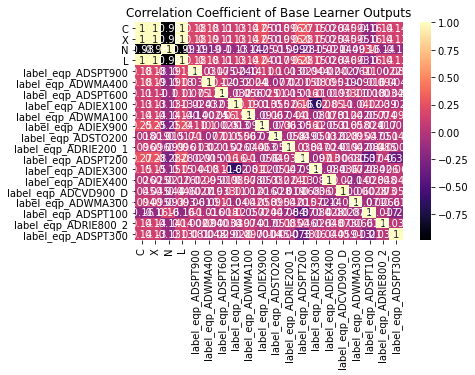

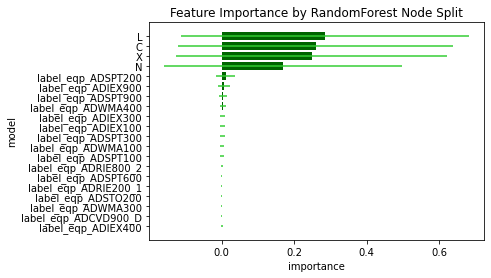

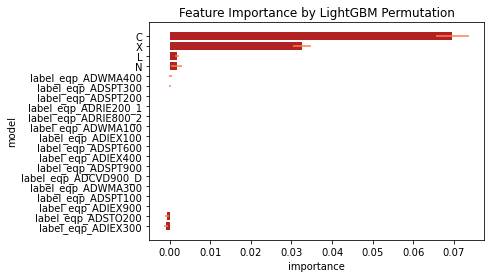

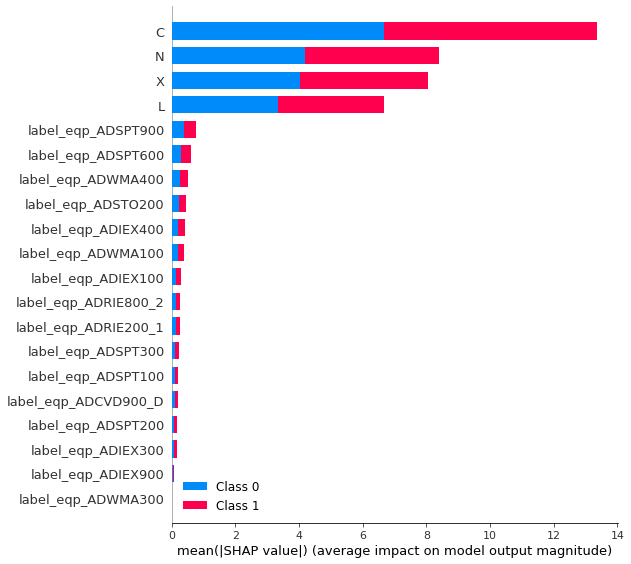

Dataset2:
                           C      L       X      N  label_eqp_ADIEX600  \
C                        inf  73.90  103.89  -0.50                0.26   
L                      73.90    inf   88.07  -0.49                0.24   
X                     103.89  88.07     inf  -0.50                0.25   
N                      -0.50  -0.49   -0.50    inf               -0.17   
label_eqp_ADIEX600      0.26   0.24    0.25  -0.17                 inf   
label_eqp_ADIEXA00     -0.17  -0.16   -0.17   0.25               -0.34   
label_eqp_ADIEX900      0.18   0.18    0.18  -0.14                0.15   
label_eqp_ADSPT800     -0.14  -0.14   -0.14   0.21                0.01   
label_eqp_ADSPT900      0.16   0.16    0.16  -0.13                0.05   
label_eqp_ADIEX400     -0.01  -0.01   -0.01   0.01               -0.37   
label_eqp_ADSPT200      0.21   0.21    0.21  -0.15               -0.05   
label_eqp_ADIEX800     -0.13  -0.12   -0.13   0.19               -0.10   
label_eqp_ADSTO100      0.13

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 2997, number of negative: 2997
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 5994, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


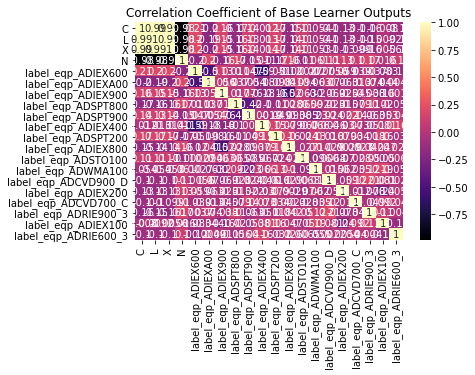

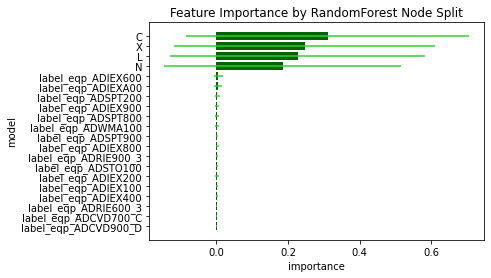

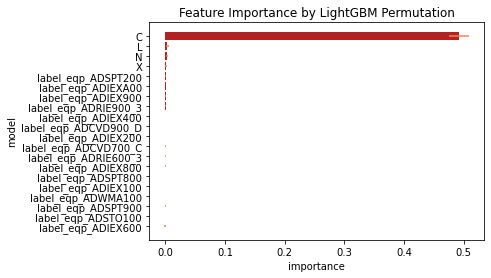

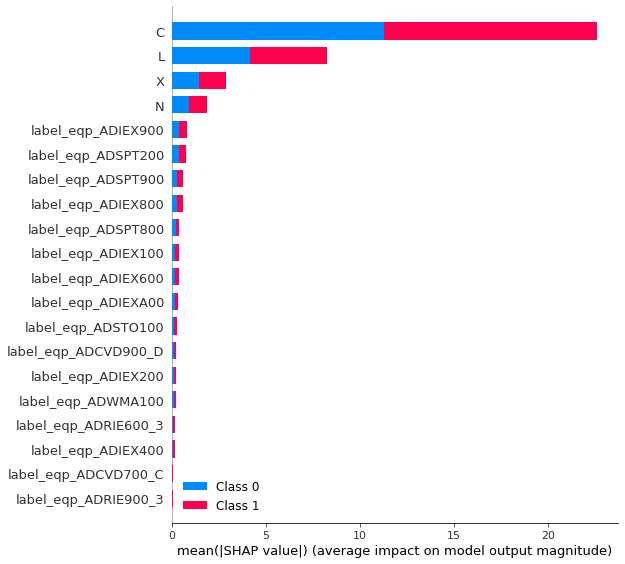

Dataset3:
                          N       X       C      L  label_eqp_ADCVD900_B  \
N                       inf   -0.49   -0.49  -0.49                  0.11   
X                     -0.49     inf  177.00  60.05                 -0.08   
C                     -0.49  177.00     inf  53.00                 -0.08   
L                     -0.49   60.05   53.00    inf                 -0.09   
label_eqp_ADCVD900_B   0.11   -0.08   -0.08  -0.09                   inf   
label_eqp_ADCVD300_E   0.16   -0.11   -0.11  -0.12                  0.01   
label_eqp_ADWMA500     0.36   -0.20   -0.20  -0.21                 -0.02   
label_eqp_ADCVD800_D  -0.02    0.03    0.02   0.03                 -0.06   
label_eqp_ADRIE600_2   0.07   -0.07   -0.07  -0.07                  0.04   
label_eqp_ADRIE500_1  -0.00    0.00   -0.00  -0.00                 -0.02   
label_eqp_ADRIE800_1  -0.01    0.02    0.02   0.02                  0.01   
label_eqp_ADWMA400    -0.02    0.02    0.02   0.02                 -0.03   
la

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3033, number of negative: 3033
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5098
[LightGBM] [Info] Number of data points in the train set: 6066, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


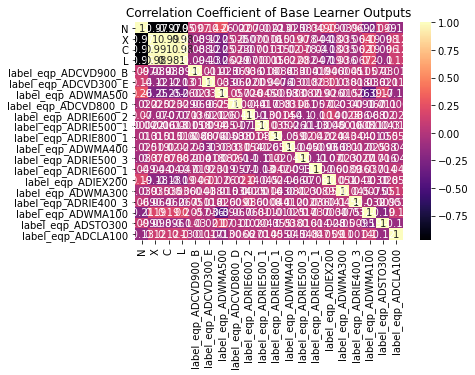

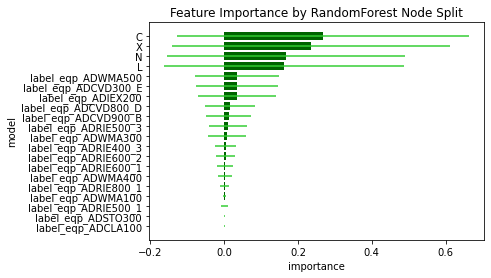

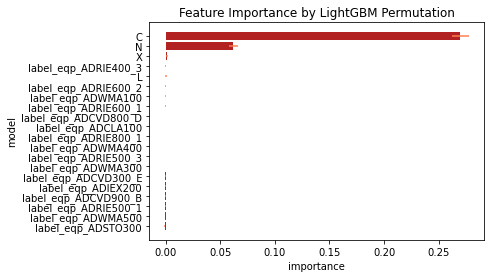

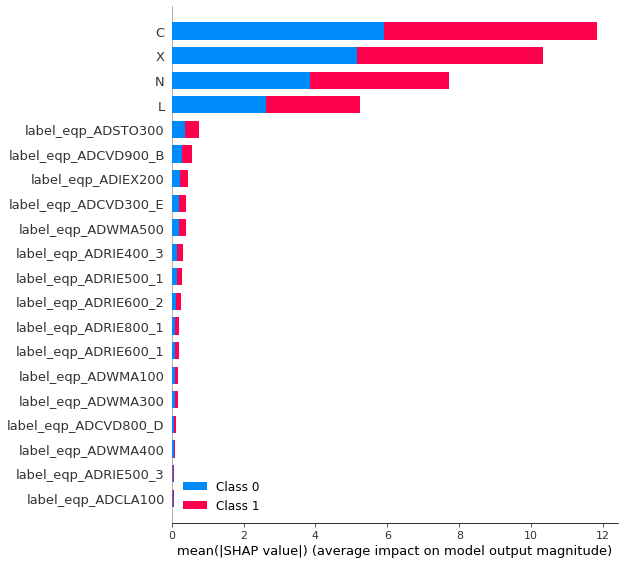

Dataset4:
                           C       X      N       L  label_eqp_ADSPT200  \
C                        inf  135.86  -0.50  100.97                0.34   
X                     135.86     inf  -0.50  155.81                0.34   
N                      -0.50   -0.50    inf   -0.50               -0.21   
L                     100.97  155.81  -0.50     inf                0.35   
label_eqp_ADSPT200      0.34    0.34  -0.21    0.35                 inf   
label_eqp_ADSTO500     -0.04   -0.04   0.04   -0.04                0.13   
label_eqp_ADIEX900      0.28    0.29  -0.18    0.30               -0.04   
label_eqp_ADSTO300     -0.05   -0.05   0.05   -0.05               -0.15   
label_eqp_ADRIE500_3    0.24    0.23  -0.16    0.25                0.09   
label_eqp_ADRIE200_1    0.16    0.16  -0.13    0.17                0.08   
label_eqp_ADIEX300      0.14    0.14  -0.11    0.14               -0.12   
label_eqp_ADCVD900_A    0.02    0.02  -0.02    0.02                0.06   
label_eqp_ADSPT

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3038, number of negative: 3038
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 6076, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


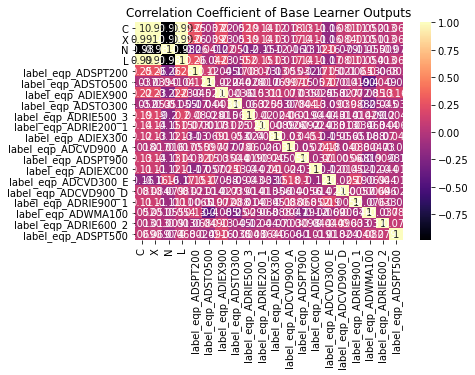

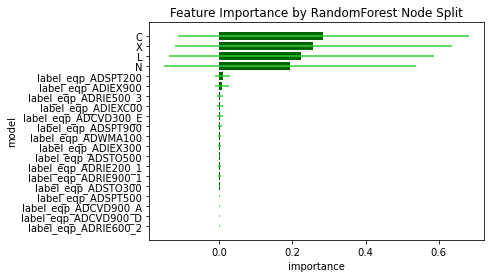

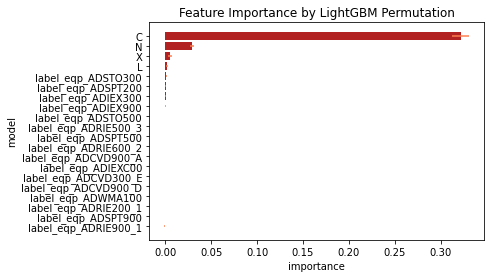

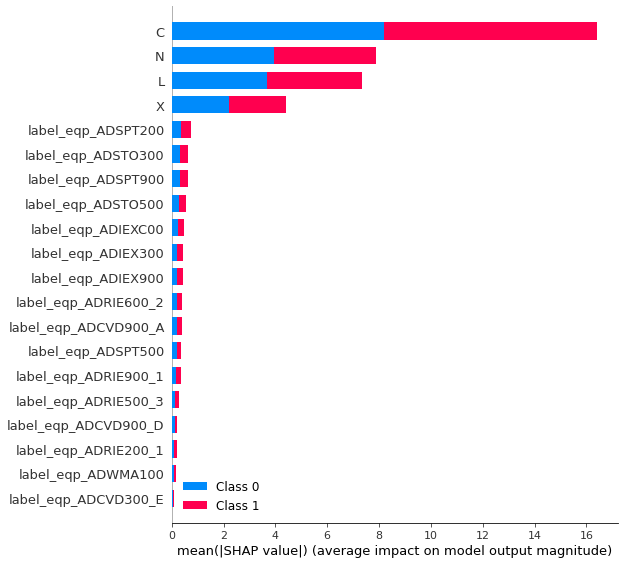

Dataset5:
                           C       L       X      N  label_eqp_ADWMA100  \
C                        inf  188.50  165.65  -0.50                0.15   
L                     188.50     inf  320.42  -0.50                0.16   
X                     165.65  320.42     inf  -0.50                0.15   
N                      -0.50   -0.50   -0.50    inf               -0.12   
label_eqp_ADWMA100      0.15    0.16    0.15  -0.12                 inf   
label_eqp_ADSTO400      0.26    0.26    0.26  -0.17                0.20   
label_eqp_ADSPT200      0.35    0.35    0.34  -0.21                0.11   
label_eqp_ADIEX900      0.35    0.36    0.35  -0.22               -0.08   
label_eqp_ADIEX100      0.15    0.15    0.14  -0.12                0.24   
label_eqp_ADWTO100      0.08    0.08    0.08  -0.07                0.05   
label_eqp_ADCVD900_D    0.03    0.03    0.03  -0.03                0.02   
label_eqp_ADIEXC00      0.16    0.17    0.16  -0.13               -0.07   
label_eqp_ADRIE

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3020, number of negative: 3040
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 6060, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498350 -> initscore=-0.006601
[LightGBM] [Info] Start training from score -0.006601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


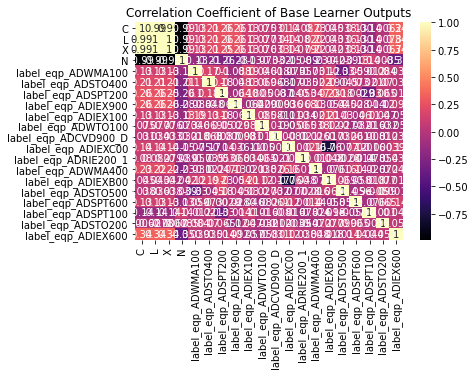

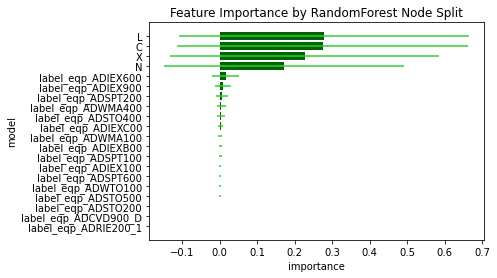

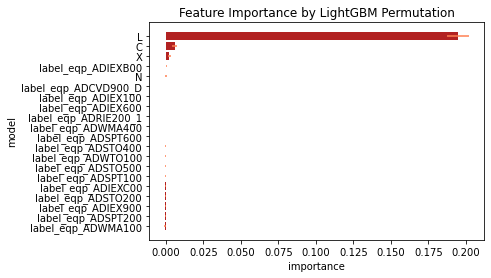

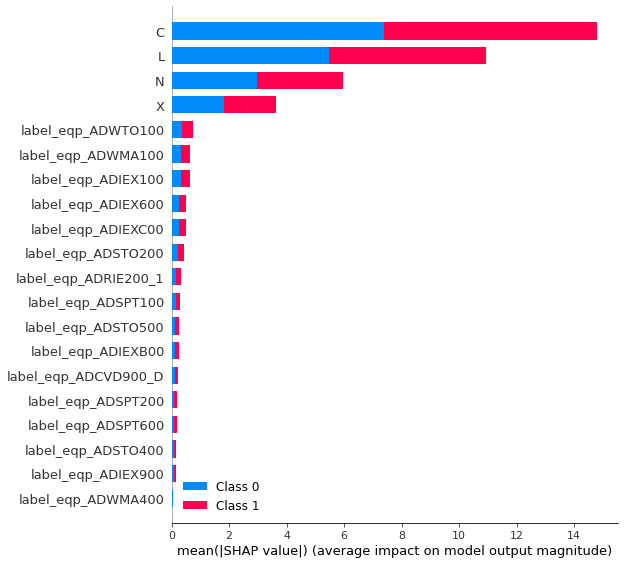

Dataset6:
                           C       L      N      X  label_eqp_ADSPT100  \
C                        inf  194.19  -0.49  98.63               -0.19   
L                     194.19     inf  -0.49  96.86               -0.19   
N                      -0.49   -0.49    inf  -0.49                0.32   
X                      98.63   96.86  -0.49    inf               -0.20   
label_eqp_ADSPT100     -0.19   -0.19   0.32  -0.20                 inf   
label_eqp_ADIEX600      0.35    0.34  -0.20   0.36               -0.01   
label_eqp_ADSTO200     -0.10   -0.10   0.14  -0.11                0.05   
label_eqp_ADSPT800     -0.12   -0.12   0.15  -0.12                0.05   
label_eqp_ADWMA500      0.04    0.04  -0.03   0.04                0.10   
label_eqp_ADRIE900_3   -0.12   -0.12   0.15  -0.12                0.01   
label_eqp_ADIEX300      0.04    0.04  -0.03   0.04               -0.03   
label_eqp_ADCVD900_D   -0.07   -0.07   0.08  -0.07                0.01   
label_eqp_ADSPT900      0.12

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 2990, number of negative: 3040
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1051
[LightGBM] [Info] Number of data points in the train set: 6030, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495854 -> initscore=-0.016584
[LightGBM] [Info] Start training from score -0.016584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


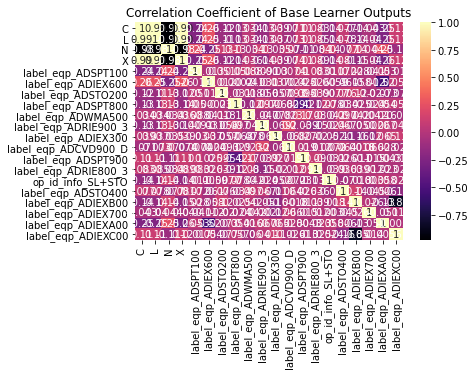

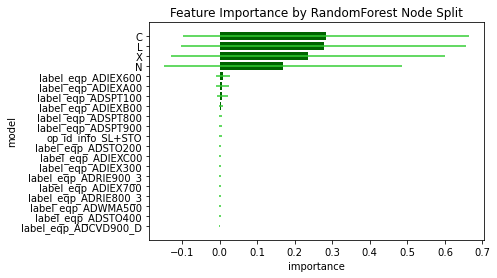

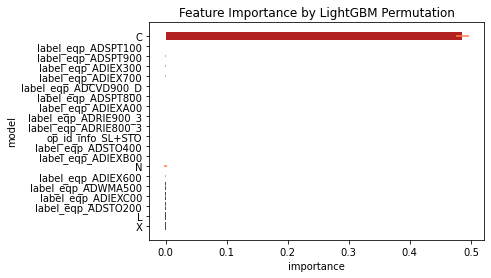

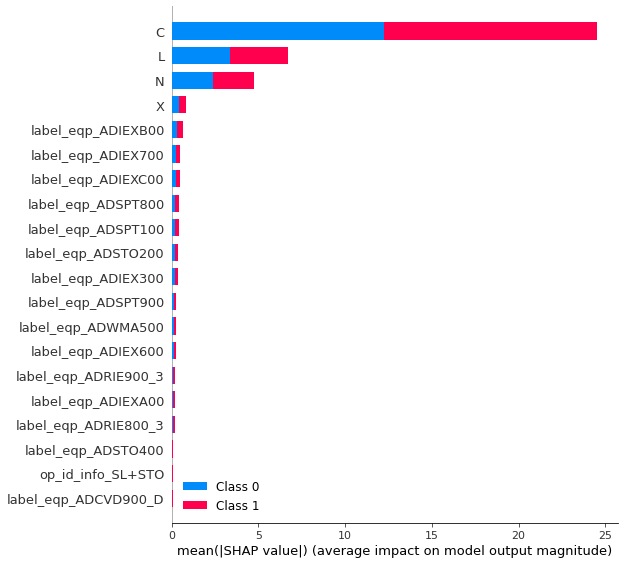

Dataset7:
                          N      C      L      X  label_eqp_ADRIE800_3  \
N                       inf  -0.49  -0.49  -0.49                 -0.02   
C                     -0.49    inf  34.35  96.37                  0.02   
L                     -0.49  34.35    inf  70.70                  0.02   
X                     -0.49  96.37  70.70    inf                  0.02   
label_eqp_ADRIE800_3  -0.02   0.02   0.02   0.02                   inf   
label_eqp_ADRIE600_1   0.03  -0.02  -0.03  -0.02                 -0.04   
label_eqp_ADCVD900_C   0.04  -0.03  -0.04  -0.04                 -0.06   
label_eqp_ADRIE300_1   0.03  -0.03  -0.03  -0.03                 -0.01   
label_eqp_ADSPT600     0.04  -0.03  -0.03  -0.03                 -0.00   
label_eqp_ADWMA100    -0.01   0.01   0.01   0.01                 -0.04   
label_eqp_ADSTO400    -0.10   0.12   0.12   0.12                  0.01   
label_eqp_ADCVD900_D   0.06  -0.05  -0.06  -0.06                 -0.02   
label_eqp_ADRIE500_3  -0.06 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 2765, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5099
[LightGBM] [Info] Number of data points in the train set: 5805, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476314 -> initscore=-0.094817
[LightGBM] [Info] Start training from score -0.094817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


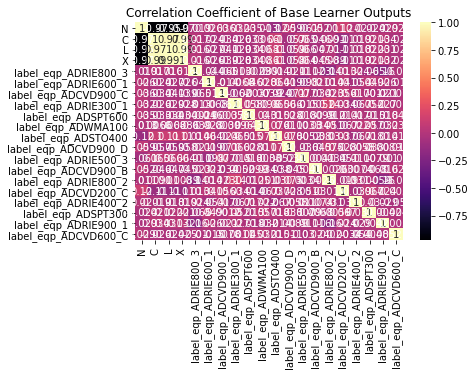

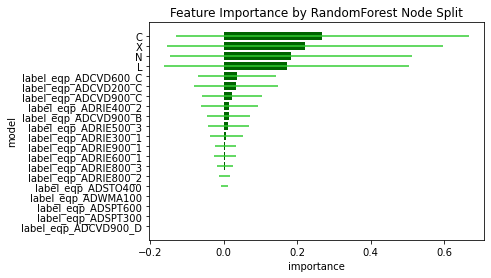

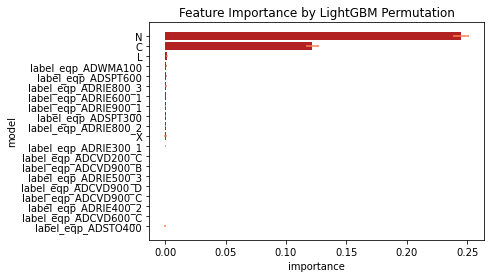

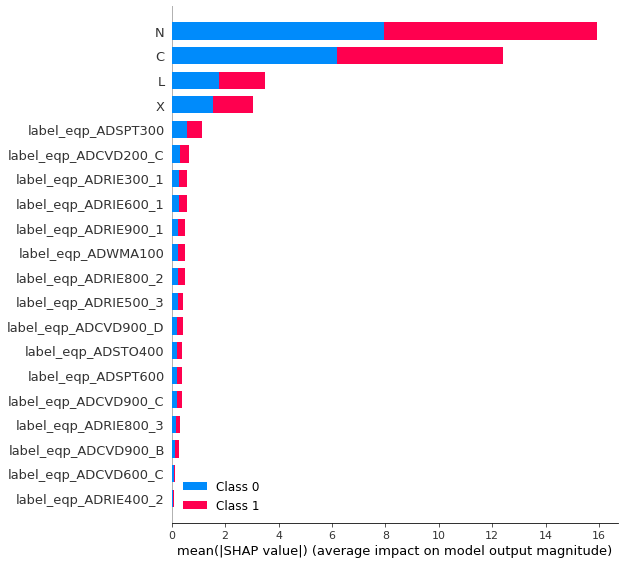

Dataset8:
                           C       L      N       X  label_eqp_ADSTO400  \
C                        inf  196.45  -0.50  126.91                0.08   
L                     196.45     inf  -0.50  324.17                0.08   
N                      -0.50   -0.50    inf   -0.50               -0.07   
X                     126.91  324.17  -0.50     inf                0.07   
label_eqp_ADSTO400      0.08    0.08  -0.07    0.07                 inf   
label_eqp_ADIEX900      0.29    0.29  -0.19    0.29               -0.06   
label_eqp_ADIEXA00     -0.19   -0.19   0.32   -0.19                0.03   
label_eqp_ADSTO100      0.15    0.16  -0.12    0.16               -0.12   
label_eqp_ADWMA400      0.16    0.16  -0.12    0.16               -0.08   
label_eqp_ADRIE500_3    0.29    0.29  -0.19    0.29                0.05   
label_eqp_ADRIE200_1    0.21    0.21  -0.15    0.21               -0.01   
label_eqp_ADSPT200      0.35    0.36  -0.21    0.35                0.19   
label_eqp_ADSPT

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3040, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 6080, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


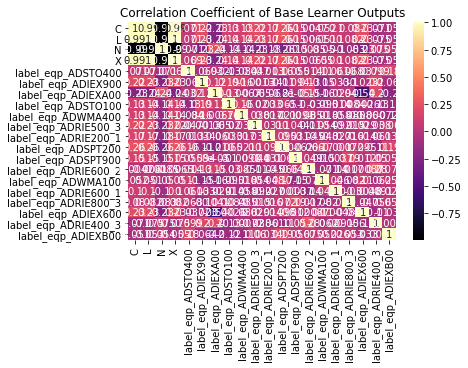

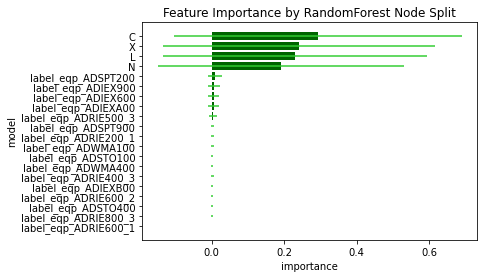

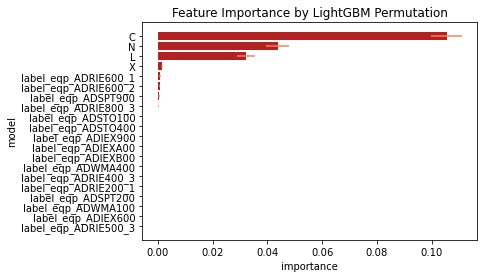

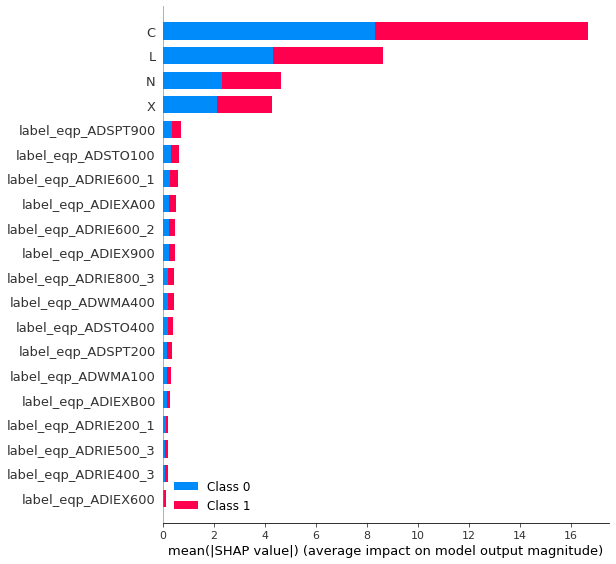

Dataset9:
                          C      X      L  label_eqp_ADCVD900_D     N  \
C                       inf  29.03  10.17                 -0.01 -0.21   
X                     29.03    inf  23.59                 -0.02 -0.23   
L                     10.17  23.59    inf                 -0.03 -0.24   
label_eqp_ADCVD900_D  -0.01  -0.02  -0.03                   inf -0.00   
N                     -0.21  -0.23  -0.24                 -0.00   inf   
label_eqp_ADRIE400_3  -0.08  -0.08  -0.09                 -0.02  0.01   
label_eqp_ADSPT600    -0.02  -0.02  -0.02                 -0.04  0.02   
label_eqp_ADRIE600_1   0.01   0.01  -0.00                 -0.01 -0.06   
label_eqp_ADSPT200     0.11   0.12   0.13                  0.02 -0.14   
label_eqp_ADIEX900     0.11   0.12   0.12                 -0.03 -0.20   
label_eqp_ADSTO500    -0.03  -0.04  -0.04                  0.00  0.13   
label_eqp_ADRIE600_2  -0.02  -0.02  -0.02                  0.01  0.02   
label_eqp_ADSPT100    -0.17  -0.18  -0.19

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 304, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 3344, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


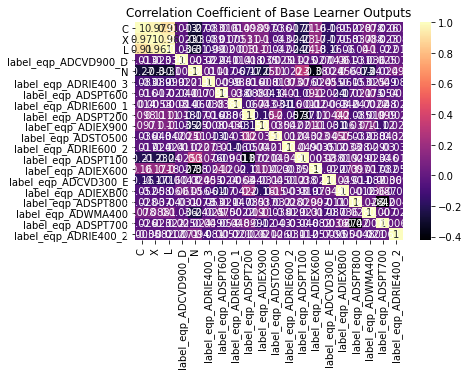

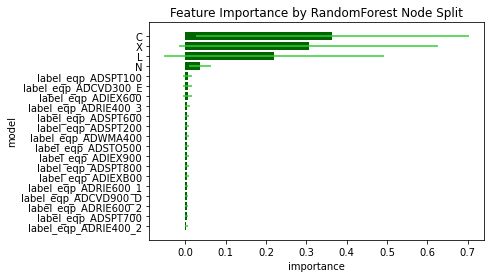

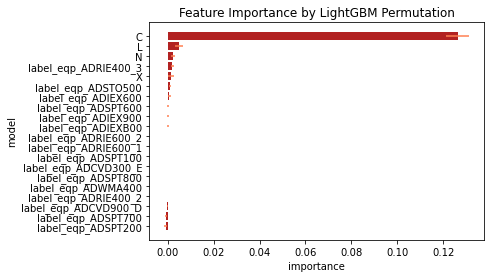

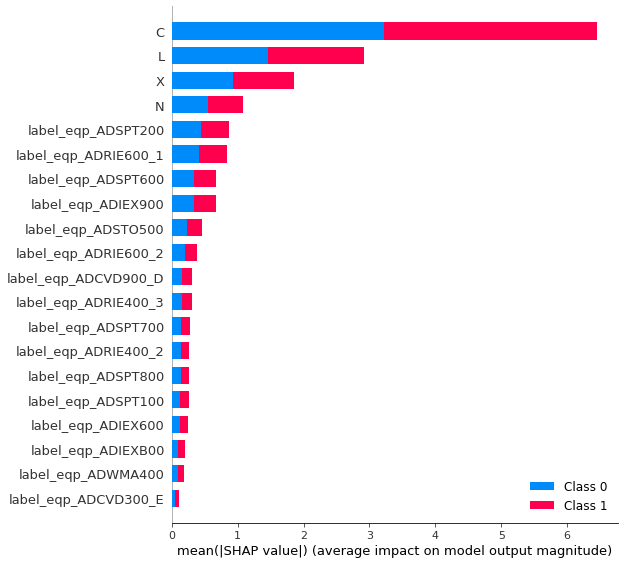

In [34]:
rank_dict = {}
for i in list(train_firstC.keys())[:-1]:
    print(f'Data{i}:')
    rank_dict[i] = rank_importance(train_firstC[i], mode = 'C')
    top_30 = rank_dict[i].index.values[:10]
    add_30 = np.append(top_30, 'GB')
    train_firstC[i] = train_firstC[i][add_30]
    test_firstC[i] = test_firstC[i][add_30]

### Search for The Best Hyperparameters

In [35]:
best_paramC, all_scoreC = all_optuna(all_data = train_firstC, 
                            mode = 'C', 
                            TPE_multi = False, 
                            n_iter = 10,
                            filename = 'runhist_array_m2m4_m5_3criteria_StackingCV1_XCLN_add10_tree',
                            creator = stackingCV_creator
)

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-17 11:31:05,239] A new study created in memory with name: no-name-a9658ab8-7622-452b-8b0e-f056e0d2be35


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9973787680209698 
Recall: 0.9921773142112125 
Aging Rate: 0.4973924380704042
Precision: 0.9947780678851175 
Recall: 0.9934810951760105 
Aging Rate: 0.49934810951760106
Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
[I 2022-03-17 11:31:06,466] Trial 0 finished with value: 0.9939051846124113 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 2}. Best is trial 0 with value: 0.9939051846124113.
Precision: 1.0 
Recall: 0.9882659713168188 
Aging Rate: 0.4941329856584094
Precision: 0.9973753280839895 
Recall: 0.9908735332464146 
Aging Rate: 0.49674054758800523
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
[I 2022-03-17 11:31:08,222] Trial 1 finished with value: 0.993892070937505 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 3}. Best is trial 0 with value: 0.9939051846124113.
Precisi

[I 2022-03-17 11:31:21,049] A new study created in memory with name: no-name-702137a4-9bdf-4697-8c8b-8b5a99696319


Precision: 0.9986807387862797 
Recall: 0.9869621903520208 
Aging Rate: 0.4941329856584094
[I 2022-03-17 11:31:20,952] Trial 9 finished with value: 0.9919162924607353 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 20, 'max_depth': 2}. Best is trial 6 with value: 0.9954232567579169.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9841059602649007 
Recall: 0.9906666666666667 
Aging Rate: 0.5033333333333333
Precision: 0.9854111405835544 
Recall: 0.9906666666666667 
Aging Rate: 0.5026666666666667
Precision: 0.9801587301587301 
Recall: 0.988 
Aging Rate: 0.504
[I 2022-03-17 11:31:22,761] Trial 0 finished with value: 0.9864903583986432 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 20, 'max_depth': 2}. Best is trial 0 with value: 0.9864903583986432.
Precision: 0.9699738903394256 
Recall: 0.9906666666666667 
Aging Rate: 0.5106666666666667
Precision: 0.9866844207723036 
Recall: 0.988 
Aging Rate: 0.5006666666666667
Precision: 0.9827586206896551 
Recall: 0.988 
Aging Rate: 0.5026666666666667
[I 2022-03-17 11:31:24,045] Trial 1 finished with value: 0.9843083981238753 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 4}. Best is trial 0 with value: 0.9864903583986432.
Precision: 0.9802110817941952 
Recall: 0.9906

[I 2022-03-17 11:31:38,154] A new study created in memory with name: no-name-323143ca-ddb1-4129-aa17-e74902a6b163


Precision: 0.9815303430079155 
Recall: 0.992 
Aging Rate: 0.5053333333333333
[I 2022-03-17 11:31:38,055] Trial 9 finished with value: 0.9878195345048688 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 5 with value: 0.9911157854132973.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9973404255319149 
Recall: 0.9881422924901185 
Aging Rate: 0.49538866930171277
Precision: 0.9920844327176781 
Recall: 0.9907773386034255 
Aging Rate: 0.4993412384716733
Precision: 0.9986666666666667 
Recall: 0.9868247694334651 
Aging Rate: 0.49407114624505927
[I 2022-03-17 11:31:40,330] Trial 0 finished with value: 0.9922869706771259 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 8, 'max_depth': 2}. Best is trial 0 with value: 0.9922869706771259.
Precision: 0.9960212201591512 
Recall: 0.9894598155467721 
Aging Rate: 0.49670619235836627
Precision: 0.9947159841479525 
Recall: 0.9920948616600791 
Aging Rate: 0.4986824769433465
Precision: 0.9986702127659575 
Recall: 0.9894598155467721 
Aging Rate: 0.49538866930171277
[I 2022-03-17 11:31:42,076] Trial 1 finished with value: 0.993392349917949 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 22, 'max_depth': 4}. Best is trial 1 with value: 0.99339234

[I 2022-03-17 11:31:57,020] A new study created in memory with name: no-name-71a9679c-5b4b-4233-bf8c-9be7be948b3e


Precision: 0.9960369881109643 
Recall: 0.9934123847167325 
Aging Rate: 0.4986824769433465
[I 2022-03-17 11:31:56,917] Trial 9 finished with value: 0.9916228513620725 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 20, 'max_depth': 2}. Best is trial 6 with value: 0.9945014735690666.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
[I 2022-03-17 11:31:59,164] Trial 0 finished with value: 0.99097065983464 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 3}. Best is trial 0 with value: 0.99097065983464.
Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9973544973544973 
Recall: 0.9921052631578947 
Aging Rate: 0.49736842105263157
[I 2022-03-17 11:32:00,446] Trial 1 finished with value: 0.9929604569955677 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 4}. Best is trial 1 with value: 0.992960456995

[I 2022-03-17 11:32:14,176] A new study created in memory with name: no-name-0b9e0355-1bb6-4b83-864e-20c99b7adf65


Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
[I 2022-03-17 11:32:14,077] Trial 9 finished with value: 0.9920774456249614 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 4}. Best is trial 1 with value: 0.9929604569955677.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
Precision: 0.9933422103861518 
Recall: 0.9880794701986755 
Aging Rate: 0.4957095709570957
[I 2022-03-17 11:32:15,373] Trial 0 finished with value: 0.991822114841664 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 18, 'max_depth': 4}. Best is trial 0 with value: 0.991822114841664.
Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Rate: 0.4957095709570957
Precision: 1.0 
Recall: 0.9920529801324504 
Aging Rate: 0.49438943894389437
Precision: 0.9973333333333333 
Recall: 0.990728476821192 
Aging Rate: 0.49504950495049505
[I 2022-03-17 11:32:17,645] Trial 1 finished with value: 0.9953488360358899 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 16, 'max_depth': 4}. Best is trial 1 with value: 0.9953488360358899.
Precision: 

[I 2022-03-17 11:32:33,780] A new study created in memory with name: no-name-d51b66de-dd8c-4a15-859c-084a0eefab88


Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
[I 2022-03-17 11:32:33,683] Trial 9 finished with value: 0.9920251054404937 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 4}. Best is trial 1 with value: 0.9953488360358899.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9775725593667546 
Recall: 0.9906417112299465 
Aging Rate: 0.5026525198938993
Precision: 0.9840848806366048 
Recall: 0.9919786096256684 
Aging Rate: 0.5
Precision: 0.9880636604774535 
Recall: 0.9959893048128342 
Aging Rate: 0.5
[I 2022-03-17 11:32:34,962] Trial 0 finished with value: 0.9880301253927919 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 18, 'max_depth': 4}. Best is trial 0 with value: 0.9880301253927919.
Precision: 0.9867197875166003 
Recall: 0.9933155080213903 
Aging Rate: 0.4993368700265252
Precision: 0.9854304635761589 
Recall: 0.9946524064171123 
Aging Rate: 0.5006631299734748
Precision: 0.9853528628495339 
Recall: 0.9893048128342246 
Aging Rate: 0.4980106100795756
[I 2022-03-17 11:32:36,733] Trial 1 finished with value: 0.9891171685201758 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 20, 'max_depth': 4}. Best is trial 1 with value: 0.9891171685201758.
Precision: 0.989347536

[I 2022-03-17 11:32:51,437] A new study created in memory with name: no-name-f0250e51-8a9e-43c4-ab6d-e52c65ed5149


Precision: 0.9840637450199203 
Recall: 0.9906417112299465 
Aging Rate: 0.4993368700265252
[I 2022-03-17 11:32:51,333] Trial 9 finished with value: 0.9884548043573851 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 2 with value: 0.9911090196422864.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9913294797687862 
Aging Rate: 0.4724517906336088
Precision: 0.9970887918486172 
Recall: 0.9898843930635838 
Aging Rate: 0.4731404958677686
Precision: 1.0 
Recall: 0.9898843930635838 
Aging Rate: 0.47176308539944906
[I 2022-03-17 11:32:53,113] Trial 0 finished with value: 0.9946786267425177 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 14, 'max_depth': 3}. Best is trial 0 with value: 0.9946786267425177.
Precision: 0.997080291970803 
Recall: 0.9869942196531792 
Aging Rate: 0.47176308539944906
Precision: 1.0 
Recall: 0.9913294797687862 
Aging Rate: 0.4724517906336088
Precision: 0.9970717423133236 
Recall: 0.9841040462427746 
Aging Rate: 0.4703856749311295
[I 2022-03-17 11:32:55,366] Trial 1 finished with value: 0.9927343125261489 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 20, 'max_depth': 2}. Best is trial 0 with value: 0.9946786267425177.
Precision: 0.9970972423802612 
Recal

[I 2022-03-17 11:33:07,092] A new study created in memory with name: no-name-23d4a541-8a16-45a8-9231-bf761535d991


Precision: 0.997080291970803 
Recall: 0.9869942196531792 
Aging Rate: 0.47176308539944906
[I 2022-03-17 11:33:06,988] Trial 9 finished with value: 0.9932265452559066 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 3}. Best is trial 0 with value: 0.9946786267425177.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
[I 2022-03-17 11:33:08,287] Trial 0 finished with value: 0.9896362470921294 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 2}. Best is trial 0 with value: 0.9896362470921294.
Precision: 0.9933862433862434 
Recall: 0.9881578947368421 
Aging Rate: 0.49736842105263157
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2022-03-17 11:33:10,495] Trial 1 finished with value: 0.9883032238544279 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 20, 'max_depth': 2}. Best is trial 0 with value: 0.9896362470921294.
Pre

[I 2022-03-17 11:33:23,754] A new study created in memory with name: no-name-c70f26f8-3f6d-418f-b447-58f2840aab96


Precision: 0.9959623149394348 
Recall: 0.9736842105263158 
Aging Rate: 0.4888157894736842
[I 2022-03-17 11:33:23,658] Trial 9 finished with value: 0.9862864091724698 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 20, 'max_depth': 4}. Best is trial 5 with value: 0.9907465450986406.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9682539682539683 
Recall: 0.8026315789473685 
Aging Rate: 0.07535885167464115
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
[I 2022-03-17 11:33:25,446] Trial 0 finished with value: 0.8930354308102814 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 4}. Best is trial 0 with value: 0.8930354308102814.
Precision: 0.9705882352941176 
Recall: 0.868421052631579 
Aging Rate: 0.08133971291866028
Precision: 0.9714285714285714 
Recall: 0.8947368421052632 
Aging Rate: 0.08373205741626795
Precision: 0.971830985915493 
Recall: 0.9078947368421053 
Aging Rate: 0.08492822966507177
[I 2022-03-17 11:33:27,215] Trial 1 finished with value: 0.9289830087286056 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 18, 'max_depth': 4}. Best is trial 1 with value: 0.9289830087286056.

meta_learner n_estimators min_samples_split max_depth
set1   ExtraTrees          300                 2         4
set2   ExtraTrees          100                 2         4
set3   ExtraTrees          500                 2         4
set4   ExtraTrees          100                 8         4
set5   ExtraTrees          500                16         4
set6   ExtraTrees          300                14         3
set7   ExtraTrees          300                14         3
set8   ExtraTrees          100                24         2
set9   ExtraTrees          300                18         4

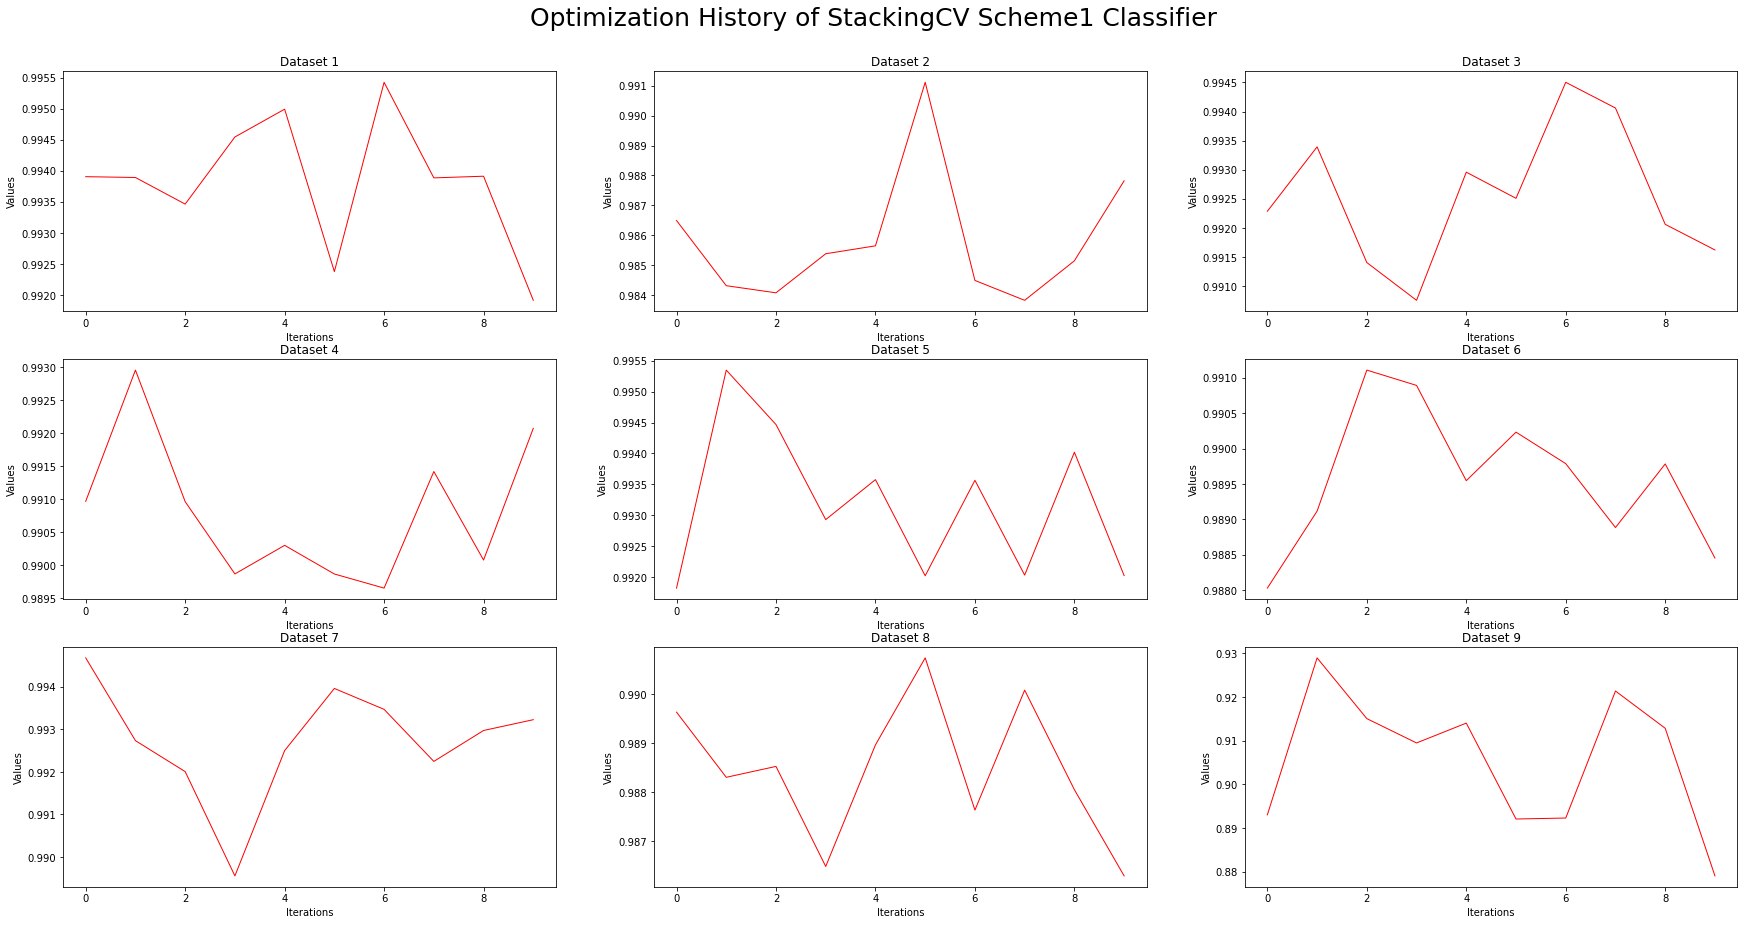

In [36]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'StackingCV Scheme1 Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

### Feature Importance of Meta Learner

                      label_eqp_ADAGX100  label_eqp_ADCLA100  \
label_eqp_ADAGX100                   inf                0.00   
label_eqp_ADCLA100                  0.00                 inf   
label_eqp_ADCVD100                   NaN                 NaN   
label_eqp_ADCVD100_C               -0.00                0.01   
label_eqp_ADCVD100_D               -0.00                0.01   
...                                  ...                 ...   
N                                  -0.01               -0.16   
X                                   0.01                0.23   
L                                   0.01                0.23   
C                                   0.01                0.24   
GB                                  0.01               -0.16   

                      label_eqp_ADCVD100  label_eqp_ADCVD100_C  \
label_eqp_ADAGX100                   NaN                 -0.00   
label_eqp_ADCLA100                   NaN                  0.01   
label_eqp_ADCVD100               

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3020, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 6060, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498350 -> initscore=-0.006601
[LightGBM] [Info] Start training from score -0.006601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


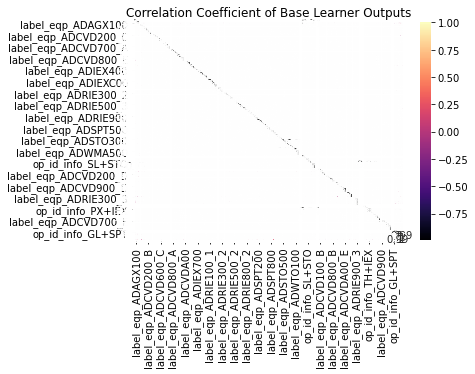

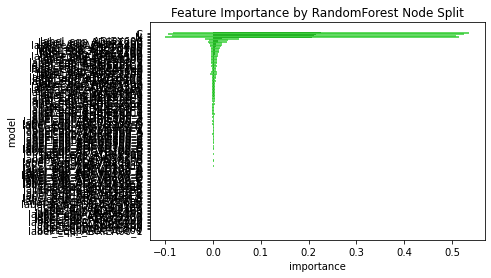

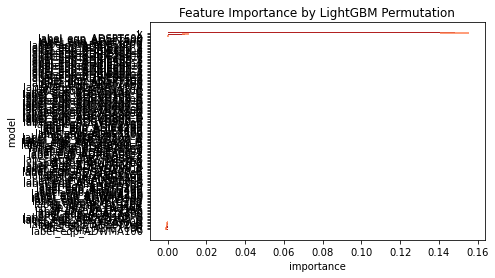

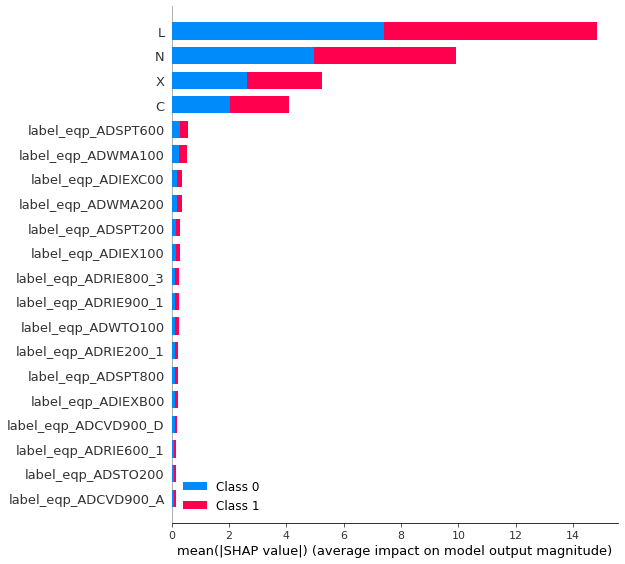

GLM  forest  permutation   SHAP  total_rank
L                       2.0     2.0          1.0    1.0         1.0
X                       1.0     4.0          2.0    3.0         2.0
label_eqp_ADSPT600     27.0    25.0          3.0    5.0         3.0
label_eqp_ADWMA400     11.0     8.0         64.5   30.0         4.0
label_eqp_ADIEX100     26.0    16.0         64.5   10.0         5.0
...                     ...     ...          ...    ...         ...
label_eqp_ADRIE300    122.0   121.5         64.5  103.5       122.0
label_eqp_ADCVD300    122.0   121.5         64.5  103.5       122.0
label_eqp_ADCVD900    122.0   121.5         64.5  103.5       122.0
label_eqp_ADCVD100    122.0   121.5         64.5  103.5       122.0
label_eqp_ADRIEA00_2  122.0   121.5         64.5  103.5       122.0

[131 rows x 5 columns]

In [9]:
target_set = 5
rank_importance(train_firstC[f'set{target_set}'], mode = 'C')

### Classifier

0it [00:00, ?it/s]


 Dataset1:
Precision: 0.0014787752261656228 
Recall: 0.3333333333333333 
Aging Rate: 0.2363049600197332

 Dataset2:
Precision: 0.001135825840037861 
Recall: 0.47058823529411764 
Aging Rate: 0.43433575201956875

 Dataset3:
Precision: 0.0010050972790580802 
Recall: 0.27450980392156865 
Aging Rate: 0.2863162654936381

 Dataset4:
Precision: 0.0012836970474967907 
Recall: 0.2549019607843137 
Aging Rate: 0.2081646077000555

 Dataset5:
Precision: 0.0015540651071486995 
Recall: 0.37254901960784315 
Aging Rate: 0.25131040720261466

 Dataset6:
Precision: 0.0011208117036337895 
Recall: 0.37254901960784315 
Aging Rate: 0.3484552611564472

 Dataset7:
Precision: 0.0011989301853730517 
Recall: 0.2549019607843137 
Aging Rate: 0.22288227918353923

 Dataset8:
Precision: 0.0013949433304272015 
Recall: 0.3137254901960784 
Aging Rate: 0.2357705194351374

 Dataset9:
Precision: 0.0009047044632086852 
Recall: 0.11764705882352941 
Aging Rate: 0.13632345988612304


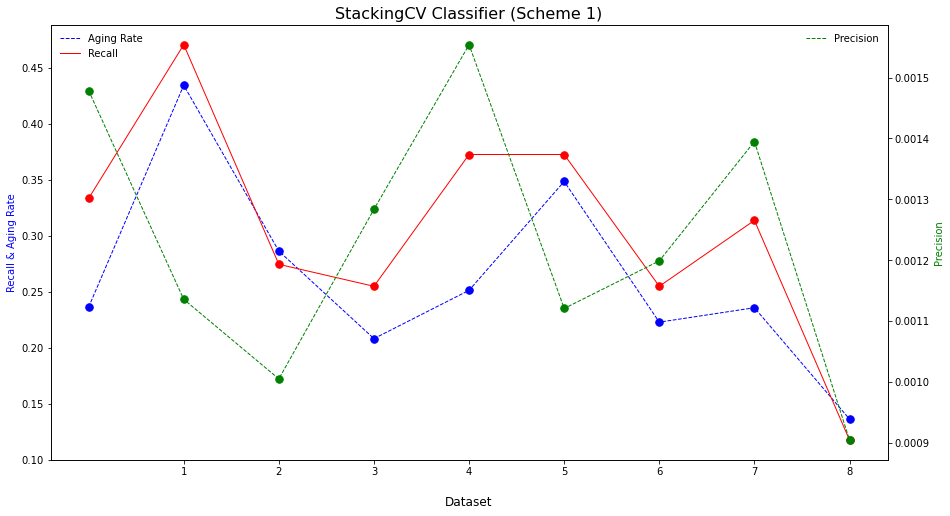

In [37]:
table_setC, coefC = runall_LR(train_firstC_x, test_firstC_x, train_firstC_y, test_firstC_y, best_paramC)
line_chart(table_setC, title = 'StackingCV Classifier (Scheme 1)')

In [38]:
table_setC

Balance Ratio  Train_OK  Train_NG    TP       FP    FN       TN  \
dataset1       1.000000    3067.0    3067.0  17.0  11479.0  34.0  37119.0   
dataset2       1.000000    2997.0    2997.0  24.0  21106.0  27.0  27492.0   
dataset3       1.000000    3033.0    3033.0  14.0  13915.0  37.0  34683.0   
dataset4       1.000000    3038.0    3038.0  13.0  10114.0  38.0  38484.0   
dataset5       1.006623    3040.0    3020.0  19.0  12207.0  32.0  36391.0   
dataset6       1.016722    3040.0    2990.0  19.0  16933.0  32.0  31665.0   
dataset7       1.099458    3040.0    2765.0  13.0  10830.0  38.0  37768.0   
dataset8       1.000000    3040.0    3040.0  16.0  11454.0  35.0  37144.0   
dataset9      10.000000    3040.0     304.0   6.0   6626.0  45.0  41972.0   

          Precision    Recall  Aging Rate  Efficiency  F1 Score     Score  
dataset1   0.001479  0.333333    0.236305    1.410607  0.001472  0.293293  
dataset2   0.001136  0.470588    0.434336    1.083466  0.001133  0.345427  
dataset3   0.001005  0.274510    0.286316    0.958764  0.001001  0.000000  
dataset4   0.001284  0.254902    0.208165    1.224521  0.001277  0.203805  
dataset5   0.001554  0.372549    0.251310    1.482426  0.001548  0.338735  
dataset6   0.001121  0.372549    0.348455    1.069144  0.001117  0.270894  
dataset7   0.001199  0.254902    0.222882    1.143662  0.001193  0.194367  
dataset8   0.001395  0.313725    0.235771    1.330639  0.001389  0.265456  
dataset9   0.000905  0.117647    0.136323    0.862999  0.000898  0.000000

### Export

In [39]:
savedate = '20220315'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'StackingCV1_XLCN_add10_tree'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'StackingCV1_XLCN_add10_tree')